## **Algoritmo de Pré-processamento de Dados**

In [6]:
import pandas as pd
import numpy as np

# --- 1. Carregamento dos Dados ---
# O arquivo 'gdp_per_capita.csv' está na pasta 'data/'.
file_path = 'data/gdp_per_capita.csv' # Caminho corrigido
try:
    df = pd.read_csv(file_path)
    print("--- Dados Originais Carregados com Sucesso ---")
    print(f"Shape original: {df.shape}")
    print("\n--- Informações Iniciais do DataFrame ---")
    df.info()
    print("\n--- Contagem de Valores Ausentes por Coluna (Original) ---")
    print(df.isnull().sum())
except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado. Verifique o caminho.")
    exit()
except Exception as e:
    print(f"Erro ao carregar o arquivo CSV: {e}")
    exit()

# --- 2. Limpeza do Nome da Coluna de Inflação ---
# A coluna de inflação possui aspas extras no nome.
original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)' # Nome sem aspas

if original_inflation_col_name in df.columns:
    # Refatorado para evitar inplace=True
    df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})
    print(f"\n--- Coluna de Inflação Renomeada para: '{cleaned_inflation_col_name}' ---")
else:
    print(f"\n--- Aviso: Coluna '{original_inflation_col_name}' não encontrada para renomear. Verifique o nome exato no CSV. ---")
    # Verifica se o nome limpo já existe (caso o CSV tenha sido corrigido manualmente)
    if cleaned_inflation_col_name not in df.columns:
        print(f"--- Aviso: A coluna '{cleaned_inflation_col_name}' também não foi encontrada. A coluna de inflação pode estar ausente ou ter um nome diferente. ---")


# --- 3. Tratamento de Valores Ausentes ---

# Coluna 'Code': Preencher com 'UNK' (Unknown) para entidades sem código.
if 'Code' in df.columns:
    # Refatorado para evitar inplace=True
    df['Code'] = df['Code'].fillna('UNK')
    print("\n--- Valores Ausentes em 'Code' preenchidos com 'UNK' ---")

# Colunas numéricas para imputação:
# Identificar colunas numéricas (excluindo 'Year' por enquanto, pois não deve ter NaNs ou será tratada de forma diferente se tiver)
numerical_cols_to_impute = []
if 'GDP per capita' in df.columns:
    numerical_cols_to_impute.append('GDP per capita')
if 'Value of global merchandise exports as a share of GDP' in df.columns:
    numerical_cols_to_impute.append('Value of global merchandise exports as a share of GDP')
if 'Government expenditure (% of GDP)' in df.columns:
    numerical_cols_to_impute.append('Government expenditure (% of GDP)')
if 'Trade as a Share of GDP' in df.columns:
    numerical_cols_to_impute.append('Trade as a Share of GDP')
if cleaned_inflation_col_name in df.columns: # Usar nome limpo
    numerical_cols_to_impute.append(cleaned_inflation_col_name)

print(f"\n--- Colunas numéricas identificadas para imputação: {numerical_cols_to_impute} ---")

# Estratégia de Imputação: Mediana por 'Entity'
# Isso ajuda a preservar as características de cada país/região.
# Se uma entidade tiver todos os valores ausentes para uma coluna, esses NaNs podem persistir
# ou uma estratégia de fallback (como a mediana global) poderia ser usada.
# Por simplicidade, vamos focar na mediana por grupo.

for col in numerical_cols_to_impute:
    if df[col].isnull().any(): # Processar apenas se houver NaNs
        print(f"Processando imputação para a coluna: {col}")
        # Converter para numérico, erros como 'coerce' transformarão não-números em NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Calcular mediana por grupo e preencher
        # Usar transform para alinhar os índices corretamente para o fillna
        # Esta linha já estava correta e não usava inplace da forma problemática
        df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))

        # Fallback: Se ainda houver NaNs (ex: entidade nova sem dados históricos para mediana do grupo),
        # preencher com a mediana global da coluna.
        if df[col].isnull().any():
            global_median = df[col].median()
            # Refatorado para evitar inplace=True
            df[col] = df[col].fillna(global_median)
            print(f"  NaNs restantes em '{col}' preenchidos com mediana global: {global_median:.2f}")
    else:
        # Garante que a coluna é numérica mesmo que não tenha NaNs para imputar
        df[col] = pd.to_numeric(df[col], errors='coerce')


# --- 4. Verificação de Tipos de Dados ---
# Garantir que 'Year' seja inteiro e colunas numéricas sejam float.
if 'Year' in df.columns:
    # Se houver NaNs em 'Year', pd.to_numeric com downcast='integer' falhará.
    # Primeiro, vamos tratar possíveis NaNs em 'Year' (embora incomum para esta coluna).
    # Uma estratégia poderia ser remover linhas com 'Year' ausente ou imputar se fizer sentido.
    # Por ora, vamos assumir que 'Year' não tem NaNs ou que eles foram tratados.
    # Se 'Year' puder ter NaNs e precisar de imputação, adicione lógica aqui.
    if df['Year'].isnull().any():
        print(f"\n--- Aviso: A coluna 'Year' contém {df['Year'].isnull().sum()} valores ausentes. Considere uma estratégia de tratamento. ---")
        # Exemplo: preencher com um valor placeholder ou remover linhas
        # df['Year'] = df['Year'].fillna(-1) # Placeholder
        # df = df.dropna(subset=['Year']) # Remover linhas
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64') # Int64 suporta NaNs se necessário

print("\n--- Tipos de Dados Após Conversões ---")
df.info()

# --- 5. Verificação Final de Valores Ausentes ---
print("\n--- Contagem de Valores Ausentes por Coluna (Após Pré-processamento) ---")
print(df.isnull().sum())

# --- 6. Exibição de Amostra dos Dados Pré-processados ---
print("\n--- Amostra dos Dados Pré-processados (Primeiras 10 Linhas) ---")
print(df.head(10))

print("\n--- Amostra dos Dados Pré-processados (Últimas 5 Linhas) ---")
print(df.tail())

print("\n--- Descrição Estatística dos Dados Numéricos Pré-processados ---")
# Selecionar apenas colunas numéricas para describe()
numeric_cols_for_describe = df.select_dtypes(include=np.number).columns.tolist()
if numeric_cols_for_describe:
    print(df[numeric_cols_for_describe].describe())
else:
    print("Nenhuma coluna numérica encontrada para descrição estatística.")

print("\n--- Pré-processamento Concluído ---")

--- Dados Originais Carregados com Sucesso ---
Shape original: (147615, 8)

--- Informações Iniciais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147615 entries, 0 to 147614
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Entity                                                 147615 non-null  object 
 1   Code                                                   11408 non-null   object 
 2   Year                                                   147615 non-null  int64  
 3   GDP per capita                                         147615 non-null  float64
 4   Value of global merchandise exports as a share of GDP  132596 non-null  float64
 5   Government expenditure (% of GDP)                      8413 non-null    float64
 6   Trade as a Share of GDP                                143729 non-null  float64
 7   In

## **Algoritmo de Engenharia de Features**

In [7]:
import pandas as pd
import numpy as np

# --- ETAPA 1: PRÉ-PROCESSAMENTO DE DADOS (Reutilizado do script anterior) ---
def preprocess_data(file_path='data/gdp_per_capita.csv'):
    """
    Carrega e pré-processa os dados do PIB per capita.
    """
    try:
        df = pd.read_csv(file_path)
        print("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_path}' não foi encontrado. Verifique o caminho.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o arquivo CSV: {e}")
        return None

    # Limpeza do Nome da Coluna de Inflação
    original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
    cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)'
    if original_inflation_col_name in df.columns:
        df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})
    # Se o nome já estiver limpo no CSV, o cleaned_inflation_col_name será usado diretamente.

    # Tratamento de Valores Ausentes na Coluna 'Code'
    if 'Code' in df.columns:
        df['Code'] = df['Code'].fillna('UNK')

    # Colunas numéricas para imputação
    numerical_cols_to_impute = []
    if 'GDP per capita' in df.columns:
        numerical_cols_to_impute.append('GDP per capita')
    if 'Value of global merchandise exports as a share of GDP' in df.columns:
        numerical_cols_to_impute.append('Value of global merchandise exports as a share of GDP')
    if 'Government expenditure (% of GDP)' in df.columns:
        numerical_cols_to_impute.append('Government expenditure (% of GDP)')
    if 'Trade as a Share of GDP' in df.columns:
        numerical_cols_to_impute.append('Trade as a Share of GDP')
    if cleaned_inflation_col_name in df.columns:
        numerical_cols_to_impute.append(cleaned_inflation_col_name)

    # Imputação
    for col in numerical_cols_to_impute:
        if col in df.columns: # Verifica se a coluna realmente existe
            if df[col].isnull().any():
                df[col] = pd.to_numeric(df[col], errors='coerce')
                # Imputação por mediana do grupo 'Entity'
                df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))
                # Fallback: Imputação por mediana global
                if df[col].isnull().any():
                    global_median = df[col].median()
                    df[col] = df[col].fillna(global_median)
            else:
                # Garante que a coluna é numérica
                df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Aviso (Pré-processamento): Coluna '{col}' não encontrada para imputação.")


    # Verificação de Tipos de Dados
    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

    print("--- Pré-processamento Concluído ---")
    return df

# Executa o pré-processamento
df_processed = preprocess_data()

if df_processed is not None:
    print("\n--- INÍCIO DA ENGENHARIA DE FEATURES (APRIMORADO) ---")

    # Garante que os dados estejam ordenados por Entidade e Ano para cálculos corretos
    df_processed = df_processed.sort_values(by=['Entity', 'Year']).reset_index(drop=True)

    # --- 2. Criação de Features Defasadas (Lag Features) ---
    if 'GDP per capita' in df_processed.columns:
        df_processed['GDP_per_capita_lag1'] = df_processed.groupby('Entity')['GDP per capita'].shift(1)
        print("Feature 'GDP_per_capita_lag1' criada.")
    else:
        print("Aviso: Coluna 'GDP per capita' não encontrada para criar lag feature.")

    inflation_col_name = 'Inflation, consumer prices (annual %)'
    if inflation_col_name in df_processed.columns:
        df_processed['Inflation_lag1'] = df_processed.groupby('Entity')[inflation_col_name].shift(1)
        print(f"Feature 'Inflation_lag1' criada a partir da coluna '{inflation_col_name}'.")
    else:
        print(f"Aviso: Coluna '{inflation_col_name}' não encontrada para criar lag feature.")

    if 'Trade as a Share of GDP' in df_processed.columns:
        df_processed['Trade_as_share_GDP_lag1'] = df_processed.groupby('Entity')['Trade as a Share of GDP'].shift(1)
        print("Feature 'Trade_as_share_GDP_lag1' criada.")
    else:
        print("Aviso: Coluna 'Trade as a Share of GDP' não encontrada para criar lag feature.")

    # --- 3. Criação de Features de Taxa de Crescimento ---
    if 'GDP per capita' in df_processed.columns:
        df_processed['GDP_growth_rate'] = df_processed.groupby('Entity')['GDP per capita'].pct_change() * 100
        print("Feature 'GDP_growth_rate' criada.")
         # Análise breve dos quartis da GDP_growth_rate
        if 'GDP_growth_rate' in df_processed.columns and not df_processed['GDP_growth_rate'].isnull().all():
            print("\n   Análise dos Quartis de 'GDP_growth_rate':")
            print(df_processed['GDP_growth_rate'].describe(percentiles=[.25, .5, .75]))
            zero_growth_count = (df_processed['GDP_growth_rate'] == 0).sum()
            near_zero_growth_count = (df_processed['GDP_growth_rate'].abs() < 0.001).sum() # Próximo de zero
            print(f"   Contagem de 'GDP_growth_rate' exatamente igual a 0: {zero_growth_count}")
            print(f"   Contagem de 'GDP_growth_rate' muito próximo de 0 (abs < 0.001): {near_zero_growth_count}")
            if zero_growth_count > 0:
                print("   A presença de zeros nos quartis pode ser devido a períodos de estagnação real ou")
                print("   efeito da imputação de mediana no pré-processamento se valores idênticos foram repetidos.")
        print("-" * 30) # Separador
    else:
        print("Aviso: Coluna 'GDP per capita' não encontrada para criar taxa de crescimento.")

    # --- 4. Criação de Médias Móveis e Volatilidade ---
    if 'GDP per capita' in df_processed.columns:
        # Média Móvel
        df_processed['GDP_per_capita_MA3'] = df_processed.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        print("Feature 'GDP_per_capita_MA3' criada.")
        # Volatilidade (Desvio Padrão Móvel)
        df_processed['GDP_per_capita_volatility3'] = df_processed.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
        print("Feature 'GDP_per_capita_volatility3' criada.")
        # Diferença da Média Móvel
        df_processed['GDP_per_capita_diff_MA3'] = df_processed['GDP per capita'] - df_processed['GDP_per_capita_MA3']
        print("Feature 'GDP_per_capita_diff_MA3' criada.")

    else:
        print("Aviso: Coluna 'GDP per capita' não encontrada para criar média móvel, volatilidade ou diferença da MA.")

    if inflation_col_name in df_processed.columns:
        # Volatilidade da Inflação (Desvio Padrão Móvel)
        df_processed['Inflation_volatility3'] = df_processed.groupby('Entity')[inflation_col_name].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
        print(f"Feature 'Inflation_volatility3' criada a partir da coluna '{inflation_col_name}'.")
    else:
        print(f"Aviso: Coluna '{inflation_col_name}' não encontrada para criar volatilidade da inflação.")


    # --- 5. Tratamento de Valores Ausentes Gerados pela Engenharia de Features ---
    print("\n--- Contagem de Valores Ausentes ANTES do tratamento específico pós-engenharia ---")
    new_features_for_nan_check = ['GDP_per_capita_lag1', 'Inflation_lag1', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate', 'GDP_per_capita_volatility3', 'Inflation_volatility3']
    # Filtra apenas as colunas que realmente existem no DataFrame para evitar KeyErrors
    existing_cols_for_check = [col for col in new_features_for_nan_check if col in df_processed.columns]
    if existing_cols_for_check:
        print(df_processed[existing_cols_for_check].isnull().sum())
    else:
        print("Nenhuma das novas features para verificação de NaN foi encontrada.")

    # Estratégia: Remover linhas que contenham NaNs nas features de lag ou taxa de crescimento.
    # Essas linhas representam o início da série temporal de cada entidade, onde essas features não podem ser calculadas.
    # Para volatilidade, min_periods=1 já lida com NaNs iniciais, preenchendo com 0 ou NaN se houver apenas 1 ponto.
    # Vamos focar em remover NaNs de lags e growth_rate que são mais críticos.

    cols_critical_for_nan_removal = []
    if 'GDP_per_capita_lag1' in df_processed.columns:
        cols_critical_for_nan_removal.append('GDP_per_capita_lag1')
    if 'Inflation_lag1' in df_processed.columns:
        cols_critical_for_nan_removal.append('Inflation_lag1')
    if 'Trade_as_share_GDP_lag1' in df_processed.columns:
        cols_critical_for_nan_removal.append('Trade_as_share_GDP_lag1')
    if 'GDP_growth_rate' in df_processed.columns:
        cols_critical_for_nan_removal.append('GDP_growth_rate')

    if cols_critical_for_nan_removal:
        original_rows = len(df_processed)
        df_featured = df_processed.dropna(subset=cols_critical_for_nan_removal).reset_index(drop=True)
        rows_removed = original_rows - len(df_featured)
        print(f"\n--- Tratamento de NaNs (Remoção): {rows_removed} linhas removidas com NaNs em features críticas. ---")
        print(f"Shape original após engenharia: {df_processed.shape}")
        print(f"Shape após remover NaNs das features críticas: {df_featured.shape}")
    else:
        print("\n--- Nenhuma coluna crítica para remoção de NaNs foi encontrada. Mantendo todas as linhas. ---")
        df_featured = df_processed.copy() # Mantém o DataFrame se nenhuma coluna crítica foi definida

    # Para as colunas de volatilidade, que usam min_periods=1, o desvio padrão para 1 ponto é NaN.
    # Pode ser útil preencher esses NaNs com 0, assumindo volatilidade zero com um único ponto de dados.
    volatility_cols_to_fill_zero = []
    if 'GDP_per_capita_volatility3' in df_featured.columns:
        volatility_cols_to_fill_zero.append('GDP_per_capita_volatility3')
    if 'Inflation_volatility3' in df_featured.columns:
        volatility_cols_to_fill_zero.append('Inflation_volatility3')

    for vol_col in volatility_cols_to_fill_zero:
        df_featured[vol_col] = df_featured[vol_col].fillna(0)
        print(f"NaNs em '{vol_col}' (gerados por std de 1 ponto) preenchidos com 0.")

    print("\n--- Contagem de Valores Ausentes APÓS tratamento específico pós-engenharia ---")
    if existing_cols_for_check: # Reutiliza a lista de colunas para verificar
        # Verifica apenas as colunas que ainda existem em df_featured
        final_check_cols = [col for col in existing_cols_for_check if col in df_featured.columns]
        if final_check_cols:
            print(df_featured[final_check_cols].isnull().sum())
        else:
            print("Nenhuma das colunas de verificação de NaN existe no DataFrame final.")
    else:
        print("Nenhuma das novas features para verificação de NaN foi encontrada.")


    # --- 6. Exibição de Amostra dos Dados com Novas Features ---
    df_to_show = df_featured # Agora df_to_show é o DataFrame após a remoção de NaNs e preenchimento de volatilidade

    print("\n--- Amostra dos Dados com Novas Features (Primeiras Linhas de Algumas Entidades) ---")
    if not df_to_show.empty:
        entities_to_sample = df_to_show['Entity'].unique()[:2]
        for entity in entities_to_sample:
            print(f"\n--- Amostra para a Entidade: {entity} ---")
            print(df_to_show[df_to_show['Entity'] == entity].head(7))
    else:
        print("DataFrame está vazio após tratamento de NaNs.")


    print("\n--- Amostra dos Dados com Novas Features (Últimas Linhas de Algumas Entidades) ---")
    if not df_to_show.empty:
        # Reutiliza as mesmas entidades para consistência, se ainda existirem
        existing_sample_entities = [e for e in entities_to_sample if e in df_to_show['Entity'].unique()]
        for entity in existing_sample_entities:
            print(f"\n--- Amostra para a Entidade: {entity} ---")
            print(df_to_show[df_to_show['Entity'] == entity].tail(7))
    else:
        print("DataFrame está vazio após tratamento de NaNs.")


    print("\n--- Descrição Estatística das Novas Features Numéricas ---")
    new_numeric_features = ['GDP_per_capita_lag1', 'Inflation_lag1', 'Trade_as_share_GDP_lag1',
                            'GDP_growth_rate', 'GDP_per_capita_MA3',
                            'GDP_per_capita_volatility3', 'GDP_per_capita_diff_MA3',
                            'Inflation_volatility3']

    existing_new_features = [col for col in new_numeric_features if col in df_to_show.columns]
    if existing_new_features and not df_to_show.empty:
        print(df_to_show[existing_new_features].describe())
    elif df_to_show.empty:
        print("DataFrame está vazio, não é possível gerar descrição estatística.")
    else:
        print("Nenhuma das novas features numéricas foi criada ou encontrada para descrição no DataFrame final.")

    print("\n--- ENGENHARIA DE FEATURES (APRIMORADO) CONCLUÍDA ---")
else:
    print("Engenharia de Features não pôde ser executada pois o pré-processamento falhou.")

--- Dados Originais Carregados com Sucesso (Pré-processamento) ---
--- Pré-processamento Concluído ---

--- INÍCIO DA ENGENHARIA DE FEATURES (APRIMORADO) ---
Feature 'GDP_per_capita_lag1' criada.
Feature 'Inflation_lag1' criada a partir da coluna 'Inflation, consumer prices (annual %)'.
Feature 'Trade_as_share_GDP_lag1' criada.
Feature 'GDP_growth_rate' criada.

   Análise dos Quartis de 'GDP_growth_rate':
count    147442.000000
mean          0.183104
std           2.353396
min         -61.236802
25%           0.000000
50%           0.000000
75%           0.000000
max         404.707766
Name: GDP_growth_rate, dtype: float64
   Contagem de 'GDP_growth_rate' exatamente igual a 0: 136062
   Contagem de 'GDP_growth_rate' muito próximo de 0 (abs < 0.001): 136063
   A presença de zeros nos quartis pode ser devido a períodos de estagnação real ou
   efeito da imputação de mediana no pré-processamento se valores idênticos foram repetidos.
------------------------------
Feature 'GDP_per_capita_

## **Análise Exploratória de Dados (EDA) Aprofundada - PIB per capita**

--- Dados Originais Carregados com Sucesso (Pré-processamento) ---
Aplicando interpolação linear para 'GDP per capita' por entidade...
--- Pré-processamento Concluído (com imputação aprimorada para PIB per capita) ---

--- INÍCIO DA ENGENHARIA DE FEATURES (EDA - Tratamento Outliers/Assimetria) ---
--- Engenharia de Features (EDA - Tratamento Outliers/Assimetria) Concluída ---

--- INÍCIO DO TRATAMENTO DE OUTLIERS E ASSIMETRIA ---
Coluna 'GDP per capita_log' criada com transformação logarítmica.
Coluna 'Trade as a Share of GDP_log' criada com transformação logarítmica.
Coluna 'Value of global merchandise exports as a share of GDP_log' criada com transformação logarítmica.
Coluna 'Inflation, consumer prices (annual %)_winsorized' criada. 2869 valores foram limitados pela winsorização.
Coluna 'GDP_growth_rate_winsorized' criada. 2948 valores foram limitados pela winsorização.
Coluna 'Government expenditure (% of GDP)_winsorized' criada. 2948 valores foram limitados pela winsorização.
Colu

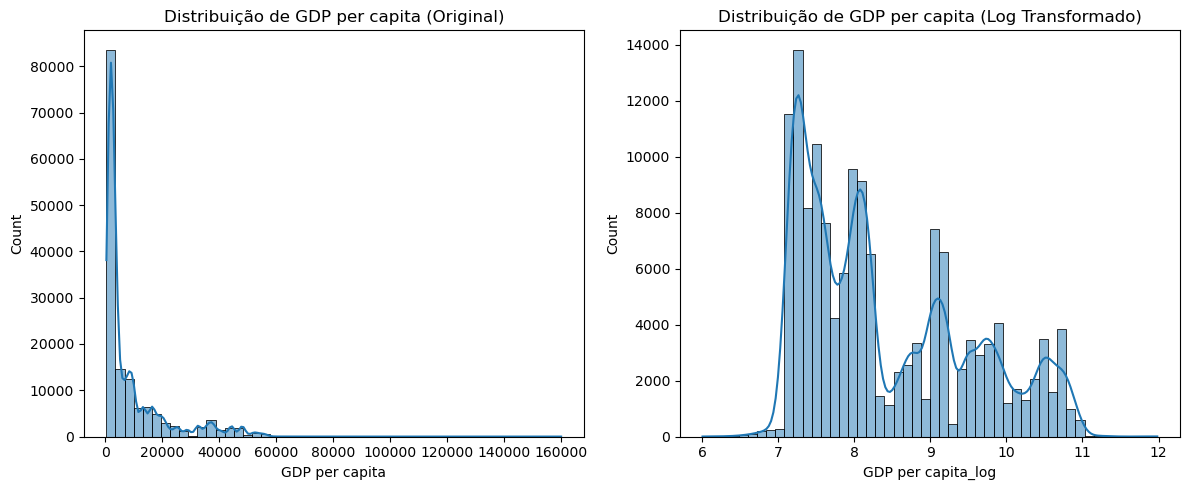

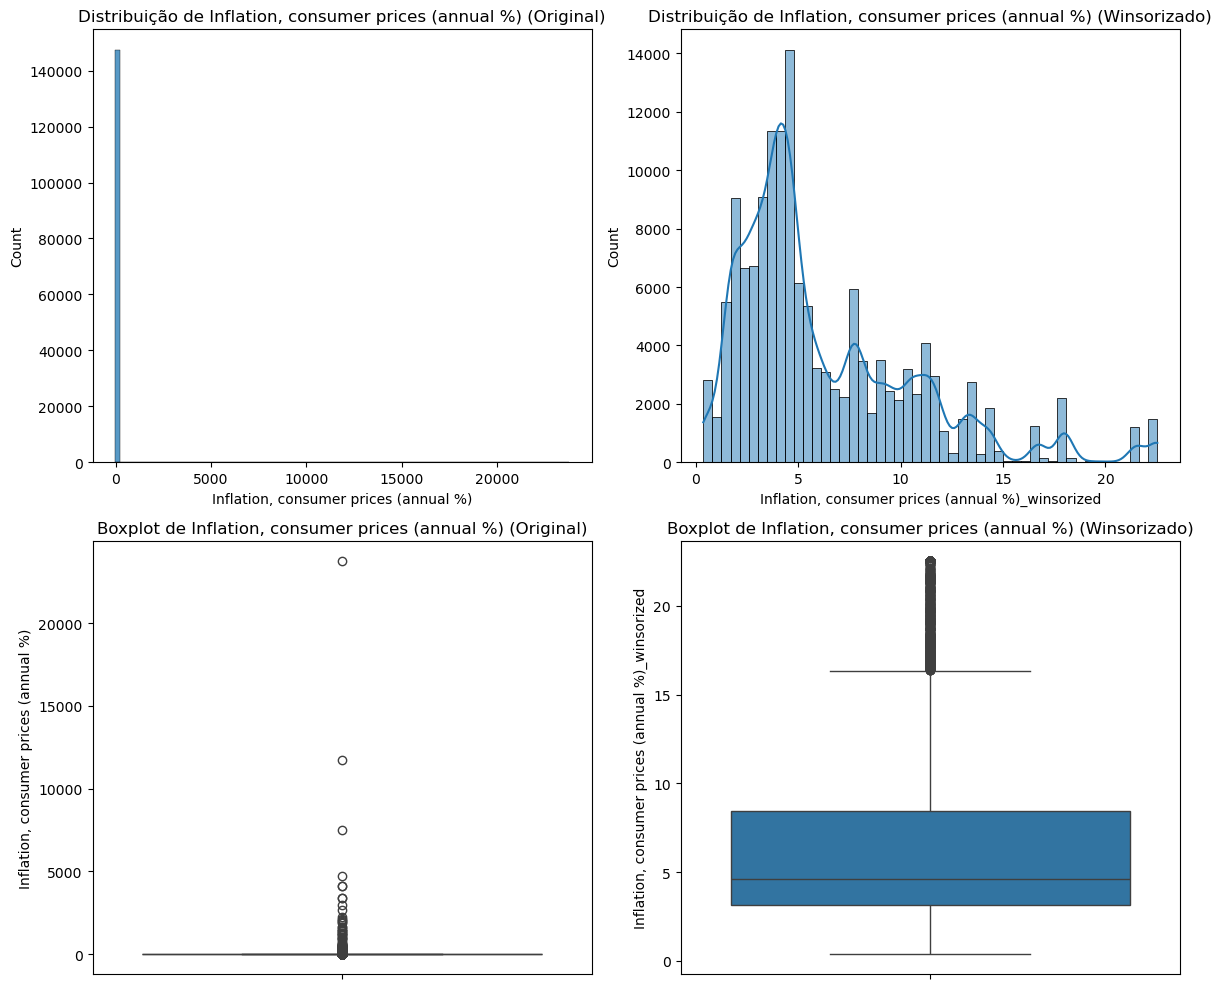


--- 3.3 Matriz de Correlação (Com Colunas Transformadas) ---


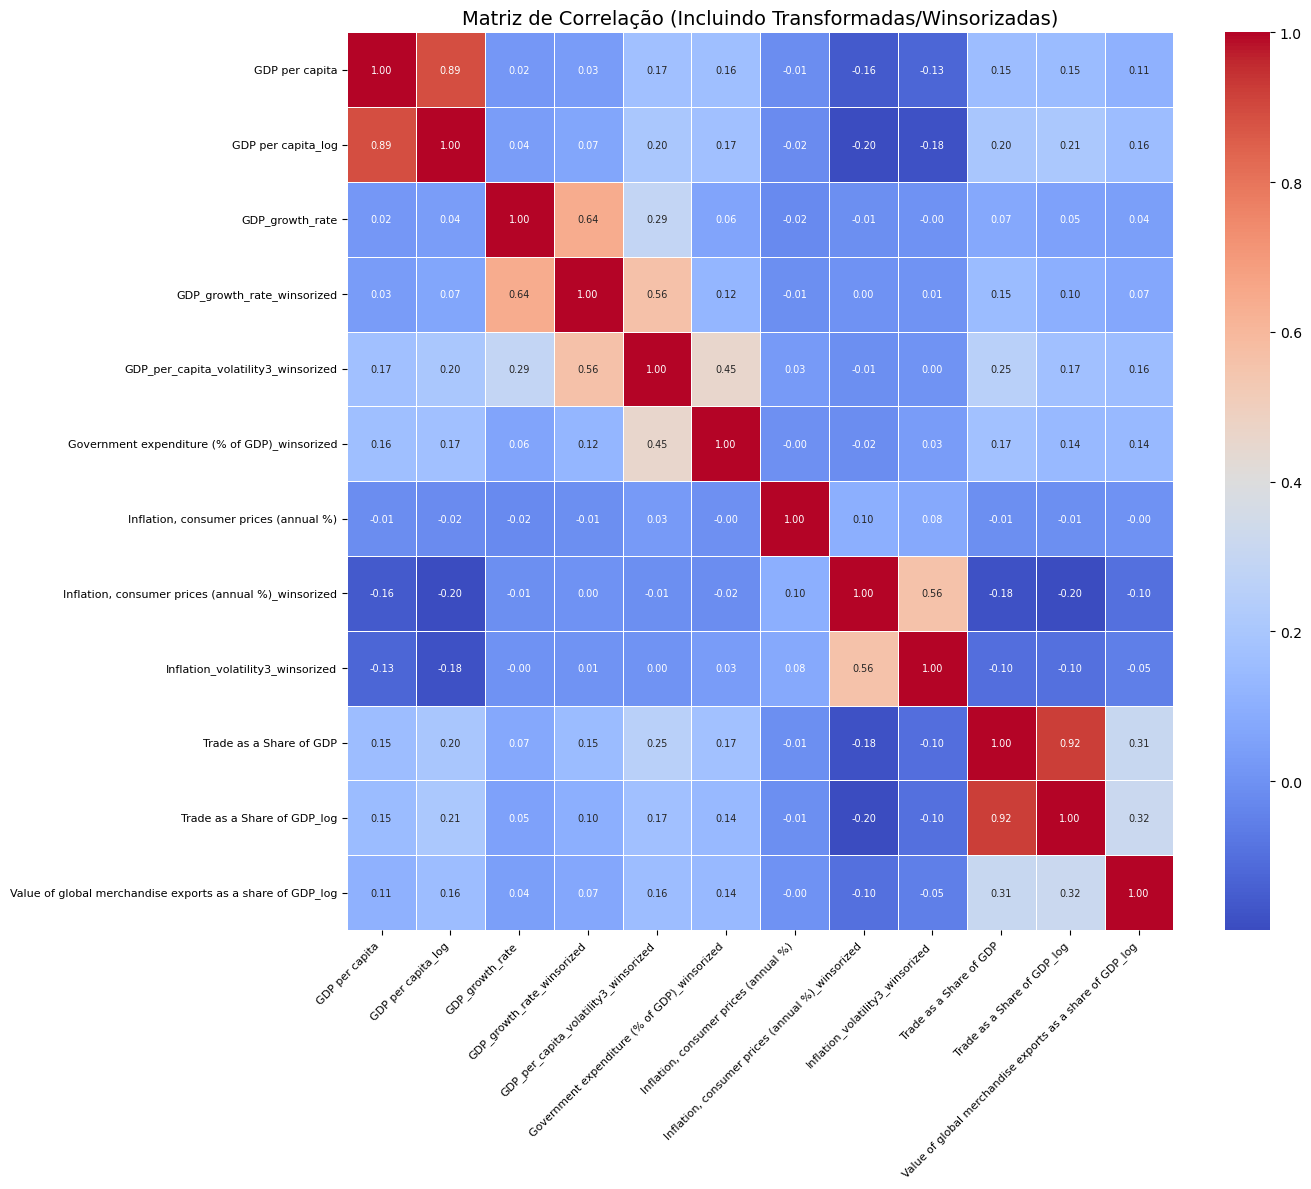

Matriz de Correlação (Com Transformadas):
                                                    GDP per capita  \
GDP per capita                                            1.000000   
GDP per capita_log                                        0.889079   
GDP_growth_rate                                           0.019902   
GDP_growth_rate_winsorized                                0.032115   
GDP_per_capita_volatility3_winsorized                     0.169887   
Government expenditure (% of GDP)_winsorized              0.163767   
Inflation, consumer prices (annual %)                    -0.012955   
Inflation, consumer prices (annual %)_winsorized         -0.157656   
Inflation_volatility3_winsorized                         -0.125903   
Trade as a Share of GDP                                   0.152800   
Trade as a Share of GDP_log                               0.150920   
Value of global merchandise exports as a share ...        0.107434   

                                               

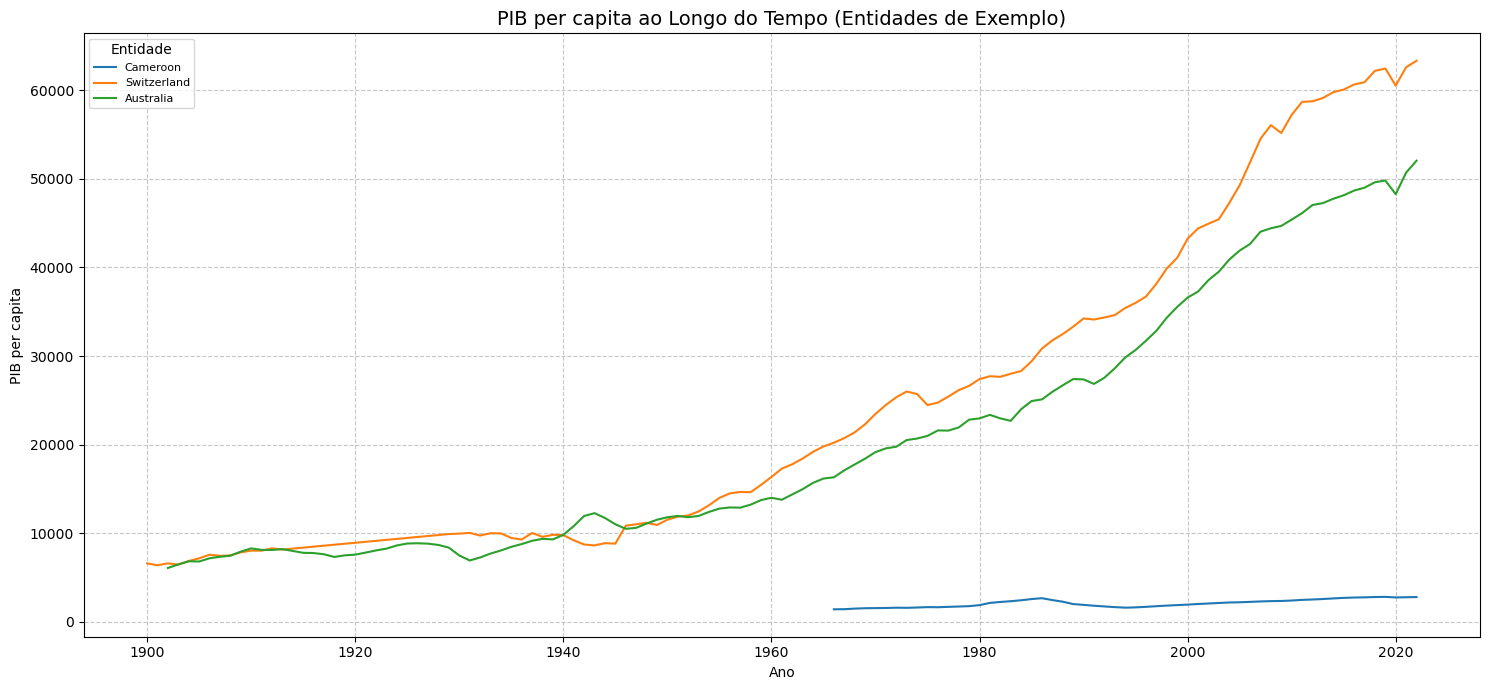


--- 3.5 Investigação Adicional: `GDP_growth_rate` (Original) ---
Número de observações com taxa de crescimento do PIB (original) exatamente zero: 136062
  Dessas 136062 observações, em 136062 o 'GDP per capita' foi igual ao 'GDP_per_capita_lag1'.

--- ANÁLISE EXPLORATÓRIA DE DADOS (Com Tratamento de Outliers/Assimetria) CONCLUÍDA ---


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize # Para Winsorização

# --- ETAPA 0: CARREGAMENTO E PREPARAÇÃO DOS DADOS ---
# Inclui as funções de pré-processamento e engenharia de features dos scripts anteriores
# para tornar este script autocontido.

def preprocess_data(file_path='data/gdp_per_capita.csv'):
    """
    Carrega e pré-processa os dados do PIB per capita,
    com estratégia de imputação aprimorada para 'GDP per capita'.
    """
    try:
        df = pd.read_csv(file_path)
        print("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{file_path}' não foi encontrado. Verifique o caminho.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o ficheiro CSV: {e}")
        return None

    original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
    cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)'
    if original_inflation_col_name in df.columns:
        df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})

    if 'Code' in df.columns:
        df['Code'] = df['Code'].fillna('UNK')

    if 'Entity' in df.columns and 'Year' in df.columns:
        df = df.sort_values(by=['Entity', 'Year'])
    else:
        print("Aviso: Colunas 'Entity' ou 'Year' não encontradas para ordenação pré-interpolação.")

    if 'GDP per capita' in df.columns:
        df['GDP per capita'] = pd.to_numeric(df['GDP per capita'], errors='coerce')
        print("Aplicando interpolação linear para 'GDP per capita' por entidade...")
        df['GDP per capita'] = df.groupby('Entity', group_keys=False)['GDP per capita'].apply(lambda series: series.interpolate(method='linear', limit_direction='both'))
        if df['GDP per capita'].isnull().any():
            print("   NaNs restantes em 'GDP per capita' após interpolação. Aplicando mediana global como fallback.")
            global_median_gdp = df['GDP per capita'].median()
            df['GDP per capita'] = df['GDP per capita'].fillna(global_median_gdp)
            if pd.isna(global_median_gdp):
                 df['GDP per capita'] = df['GDP per capita'].fillna(0)
                 print("   Mediana global do PIB per capita também é NaN. Preenchendo NaNs restantes com 0.")

    other_numerical_cols_to_impute = []
    if 'Value of global merchandise exports as a share of GDP' in df.columns: other_numerical_cols_to_impute.append('Value of global merchandise exports as a share of GDP')
    if 'Government expenditure (% of GDP)' in df.columns: other_numerical_cols_to_impute.append('Government expenditure (% of GDP)')
    if 'Trade as a Share of GDP' in df.columns: other_numerical_cols_to_impute.append('Trade as a Share of GDP')
    if cleaned_inflation_col_name in df.columns: other_numerical_cols_to_impute.append(cleaned_inflation_col_name)

    for col in other_numerical_cols_to_impute:
        if col in df.columns:
            if df[col].isnull().any():
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))
                if df[col].isnull().any():
                    global_median = df[col].median()
                    df[col] = df[col].fillna(global_median)
                    if pd.isna(global_median):
                        df[col] = df[col].fillna(0)
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Aviso (Pré-processamento): Coluna '{col}' não encontrada para imputação por mediana.")

    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    print("--- Pré-processamento Concluído (com imputação aprimorada para PIB per capita) ---")
    return df

def engineer_features(df_processed):
    """
    Realiza a engenharia de features no DataFrame pré-processado.
    """
    if df_processed is None:
        return None

    print("\n--- INÍCIO DA ENGENHARIA DE FEATURES (EDA - Tratamento Outliers/Assimetria) ---")
    df = df_processed.sort_values(by=['Entity', 'Year']).reset_index(drop=True) # Garante ordenação

    # Features Defasadas
    if 'GDP per capita' in df.columns: df['GDP_per_capita_lag1'] = df.groupby('Entity')['GDP per capita'].shift(1)
    inflation_col_name = 'Inflation, consumer prices (annual %)'
    if inflation_col_name in df.columns: df['Inflation_lag1'] = df.groupby('Entity')[inflation_col_name].shift(1)
    if 'Trade as a Share of GDP' in df.columns: df['Trade_as_share_GDP_lag1'] = df.groupby('Entity')['Trade as a Share of GDP'].shift(1)

    # Taxa de Crescimento
    if 'GDP per capita' in df.columns: df['GDP_growth_rate'] = df.groupby('Entity')['GDP per capita'].pct_change() * 100

    # Médias Móveis e Volatilidade
    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_MA3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        df['GDP_per_capita_volatility3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
        df['GDP_per_capita_diff_MA3'] = df['GDP per capita'] - df['GDP_per_capita_MA3']

    if inflation_col_name in df.columns:
        df['Inflation_volatility3'] = df.groupby('Entity')[inflation_col_name].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)

    # Tratamento de NaNs gerados pelas features de lag/crescimento
    cols_critical_for_nan_removal = [col for col in ['GDP_per_capita_lag1', 'Inflation_lag1', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate'] if col in df.columns]

    df_featured = df
    if cols_critical_for_nan_removal:
        df_featured = df.dropna(subset=cols_critical_for_nan_removal).reset_index(drop=True)

    # Preenche NaNs em colunas de volatilidade (gerados por std de 1 ponto) com 0
    volatility_cols_to_fill_zero = [col for col in ['GDP_per_capita_volatility3', 'Inflation_volatility3'] if col in df_featured.columns]
    for vol_col in volatility_cols_to_fill_zero:
        df_featured[vol_col] = df_featured[vol_col].fillna(0)

    print("--- Engenharia de Features (EDA - Tratamento Outliers/Assimetria) Concluída ---")
    return df_featured

# Carrega e prepara os dados
df_prepared = engineer_features(preprocess_data())

if df_prepared is not None and not df_prepared.empty:
    print("\n--- INÍCIO DO TRATAMENTO DE OUTLIERS E ASSIMETRIA ---")
    df_transformed = df_prepared.copy()

    # --- 1. Tratamento de Assimetria (Transformação Logarítmica) ---
    cols_to_log_transform = ['GDP per capita', 'Trade as a Share of GDP', 'Value of global merchandise exports as a share of GDP']
    # Adiciona sufixo '_log' às novas colunas
    for col in cols_to_log_transform:
        if col in df_transformed.columns:
            # Garante que a coluna é numérica e não negativa antes de aplicar log1p
            df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce')
            # np.log1p(x) é log(1+x), bom para dados com zeros e assimétricos à direita.
            # Se houver valores negativos onde não deveriam, eles se tornarão NaN e precisarão de tratamento.
            # Para PIB, Comércio, Exportações, esperamos valores >= 0.
            if (df_transformed[col] < 0).any():
                print(f"Aviso: Coluna '{col}' contém valores negativos. Log1p pode gerar NaNs ou erros.")
                # Opção: Tratar negativos antes (ex: clipar para 0, ou investigar)
                # df_transformed[col] = df_transformed[col].clip(lower=0)

            df_transformed[col + '_log'] = np.log1p(df_transformed[col])
            print(f"Coluna '{col}_log' criada com transformação logarítmica.")
        else:
            print(f"Aviso: Coluna '{col}' não encontrada para transformação logarítmica.")

    # --- 2. Tratamento de Outliers (Winsorização) ---
    # Definir limites para winsorização (ex: 1º e 99º percentil)
    winsor_limits = (0.01, 0.01) # Corta 1% de cada cauda

    cols_to_winsorize = [
        'Inflation, consumer prices (annual %)',
        'GDP_growth_rate', # Ainda pode ter extremos apesar do pico em zero
        'Government expenditure (% of GDP)', # Tinha um máximo extremo
        'GDP_per_capita_volatility3', # Pode ter outliers
        'Inflation_volatility3' # Pode ter outliers
    ]
    # Adiciona sufixo '_winsorized'
    for col in cols_to_winsorize:
        if col in df_transformed.columns and df_transformed[col].notna().any() : # Apenas se a coluna existir e tiver não-NaNs
            original_col_data = df_transformed[col].copy() # Para comparação

            # Winsorize não lida bem com NaNs, então preenchemos temporariamente se houver algum,
            # ou aplicamos apenas nos não-NaNs e depois juntamos.
            # Mais seguro é aplicar em dados não-NaN e depois preencher os NaNs originais de volta se necessário.
            # Para este exemplo, vamos assumir que a maioria dos NaNs críticos já foi tratada.
            # Se a coluna for inteiramente NaN, winsorize pode falhar ou dar resultados estranhos.
            non_nan_data = df_transformed[col].dropna()
            if not non_nan_data.empty:
                winsorized_data = winsorize(non_nan_data, limits=winsor_limits)

                # Cria a nova coluna e preenche com os dados winsorizados, mantendo os índices originais
                df_transformed[col + '_winsorized'] = np.nan # Inicia com NaN
                df_transformed.loc[non_nan_data.index, col + '_winsorized'] = winsorized_data

                # Checagem: Contar quantos valores foram alterados
                # Compara a coluna original (onde não era NaN) com a winsorizada
                # np.isclose é usado para comparações de ponto flutuante
                changed_values = (~np.isclose(original_col_data.loc[non_nan_data.index], df_transformed.loc[non_nan_data.index, col + '_winsorized'])).sum()
                print(f"Coluna '{col}_winsorized' criada. {changed_values} valores foram limitados pela winsorização.")
            else:
                print(f"Aviso: Coluna '{col}' está vazia ou contém apenas NaNs. Winsorização não aplicada.")
        else:
            print(f"Aviso: Coluna '{col}' não encontrada ou totalmente NaN. Winsorização não aplicada.")

    print("--- Tratamento de Outliers e Assimetria Concluído ---")

    # --- 3. ANÁLISE EXPLORATÓRIA DE DADOS (Com Colunas Transformadas) ---
    print("\n--- 3.1 Estatísticas Descritivas (Incluindo Transformadas) ---")
    numeric_cols_all = df_transformed.select_dtypes(include=np.number).columns
    print(df_transformed[numeric_cols_all].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).transpose())

    print("\n--- 3.2 Análise de Distribuição (Comparando Original e Transformada) ---")

    # Comparar GDP per capita original e log
    if 'GDP per capita' in df_transformed.columns and 'GDP per capita_log' in df_transformed.columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df_transformed['GDP per capita'], kde=True, bins=50)
        plt.title('Distribuição de GDP per capita (Original)')
        plt.subplot(1, 2, 2)
        sns.histplot(df_transformed['GDP per capita_log'], kde=True, bins=50)
        plt.title('Distribuição de GDP per capita (Log Transformado)')
        plt.tight_layout(); plt.show()

    # Comparar Inflação original e winsorizada
    inflation_col = 'Inflation, consumer prices (annual %)'
    if inflation_col in df_transformed.columns and inflation_col + '_winsorized' in df_transformed.columns:
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        sns.histplot(df_transformed[inflation_col].dropna(), kde=False, bins=100) # Kde=False para melhor visualização com outliers
        plt.title(f'Distribuição de {inflation_col} (Original)')
        plt.subplot(2, 2, 2)
        sns.histplot(df_transformed[inflation_col + '_winsorized'].dropna(), kde=True, bins=50)
        plt.title(f'Distribuição de {inflation_col} (Winsorizado)')

        plt.subplot(2, 2, 3)
        sns.boxplot(y=df_transformed[inflation_col])
        plt.title(f'Boxplot de {inflation_col} (Original)')
        plt.subplot(2, 2, 4)
        sns.boxplot(y=df_transformed[inflation_col + '_winsorized'])
        plt.title(f'Boxplot de {inflation_col} (Winsorizado)')
        plt.tight_layout(); plt.show()

    # Adicionar mais visualizações comparativas para outras colunas tratadas conforme necessário...

    print("\n--- 3.3 Matriz de Correlação (Com Colunas Transformadas) ---")
    # Adiciona as novas colunas transformadas à lista para correlação
    transformed_correlation_cols = correlation_cols = [
        'GDP per capita_log', 'Trade as a Share of GDP_log',
        'Value of global merchandise exports as a share of GDP_log',
        'Inflation, consumer prices (annual %)_winsorized',
        'GDP_growth_rate_winsorized',
        'Government expenditure (% of GDP)_winsorized',
        'GDP_per_capita_volatility3_winsorized',
        'Inflation_volatility3_winsorized'
    ]
    # Mantém apenas as que existem e adiciona as originais selecionadas anteriormente
    base_correlation_cols = [
        'GDP per capita', 'Inflation, consumer prices (annual %)', 'GDP_growth_rate', 'Trade as a Share of GDP'
    ]
    final_correlation_cols = base_correlation_cols + [col for col in transformed_correlation_cols if col in df_transformed.columns]
    # Remove duplicatas se houver (improvável aqui, mas boa prática)
    final_correlation_cols = sorted(list(set(final_correlation_cols)))

    if final_correlation_cols:
        correlation_matrix_transformed = df_transformed[final_correlation_cols].corr()
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix_transformed, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 7})
        plt.title('Matriz de Correlação (Incluindo Transformadas/Winsorizadas)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout(); plt.show()
        print("Matriz de Correlação (Com Transformadas):")
        print(correlation_matrix_transformed)
    else:
        print("Nenhuma coluna para correlação (incluindo transformadas) foi encontrada.")

    # --- 3.4 Análise de Séries Temporais (Pode usar colunas originais ou transformadas) ---
    # (Mantido como no script anterior, pode-se optar por plotar versões transformadas se desejado)
    print("\n--- 3.4 Análise de Séries Temporais (Exemplos - Dados Base Originais) ---")
    available_entities = df_transformed['Entity'].unique()
    if len(available_entities) > 0:
        entities_sample = list(np.random.choice(available_entities, size=min(3, len(available_entities)), replace=False))
    else:
        entities_sample = []
        print("Nenhuma entidade disponível para amostragem de séries temporais.")

    if entities_sample:
        plt.figure(figsize=(15, 7))
        for entity in entities_sample:
            entity_data = df_transformed[df_transformed['Entity'] == entity]
            if not entity_data.empty:
                 sns.lineplot(x='Year', y='GDP per capita', data=entity_data, label=entity) # Usando original para escala interpretável
        plt.title('PIB per capita ao Longo do Tempo (Entidades de Exemplo)', fontsize=14)
        plt.xlabel('Ano', fontsize=10); plt.ylabel('PIB per capita', fontsize=10)
        plt.legend(title='Entidade', fontsize=8); plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout(); plt.show()

    # --- 3.5 Investigação Adicional: `GDP_growth_rate` (Original) ---
    # (Mantido como no script anterior)
    print("\n--- 3.5 Investigação Adicional: `GDP_growth_rate` (Original) ---")
    if 'GDP_growth_rate' in df_transformed.columns:
        gdp_growth_not_null = df_transformed['GDP_growth_rate'].notnull()
        zero_growth_df = df_transformed[gdp_growth_not_null & (df_transformed['GDP_growth_rate'] == 0)]
        print(f"Número de observações com taxa de crescimento do PIB (original) exatamente zero: {len(zero_growth_df)}")
        if not zero_growth_df.empty and 'GDP per capita' in zero_growth_df.columns and 'GDP_per_capita_lag1' in zero_growth_df.columns:
            check_df = zero_growth_df[['GDP per capita', 'GDP_per_capita_lag1']].dropna()
            if not check_df.empty:
                gdp_constant_check = check_df[check_df['GDP per capita'] == check_df['GDP_per_capita_lag1']]
                print(f"  Dessas {len(zero_growth_df)} observações, em {len(gdp_constant_check)} o 'GDP per capita' foi igual ao 'GDP_per_capita_lag1'.")
    else:
        print("Coluna 'GDP_growth_rate' não disponível para investigação adicional.")

    print("\n--- ANÁLISE EXPLORATÓRIA DE DADOS (Com Tratamento de Outliers/Assimetria) CONCLUÍDA ---")
else:
    print("EDA não pôde ser executada pois a preparação dos dados falhou ou resultou num DataFrame vazio.")

## **Modelo Avançado de Séries Temporais com PyTorch (CPU)**

Usando dispositivo: cpu
--- Dados Originais Carregados com Sucesso (Pré-processamento) ---
Aplicando interpolação linear para 'GDP per capita' por entidade...
--- Pré-processamento Concluído ---

--- INÍCIO DA PREPARAÇÃO DE FEATURES E ALVO ---
Colunas numéricas (pré-lag do alvo) selecionadas para o modelo: ['GDP_per_capita_log_lag1', 'Inflation_winsorized', 'Inflation_lag1_winsorized', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized', 'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year']
Coluna alvo: GDP_per_capita_log
Shape do DataFrame após preparação final (antes de criar lag do alvo pós-split): (147442, 23)
--- Preparação de Features e Alvo Concluída ---

Número de entidades únicas: 173

Dividindo entidades para treino, validação e teste (70/15/15 das entidades)...
Entidades de Treino: 121, Validação: 26, Teste: 26
Linhas (antes de normalização/lag): Treino=110384, Validação=27161, Teste=9897

Normalizando features e alvo (ajus

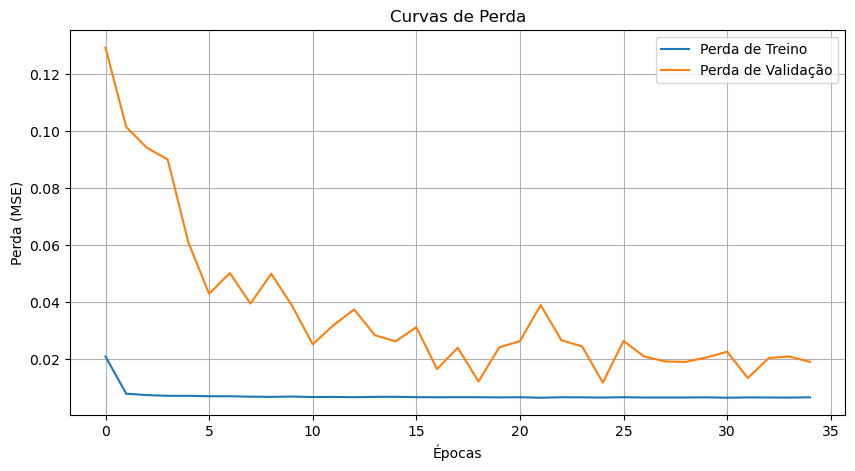


--- AVALIAÇÃO NO CONJUNTO DE TESTE ---
Perda no Conjunto de Teste (MSE na escala normalizada): 0.0094

--- Análise de Disparidade de Erro (MAE por Entidade no Teste - Escala Original do PIB) ---
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar      49600.371094           31
24  United Arab Emirates      13958.155273           18
19             Singapore       6874.791504           51
8      Equatorial Guinea       6028.407227           26
3                Croatia       2446.985352           25
4                 Cyprus       2134.599854           51
23               Ukraine       1677.644653           22
0               Barbados       1127.835205           44
20           South Korea       1125.358154           58
11                 Japan       1041.963867          123
...
        Entity  MAE_PIB_original  Num_Samples
12     Morocco        192.050903           51
14     Myanmar        139.065186           51
1     Cambodia        109.849091           18


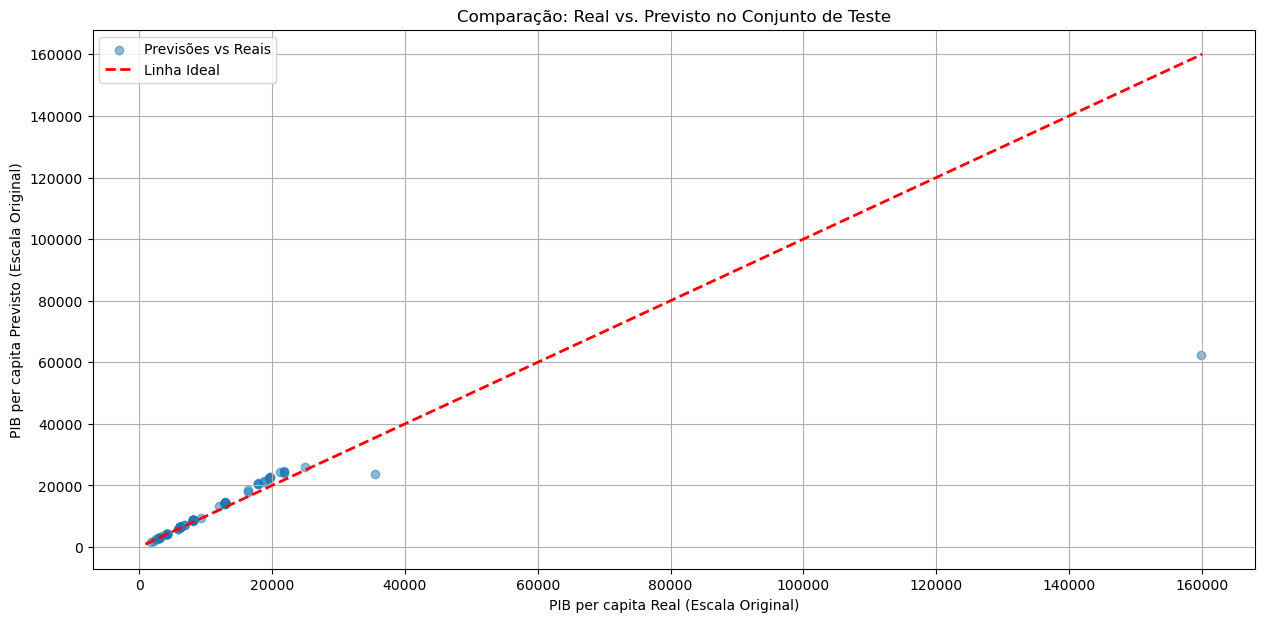

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# train_test_split não será usado para a divisão principal de entidades, mas pode ser útil para outras tarefas
from sklearn.metrics import mean_absolute_error

# --- ETAPA 0: CONFIGURAÇÃO E FUNÇÕES AUXILIARES ---
device = torch.device('cpu')
print(f"Usando dispositivo: {device}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- ETAPA 1: PRÉ-PROCESSAMENTO DE DADOS ---
def preprocess_data(file_path='data/gdp_per_capita.csv'):
    # (Função mantida como na versão anterior)
    try:
        df = pd.read_csv(file_path)
        print("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{file_path}' não foi encontrado. Verifique o caminho.")
        return None

    original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
    cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)'
    if original_inflation_col_name in df.columns:
        df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})

    if 'Code' in df.columns:
        df['Code'] = df['Code'].fillna('UNK')

    if 'Entity' in df.columns and 'Year' in df.columns:
        df = df.sort_values(by=['Entity', 'Year'])

    if 'GDP per capita' in df.columns:
        df['GDP per capita'] = pd.to_numeric(df['GDP per capita'], errors='coerce')
        print("Aplicando interpolação linear para 'GDP per capita' por entidade...")
        df['GDP per capita'] = df.groupby('Entity', group_keys=False)['GDP per capita'].apply(lambda series: series.interpolate(method='linear', limit_direction='both'))
        if df['GDP per capita'].isnull().any():
            print("   NaNs restantes em 'GDP per capita' após interpolação. Aplicando mediana global como fallback.")
            global_median_gdp = df['GDP per capita'].median()
            df['GDP per capita'] = df['GDP per capita'].fillna(global_median_gdp if not pd.isna(global_median_gdp) else 0)

    other_numerical_cols_to_impute = [
        'Value of global merchandise exports as a share of GDP',
        'Government expenditure (% of GDP)',
        'Trade as a Share of GDP',
        cleaned_inflation_col_name
    ]
    for col in other_numerical_cols_to_impute:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))
            if df[col].isnull().any():
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median if not pd.isna(global_median) else 0)

    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    print("--- Pré-processamento Concluído ---")
    return df

# --- ETAPA 2: ENGENHARIA DE FEATURES E TRATAMENTO ---
def prepare_features_and_target(df_processed):
    # (Função mantida, mas entity_sequence_counts foi removido daqui, será calculado depois)
    if df_processed is None: return None, None, None
    print("\n--- INÍCIO DA PREPARAÇÃO DE FEATURES E ALVO ---")
    df = df_processed.sort_values(by=['Entity', 'Year']).reset_index(drop=True)
    inflation_col_name = 'Inflation, consumer prices (annual %)'

    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_lag1'] = df.groupby('Entity')['GDP per capita'].shift(1)
    if inflation_col_name in df.columns:
        df['Inflation_lag1'] = df.groupby('Entity')[inflation_col_name].shift(1)
    else: df['Inflation_lag1'] = np.nan
    if 'Trade as a Share of GDP' in df.columns:
        df['Trade_as_share_GDP_lag1'] = df.groupby('Entity')['Trade as a Share of GDP'].shift(1)
    else: df['Trade_as_share_GDP_lag1'] = np.nan
    if 'GDP per capita' in df.columns:
        df['GDP_growth_rate'] = df.groupby('Entity')['GDP per capita'].pct_change() * 100
    else: df['GDP_growth_rate'] = np.nan
    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_MA3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        df['GDP_per_capita_volatility3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
        df['GDP_per_capita_diff_MA3'] = df['GDP per capita'] - df['GDP_per_capita_MA3']
    else:
        df['GDP_per_capita_MA3'] = np.nan; df['GDP_per_capita_volatility3'] = np.nan; df['GDP_per_capita_diff_MA3'] = np.nan
    if inflation_col_name in df.columns:
        df['Inflation_volatility3'] = df.groupby('Entity')[inflation_col_name].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
    else: df['Inflation_volatility3'] = np.nan

    critical_lag_cols = [col for col in ['GDP_per_capita_lag1', 'Inflation_lag1', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate'] if col in df.columns]
    if critical_lag_cols:
        df = df.dropna(subset=critical_lag_cols).reset_index(drop=True)

    volatility_cols = [col for col in ['GDP_per_capita_volatility3', 'Inflation_volatility3'] if col in df.columns]
    for vol_col in volatility_cols: df[vol_col] = df[vol_col].fillna(0)

    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_log'] = np.log1p(df['GDP per capita'].clip(lower=0))
    else: df['GDP_per_capita_log'] = np.nan

    winsor_limits = (0.01, 0.01)
    cols_to_winsorize_map = {
        inflation_col_name: 'Inflation_winsorized', 'GDP_growth_rate': 'GDP_growth_rate_winsorized',
        'Government expenditure (% of GDP)': 'Gov_expenditure_winsorized',
        'GDP_per_capita_volatility3': 'GDP_volatility_winsorized',
        'Inflation_volatility3': 'Inflation_volatility_winsorized', 'Inflation_lag1': 'Inflation_lag1_winsorized'
    }
    for original_col, new_col_name in cols_to_winsorize_map.items():
        if original_col in df.columns and df[original_col].notna().any():
            non_nan_data = df[original_col].dropna()
            if not non_nan_data.empty:
                winsorized_data = winsorize(non_nan_data, limits=winsor_limits)
                df[new_col_name] = np.nan
                df.loc[non_nan_data.index, new_col_name] = winsorized_data
                median_val = df[new_col_name].median()
                df[new_col_name] = df[new_col_name].fillna(median_val if not pd.isna(median_val) else 0)
            else: df[new_col_name] = 0
        elif original_col not in df.columns: df[new_col_name] = 0
        else: df[new_col_name] = 0

    target_col = 'GDP_per_capita_log'
    # O lag do alvo será criado DEPOIS da normalização e divisão
    # df['GDP_per_capita_log_lag1'] = df.groupby('Entity')[target_col].shift(1)

    numerical_features = [ # GDP_per_capita_log_lag1 será adicionada depois da normalização
        'Inflation_winsorized', 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized',
        'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year'
    ]
    # Adiciona GDP_per_capita_log_lag1 no início se for existir após o shift
    numerical_features = ['GDP_per_capita_log_lag1'] + [f for f in numerical_features if f in df.columns]

    # Drop NaNs de colunas de features (exceto o lag do alvo que será tratado por split) e do alvo
    # É crucial que o target_col não tenha NaNs para o scaler e para o treinamento
    # O lag do alvo será criado e seus NaNs tratados após a normalização e divisão.
    cols_for_initial_dropna = [target_col] + [f for f in numerical_features if f != 'GDP_per_capita_log_lag1']
    cols_for_initial_dropna = [c for c in cols_for_initial_dropna if c in df.columns]
    if cols_for_initial_dropna:
        df = df.dropna(subset=cols_for_initial_dropna).reset_index(drop=True)

    if target_col not in df.columns or df[target_col].isnull().all():
        print(f"ERRO: Coluna alvo '{target_col}' está ausente ou toda NaN.")
        return None, [], ""

    print(f"Colunas numéricas (pré-lag do alvo) selecionadas para o modelo: {numerical_features}")
    print(f"Coluna alvo: {target_col}")
    print(f"Shape do DataFrame após preparação final (antes de criar lag do alvo pós-split): {df.shape}")
    print("--- Preparação de Features e Alvo Concluída ---")
    return df, numerical_features, target_col

# --- ETAPA 3, 4, 5 (Dataset, Modelo, Treino, Avaliação) ---
# (Mantidas como na versão anterior, incluindo o carregamento seguro do modelo)
class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, y_data, entity_data):
        self.X_data = X_data; self.y_data = y_data; self.entity_data = entity_data
    def __len__(self): return len(self.X_data)
    def __getitem__(self, idx):
        return (torch.tensor(self.X_data[idx], dtype=torch.float32),
                torch.tensor(self.y_data[idx], dtype=torch.float32),
                torch.tensor(self.entity_data[idx], dtype=torch.long))

def create_sequences_from_df(df, numerical_features, target_col, entity_col_encoded, sequence_length):
    X_seq, y_seq, entity_seq_codes = [], [], []
    unique_entities = df[entity_col_encoded].unique()
    for entity_code in unique_entities:
        entity_df = df[df[entity_col_encoded] == entity_code].copy()
        # As features e o alvo já devem ser numéricos e sem NaNs neste ponto devido ao pré-processamento e dropna
        X_entity_features = entity_df[numerical_features].values
        y_entity_target = entity_df[target_col].values
        if len(entity_df) >= sequence_length + 1:
            for i in range(len(entity_df) - sequence_length):
                X_seq.append(X_entity_features[i : i + sequence_length])
                y_seq.append(y_entity_target[i + sequence_length])
                entity_seq_codes.append(entity_code)
    if not X_seq: return np.array([]), np.array([]).reshape(-1,1), np.array([])
    return np.array(X_seq), np.array(y_seq).reshape(-1, 1), np.array(entity_seq_codes)

class LSTMForecastModel(nn.Module):
    def __init__(self, num_numerical_features, num_entities, embedding_dim, hidden_units, num_layers, dropout_prob=0.2):
        super(LSTMForecastModel, self).__init__()
        self.entity_embedding = nn.Embedding(num_embeddings=num_entities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM( input_size=num_numerical_features + embedding_dim, hidden_size=hidden_units,
                             num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(in_features=hidden_units, out_features=1)
    def forward(self, x_numerical, x_entity_code_for_seq):
        entity_embeddings_batch = self.entity_embedding(x_entity_code_for_seq)
        seq_len = x_numerical.size(1)
        entity_embeddings_repeated = entity_embeddings_batch.unsqueeze(1).repeat(1, seq_len, 1)
        combined_features = torch.cat((x_numerical, entity_embeddings_repeated), dim=2)
        lstm_out, _ = self.lstm(combined_features)
        last_time_step_out = lstm_out[:, -1, :]
        dropped_out = self.dropout(last_time_step_out)
        y_pred = self.linear(dropped_out)
        return y_pred

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        if len(train_loader.dataset) == 0:
            epoch_train_loss = float('nan')
        else:
            for X_batch_num, y_batch, X_batch_entity in train_loader:
                X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                optimizer.zero_grad(); y_pred = model(X_batch_num, X_batch_entity)
                loss = criterion(y_pred, y_batch); loss.backward(); optimizer.step()
                running_train_loss += loss.item() * X_batch_num.size(0)
            epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval(); running_val_loss = 0.0
        if val_loader and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for X_batch_num, y_batch, X_batch_entity in val_loader:
                    X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                    y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
                    running_val_loss += loss.item() * X_batch_num.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
        else: epoch_val_loss = float('nan')
        val_losses.append(epoch_val_loss)
        print(f"Época {epoch+1}/{num_epochs} - Perda Treino: {epoch_train_loss:.4f} - Perda Validação: {epoch_val_loss:.4f}")
        if not pd.isna(epoch_val_loss) and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; torch.save(model.state_dict(), 'models/best_lstm_model.pth'); epochs_no_improve = 0
            print(f"  Melhor modelo salvo com perda de validação: {best_val_loss:.4f}")
        elif not pd.isna(epoch_val_loss):
            epochs_no_improve += 1
            if epochs_no_improve >= patience: print(f"  Parada antecipada! Sem melhoria por {patience} épocas."); break
        elif pd.isna(epoch_val_loss) and epoch_train_loss < 0.0001 and epoch > 0 :
             print(f"  Parada: Validação NaN e treino ({epoch_train_loss:.4f}) baixo."); break
    try:
        model.load_state_dict(torch.load('models/best_lstm_model.pth', map_location=device, weights_only=True))
        print("Melhor modelo carregado com weights_only=True.")
    except Exception as e: print(f"Aviso: Não foi possível carregar 'best_lstm_model.pth' ({e}).")
    return model, train_losses, val_losses

def evaluate_model(model, test_loader, criterion, device, target_scaler=None, entity_encoder=None):
    model.eval()
    test_loss = 0.0
    all_y_true_scaled, all_y_pred_scaled, all_entities_encoded = [], [], []
    if test_loader is None or len(test_loader.dataset) == 0 :
        print("Aviso: Conjunto de teste vazio ou loader não fornecido.")
        return np.array([]), np.array([]), float('nan'), pd.DataFrame()
    with torch.no_grad():
        for X_batch_num, y_batch, X_batch_entity in test_loader:
            X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
            y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch_num.size(0)
            all_y_true_scaled.extend(y_batch.cpu().numpy())
            all_y_pred_scaled.extend(y_pred.cpu().numpy())
            all_entities_encoded.extend(X_batch_entity.cpu().numpy())
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"Perda no Conjunto de Teste (MSE na escala normalizada): {avg_test_loss:.4f}")
    results_df = pd.DataFrame({'Entity_Encoded': all_entities_encoded,
                               'y_true_scaled': np.array(all_y_true_scaled).flatten(),
                               'y_pred_scaled': np.array(all_y_pred_scaled).flatten()})
    mae_per_entity_df = pd.DataFrame()
    if target_scaler is not None and entity_encoder is not None and not results_df.empty:
        results_df['y_true_log_original'] = target_scaler.inverse_transform(results_df[['y_true_scaled']])
        results_df['y_pred_log_original'] = target_scaler.inverse_transform(results_df[['y_pred_scaled']])
        results_df['y_true_actual_pib'] = np.expm1(results_df['y_true_log_original'])
        results_df['y_pred_actual_pib'] = np.expm1(results_df['y_pred_log_original'])
        results_df['Entity'] = entity_encoder.inverse_transform(results_df['Entity_Encoded'])
        mae_per_entity_list = [{'Entity': entity_name,
                                'MAE_PIB_original': mean_absolute_error(group['y_true_actual_pib'], group['y_pred_actual_pib']),
                                'Num_Samples': len(group)}
                               for entity_name, group in results_df.groupby('Entity')]
        if mae_per_entity_list:
            mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original', ascending=False)
            print("\n--- Análise de Disparidade de Erro (MAE por Entidade no Teste - Escala Original do PIB) ---")
            print(mae_per_entity_df.head(10)); print("..."); print(mae_per_entity_df.tail(5))
    return np.array(all_y_true_scaled), np.array(all_y_pred_scaled), avg_test_loss, mae_per_entity_df

# --- ETAPA 6: ORQUESTRAÇÃO ---
if __name__ == '__main__':
    SEQUENCE_LENGTH = 10
    df_raw = preprocess_data()
    if df_raw is not None:
        df_full_featured, numerical_feature_cols, target_col = prepare_features_and_target(df_raw)

        if df_full_featured is not None and not df_full_featured.empty and \
           target_col in df_full_featured and not df_full_featured[target_col].isnull().all():

            entity_encoder = LabelEncoder()
            df_full_featured['Entity_Encoded'] = entity_encoder.fit_transform(df_full_featured['Entity'])
            num_unique_entities = df_full_featured['Entity_Encoded'].nunique()
            print(f"\nNúmero de entidades únicas: {num_unique_entities}")

            # --- Divisão de Dados por Entidade (Estratégia Mais Simples e Direta) ---
            print("\nDividindo entidades para treino, validação e teste (70/15/15 das entidades)...")
            all_entity_codes = df_full_featured['Entity_Encoded'].unique()
            np.random.shuffle(all_entity_codes) # Embaralha para aleatoriedade

            train_codes, test_val_codes = train_test_split(all_entity_codes, test_size=0.30, random_state=SEED) # 70% treino
            val_codes, test_codes = train_test_split(test_val_codes, test_size=0.50, random_state=SEED) # Divide os 30% restantes em 15% val, 15% teste

            print(f"Entidades de Treino: {len(train_codes)}, Validação: {len(val_codes)}, Teste: {len(test_codes)}")

            df_train = df_full_featured[df_full_featured['Entity_Encoded'].isin(train_codes)].copy()
            df_val = df_full_featured[df_full_featured['Entity_Encoded'].isin(val_codes)].copy()
            df_test = df_full_featured[df_full_featured['Entity_Encoded'].isin(test_codes)].copy()

            print(f"Linhas (antes de normalização/lag): Treino={len(df_train)}, Validação={len(df_val)}, Teste={len(df_test)}")

            # --- Normalização (APÓS a divisão por entidade, AJUSTAR no treino, APLICAR em todos) ---
            print("\nNormalizando features e alvo (ajustado no treino)...")
            scalers = {}

            # Normalizar features numéricas
            for col in numerical_feature_cols:
                if col == 'GDP_per_capita_log_lag1': continue # O lag do alvo será tratado depois
                if col in df_train and not df_train[col].isnull().all():
                    scaler = StandardScaler(); df_train[col] = scaler.fit_transform(df_train[[col]])
                    scalers[col] = scaler
                    if col in df_val and not df_val[col].isnull().all(): df_val[col] = scaler.transform(df_val[[col]])
                    else: df_val[col] = df_val[col].fillna(0) if col in df_val else 0
                    if col in df_test and not df_test[col].isnull().all(): df_test[col] = scaler.transform(df_test[[col]])
                    else: df_test[col] = df_test[col].fillna(0) if col in df_test else 0
                else:
                    print(f"Aviso: Coluna '{col}' ausente/NaN no treino. Preenchendo com 0.")
                    for df_s in [df_train, df_val, df_test]:
                        if col in df_s: df_s[col] = df_s[col].fillna(0)
                        else: df_s[col] = 0

            # Normalizar coluna alvo
            target_scaler = StandardScaler()
            if not df_train[target_col].isnull().all():
                df_train[target_col] = target_scaler.fit_transform(df_train[[target_col]]); scalers[target_col] = target_scaler
                if target_col in df_val and not df_val[target_col].isnull().all(): df_val[target_col] = target_scaler.transform(df_val[[target_col]])
                elif target_col in df_val: df_val[target_col] = df_val[target_col].fillna(0)
                if target_col in df_test and not df_test[target_col].isnull().all(): df_test[target_col] = target_scaler.transform(df_test[[target_col]])
                elif target_col in df_test: df_test[target_col] = df_test[target_col].fillna(0)
            else:
                print(f"Aviso: Coluna alvo '{target_col}' toda NaN no treino."); df_train[target_col] = df_train[target_col].fillna(0)
                if target_col in df_val: df_val[target_col] = df_val[target_col].fillna(0)
                if target_col in df_test: df_test[target_col] = df_test[target_col].fillna(0)

            # Criar e normalizar GDP_per_capita_log_lag1 para cada split
            for split_df_name, df_split in [("Treino", df_train), ("Validação", df_val), ("Teste", df_test)]:
                if target_col in df_split and 'Entity_Encoded' in df_split:
                    # Cria o lag a partir do target_col JÁ NORMALIZADO do split
                    df_split['GDP_per_capita_log_lag1'] = df_split.groupby('Entity_Encoded', group_keys=False)[target_col].shift(1)
                    # Remove NaNs criados pelo shift
                    df_split.dropna(subset=['GDP_per_capita_log_lag1'], inplace=True)
                print(f"Shape {split_df_name} após normalização e criação final do lag: {df_split.shape}")

            X_train, y_train, entity_train = create_sequences_from_df(df_train, numerical_feature_cols, target_col, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_val, y_val, entity_val = create_sequences_from_df(df_val, numerical_feature_cols, target_col, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_test, y_test, entity_test = create_sequences_from_df(df_test, numerical_feature_cols, target_col, 'Entity_Encoded', SEQUENCE_LENGTH)

            print(f"\nTamanhos FINAIS dos conjuntos de sequências: Treino={len(X_train)}, Validação={len(X_val)}, Teste={len(X_test)}")

            if len(X_train) == 0 or (len(val_codes) > 0 and len(X_val) == 0) :
                print("ERRO CRÍTICO: Conjunto de treino ou validação vazio após criação de sequências. Verifique a lógica.")
            else:
                train_dataset = TimeSeriesDataset(X_train, y_train, entity_train)
                val_dataset = TimeSeriesDataset(X_val, y_val, entity_val) if len(X_val) > 0 else None
                test_dataset = TimeSeriesDataset(X_test, y_test, entity_test) if len(X_test) > 0 else None

                BATCH_SIZE = 64
                train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) if val_dataset else None
                test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) if test_dataset else None
                effective_val_loader = val_loader if val_loader and len(val_loader.dataset) > 0 else None
                if not effective_val_loader: print("Aviso: Validação será pulada ou usará dados de treino se val_loader for None.")

                NUM_NUMERICAL_FEATURES = X_train.shape[2] if X_train.ndim == 3 and X_train.shape[0] > 0 and X_train.shape[2] > 0 else 0
                if NUM_NUMERICAL_FEATURES == 0 and len(X_train)>0 :
                    print("ERRO: Nenhuma feature numérica para o modelo.")
                elif len(X_train)==0: print("ERRO: Treino sem sequências.")
                else:
                    EMBEDDING_DIM = min(30, num_unique_entities // 2 if num_unique_entities > 5 else 5)
                    HIDDEN_UNITS = 64
                    NUM_LAYERS = 2
                    LEARNING_RATE = 0.001
                    NUM_EPOCHS = 75
                    PATIENCE_EARLY_STOPPING = 10
                    DROPOUT_PROB = 0.25

                    model = LSTMForecastModel( NUM_NUMERICAL_FEATURES, num_unique_entities, EMBEDDING_DIM,
                                               HIDDEN_UNITS, NUM_LAYERS, DROPOUT_PROB).to(device)
                    criterion = nn.MSELoss(); optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

                    print("\n--- INÍCIO DO TREINAMENTO DO MODELO ---")
                    trained_model, train_losses, val_losses = train_model(
                        model, train_loader, effective_val_loader if effective_val_loader else train_loader,
                        criterion, optimizer, NUM_EPOCHS, device, PATIENCE_EARLY_STOPPING
                    )

                    if train_losses :
                        plt.figure(figsize=(10, 5)); plt.plot(train_losses, label='Perda de Treino')
                        if val_losses and not all(pd.isna(val_losses)): plt.plot(val_losses, label='Perda de Validação')
                        plt.title('Curvas de Perda'); plt.xlabel('Épocas'); plt.ylabel('Perda (MSE)')
                        plt.legend(); plt.grid(True); plt.show()

                    if test_loader and len(test_loader.dataset) > 0:
                        print("\n--- AVALIAÇÃO NO CONJUNTO DE TESTE ---")
                        y_true_test, y_pred_test, test_mse, mae_per_entity_df = evaluate_model(
                            trained_model, test_loader, criterion, device,
                            target_scaler=scalers.get(target_col), entity_encoder=entity_encoder
                        )
                        if len(y_true_test) > 0 and target_col in scalers and hasattr(scalers[target_col], 'inverse_transform'):
                            target_scaler_loaded = scalers[target_col]
                            y_true_test_original_scale = target_scaler_loaded.inverse_transform(y_true_test)
                            y_pred_test_original_scale = target_scaler_loaded.inverse_transform(y_pred_test)
                            mse_original_scale = np.mean((y_true_test_original_scale - y_pred_test_original_scale)**2)
                            print(f"MSE no Conjunto de Teste (Escala Original do Log-PIB): {mse_original_scale:.4f}")
                            y_true_actual_pib = np.expm1(y_true_test_original_scale); y_pred_actual_pib = np.expm1(y_pred_test_original_scale)
                            mse_actual_pib_scale = np.mean((y_true_actual_pib - y_pred_actual_pib)**2)
                            mae_actual_pib_scale = np.mean(np.abs(y_true_actual_pib - y_pred_actual_pib))
                            print(f"MSE no Conjunto de Teste (Escala Original do PIB per capita): {mse_actual_pib_scale:.2f}")
                            print(f"MAE no Conjunto de Teste (Escala Original do PIB per capita): {mae_actual_pib_scale:.2f}")
                            plt.figure(figsize=(15, 7))
                            sample_indices = np.random.choice(len(y_true_actual_pib), size=min(100, len(y_true_actual_pib)), replace=False)
                            plt.scatter(y_true_actual_pib[sample_indices], y_pred_actual_pib[sample_indices], alpha=0.5, label='Previsões vs Reais')
                            min_val = 0; max_val = 1
                            if len(y_true_actual_pib) > 0 and len(y_pred_actual_pib) > 0:
                                min_val = min(y_true_actual_pib.min(), y_pred_actual_pib.min())
                                max_val = max(y_true_actual_pib.max(), y_pred_actual_pib.max())
                            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal')
                            plt.xlabel('PIB per capita Real (Escala Original)'); plt.ylabel('PIB per capita Previsto (Escala Original)')
                            plt.title('Comparação: Real vs. Previsto no Conjunto de Teste'); plt.legend(); plt.grid(True); plt.show()
                        else: print("Não foi possível avaliar na escala original.")
                    else: print("Avaliação no teste não realizada.")
        else: print("DataFrame de features vazio ou alvo ausente. Modelagem não pode prosseguir.")
else: print("Pré-processamento inicial falhou. Modelagem não pode prosseguir.")

## **Comparativo: LSTM (PyTorch) vs. Modelos ML Tradicionais**

Usando dispositivo: cpu
--- Dados Originais Carregados com Sucesso (Pré-processamento) ---
Aplicando interpolação linear para 'GDP per capita' por entidade...
--- Pré-processamento Concluído ---

--- INÍCIO DA ENGENHARIA DE FEATURES INICIAL ---
Colunas base LSTM (antes de lag/interação pós-split): ['Inflation_winsorized', 'Inflation_lag1_winsorized', 'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized', 'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year_sin', 'Year_cos']
Colunas ML: ['GDP_per_capita_lag1_orig_winsorized', 'Inflation_winsorized', 'Inflation_lag1_winsorized', 'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized', 'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year', 'Value of global merchandise exports as a share of GDP', 'Trade as a Share of GDP']
Alvo (Log): GDP_per_capita_log
Shape df_cleaned (base para LSTM): (147442, 26), Shape df_for_ml: (1474

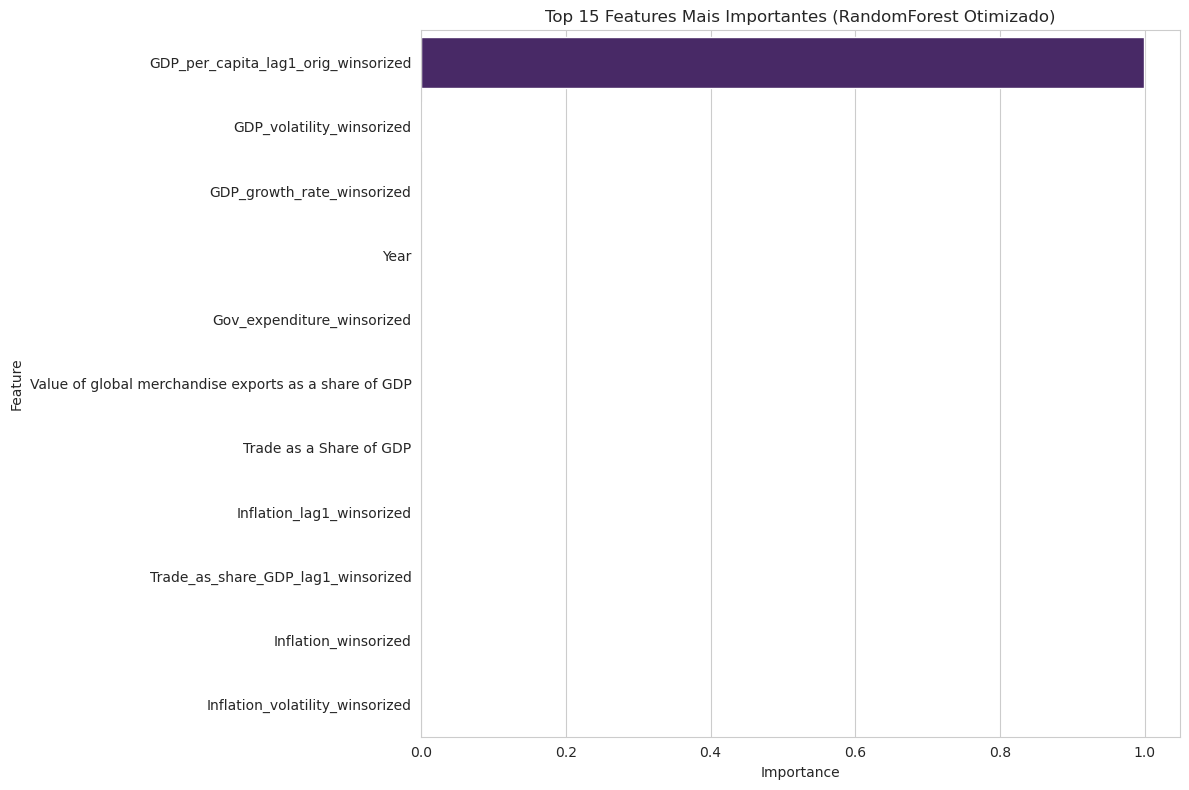


--- TREINAMENTO E AVALIAÇÃO GRADIENT BOOSTING (parâmetros padrão) ---
GradientBoosting - MAE Teste (Escala PIB Original): 269.72, MSE Teste: 12802629.77

--- GradientBoosting: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar      34809.988696           42
24  United Arab Emirates       7412.863457           29
19             Singapore       2917.625327           62
8      Equatorial Guinea       1492.447894           37
4                 Cyprus        356.060269           62
...
             Entity  MAE_PIB_original  Num_Samples
7       El Salvador         68.113014           62
5   East Asia (MPD)         65.367395         8377
25         Zimbabwe         61.178905           47
1          Cambodia         41.138893           29
12          Morocco         41.117203           62

Tamanhos FINAIS dos conjuntos de sequências (LSTM): Treino=109053, Validação=26875, Teste=9611

--- INÍCIO DA OTI

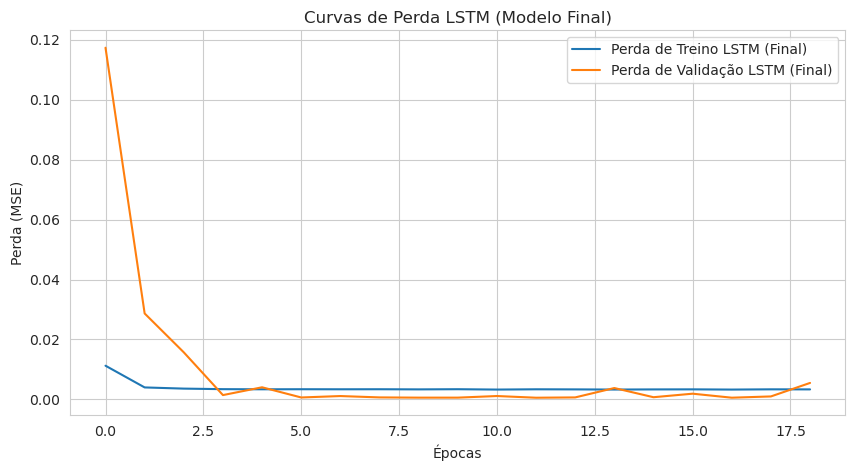


--- AVALIAÇÃO LSTM FINAL NO CONJUNTO DE TESTE ---
LSTM - Perda no Teste (MSE na escala normalizada): 0.0011
LSTM - MSE no Teste (Escala Original do PIB per capita): 1088706.25
LSTM - MAE no Teste (Escala Original do PIB per capita): 182.82

--- LSTM: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar      11120.441406           31
8      Equatorial Guinea       5170.177246           26
24  United Arab Emirates       3395.215820           18
4                 Cyprus       1884.879639           51
3                Croatia       1551.520020           25
...
             Entity  MAE_PIB_original  Num_Samples
14          Myanmar        109.378159           51
25         Zimbabwe        100.379883           36
1          Cambodia         66.022720           18
5   East Asia (MPD)         56.014793         8366
13       Mozambique         42.506844           31

--- Comparação de Métricas dos Modelos

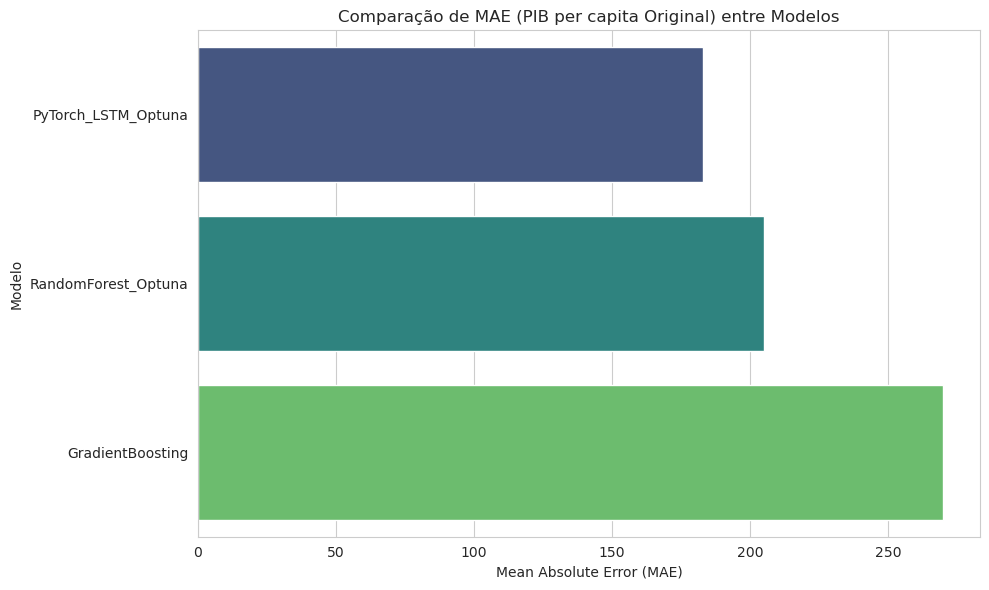

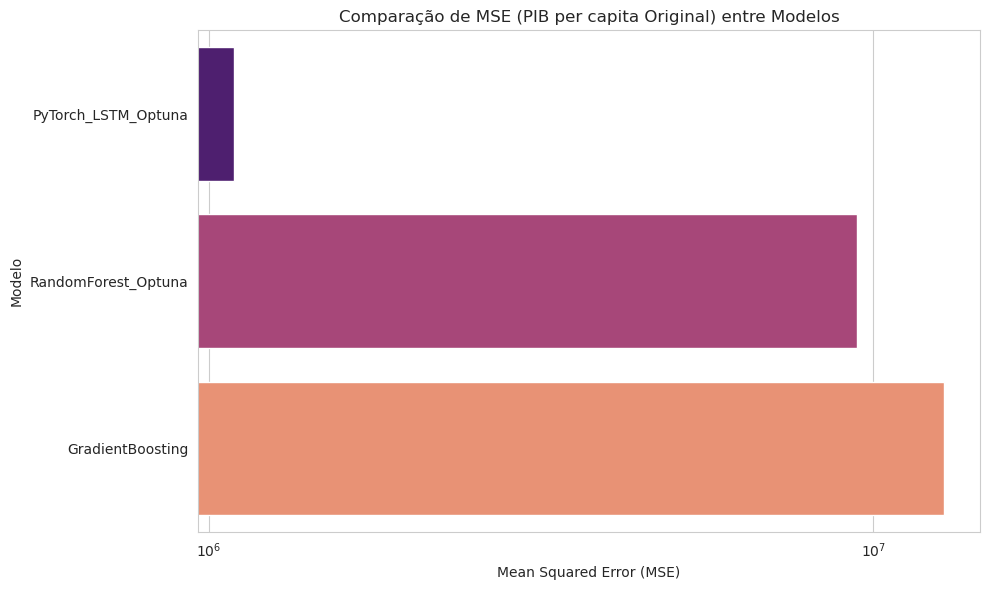

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- ETAPA 0: CONFIGURAÇÃO E FUNÇÕES AUXILIARES ---
device = torch.device('cpu')
print(f"Usando dispositivo: {device}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- ETAPA 1: PRÉ-PROCESSAMENTO DE DADOS ---
def preprocess_data(file_path='data/gdp_per_capita.csv'):
    try:
        df = pd.read_csv(file_path)
        print("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{file_path}' não foi encontrado. Verifique o caminho e a estrutura de pastas.")
        return None

    original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
    cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)'
    if original_inflation_col_name in df.columns:
        df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})

    if 'Code' in df.columns: df['Code'] = df['Code'].fillna('UNK')
    if 'Entity' in df.columns and 'Year' in df.columns: df = df.sort_values(by=['Entity', 'Year'])

    if 'GDP per capita' in df.columns:
        df['GDP per capita'] = pd.to_numeric(df['GDP per capita'], errors='coerce')
        print("Aplicando interpolação linear para 'GDP per capita' por entidade...")
        df['GDP per capita'] = df.groupby('Entity', group_keys=False)['GDP per capita'].apply(lambda series: series.interpolate(method='linear', limit_direction='both'))
        if df['GDP per capita'].isnull().any():
            global_median_gdp = df['GDP per capita'].median()
            df['GDP per capita'] = df['GDP per capita'].fillna(global_median_gdp if not pd.isna(global_median_gdp) else 0)

    other_numerical_cols_to_impute = [
        'Value of global merchandise exports as a share of GDP',
        'Government expenditure (% of GDP)', 'Trade as a Share of GDP', cleaned_inflation_col_name
    ]
    for col in other_numerical_cols_to_impute:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))
            if df[col].isnull().any():
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median if not pd.isna(global_median) else 0)

    if 'Year' in df.columns: df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    print("--- Pré-processamento Concluído ---")
    return df

# --- ETAPA 2: ENGENHARIA DE FEATURES E TRATAMENTO (ANTES DA DIVISÃO DE DADOS) ---
def initial_feature_engineering(df_processed):
    if df_processed is None: return None, None, None, None, None
    print("\n--- INÍCIO DA ENGENHARIA DE FEATURES INICIAL ---")
    df = df_processed.sort_values(by=['Entity', 'Year']).reset_index(drop=True)
    inflation_col_name = 'Inflation, consumer prices (annual %)'

    if 'GDP per capita' in df.columns: df['GDP_per_capita_lag1_orig'] = df.groupby('Entity')['GDP per capita'].shift(1)
    if inflation_col_name in df.columns: df['Inflation_lag1'] = df.groupby('Entity')[inflation_col_name].shift(1)
    else: df['Inflation_lag1'] = np.nan
    if 'Trade as a Share of GDP' in df.columns: df['Trade_as_share_GDP_lag1'] = df.groupby('Entity')['Trade as a Share of GDP'].shift(1)
    else: df['Trade_as_share_GDP_lag1'] = np.nan

    if 'GDP per capita' in df.columns:
        df['GDP_growth_rate'] = df.groupby('Entity')['GDP per capita'].pct_change() * 100
        df['GDP_per_capita_MA3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        df['GDP_per_capita_volatility3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
    else:
        df['GDP_growth_rate'] = np.nan; df['GDP_per_capita_MA3'] = np.nan; df['GDP_per_capita_volatility3'] = np.nan

    if inflation_col_name in df.columns:
        df['Inflation_volatility3'] = df.groupby('Entity')[inflation_col_name].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
    else: df['Inflation_volatility3'] = np.nan

    critical_lag_cols_initial = [col for col in ['GDP_per_capita_lag1_orig', 'Inflation_lag1', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate'] if col in df.columns]
    if critical_lag_cols_initial:
        df = df.dropna(subset=critical_lag_cols_initial).reset_index(drop=True)

    for vol_col in [col for col in ['GDP_per_capita_volatility3', 'Inflation_volatility3'] if col in df.columns]:
        df[vol_col] = df[vol_col].fillna(0)

    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_log'] = np.log1p(df['GDP per capita'].clip(lower=0))
    else: df['GDP_per_capita_log'] = np.nan

    winsor_limits = (0.01, 0.01)
    cols_to_winsorize_map = {
        inflation_col_name: 'Inflation_winsorized', 'GDP_growth_rate': 'GDP_growth_rate_winsorized',
        'Government expenditure (% of GDP)': 'Gov_expenditure_winsorized',
        'GDP_per_capita_volatility3': 'GDP_volatility_winsorized',
        'Inflation_volatility3': 'Inflation_volatility_winsorized', 'Inflation_lag1': 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1': 'Trade_as_share_GDP_lag1_winsorized',
        'GDP_per_capita_lag1_orig': 'GDP_per_capita_lag1_orig_winsorized'
    }
    for original_col, new_col_name in cols_to_winsorize_map.items():
        if original_col in df.columns and df[original_col].notna().any():
            non_nan_data = df[original_col].dropna()
            if not non_nan_data.empty:
                winsorized_data = winsorize(non_nan_data, limits=winsor_limits)
                df[new_col_name] = np.nan
                df.loc[non_nan_data.index, new_col_name] = winsorized_data
                median_val = df[new_col_name].median()
                df[new_col_name] = df[new_col_name].fillna(median_val if not pd.isna(median_val) else 0)
            else: df[new_col_name] = 0
        elif original_col not in df.columns: df[new_col_name] = 0
        else: df[new_col_name] = 0

    if 'Year' in df.columns and not df['Year'].empty :
        year_max = df['Year'].max()
        if pd.notna(year_max) and year_max > 0 :
            df['Year_sin'] = np.sin(2 * np.pi * df['Year'] / year_max)
            df['Year_cos'] = np.cos(2 * np.pi * df['Year'] / year_max)
        else:
            df['Year_sin'] = 0; df['Year_cos'] = 0
    else:
        df['Year_sin'] = 0; df['Year_cos'] = 0

    target_col_log = 'GDP_per_capita_log'

    base_lstm_numerical_features = [
        'Inflation_winsorized', 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized',
        'GDP_volatility_winsorized', 'Inflation_volatility_winsorized',
        'Gov_expenditure_winsorized', 'Year_sin', 'Year_cos',
    ]
    base_lstm_numerical_features = [f for f in base_lstm_numerical_features if f in df.columns]

    ml_numerical_features = [
        'GDP_per_capita_lag1_orig_winsorized', 'Inflation_winsorized', 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized',
        'GDP_volatility_winsorized', 'Inflation_volatility_winsorized',
        'Gov_expenditure_winsorized', 'Year',
        'Value of global merchandise exports as a share of GDP',
        'Trade as a Share of GDP'
    ]
    ml_numerical_features = [f for f in ml_numerical_features if f in df.columns]

    if target_col_log not in df.columns or df[target_col_log].isnull().all():
        print(f"ERRO: Coluna alvo '{target_col_log}' está ausente ou toda NaN após engenharia inicial.")
        return None, [], "", None, []
    df_cleaned = df.dropna(subset=[target_col_log]).copy()

    df_for_ml = df_cleaned.copy()
    cols_for_ml_dropna = [target_col_log] + ml_numerical_features
    cols_for_ml_dropna = [c for c in cols_for_ml_dropna if c in df_for_ml.columns]
    if cols_for_ml_dropna:
        df_for_ml = df_for_ml.dropna(subset=cols_for_ml_dropna).reset_index(drop=True)

    print(f"Colunas base LSTM (antes de lag/interação pós-split): {base_lstm_numerical_features}")
    print(f"Colunas ML: {ml_numerical_features}")
    print(f"Alvo (Log): {target_col_log}")
    print(f"Shape df_cleaned (base para LSTM): {df_cleaned.shape}, Shape df_for_ml: {df_for_ml.shape}")
    print("--- Engenharia de Features Inicial Concluída ---")
    return df_cleaned, base_lstm_numerical_features, target_col_log, df_for_ml, ml_numerical_features

# --- ETAPA 3, 4, 5 (Dataset, Modelo LSTM, Treino, Avaliação) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, y_data, entity_data):
        self.X_data = X_data; self.y_data = y_data; self.entity_data = entity_data
    def __len__(self): return len(self.X_data)
    def __getitem__(self, idx):
        x_features = np.asarray(self.X_data[idx], dtype=np.float32)
        y_target = np.asarray(self.y_data[idx], dtype=np.float32)
        entity = np.asarray(self.entity_data[idx], dtype=np.int64)
        return (torch.tensor(x_features, device=device),
                torch.tensor(y_target, device=device),
                torch.tensor(entity, device=device))

def create_sequences_from_df(df, numerical_features, target_col, entity_col_encoded, sequence_length):
    X_seq, y_seq, entity_seq_codes = [], [], []
    unique_entities = df[entity_col_encoded].unique()
    if not numerical_features:
        return np.array([]).reshape(0,sequence_length,0), np.array([]).reshape(-1,1), np.array([])
    if not all(isinstance(item, str) for item in numerical_features):
        valid_str_features = [f for f in numerical_features if isinstance(f, str)]
        if not valid_str_features:
            return np.array([]).reshape(0,sequence_length,0), np.array([]).reshape(-1,1), np.array([])
        numerical_features = valid_str_features
    for entity_code in unique_entities:
        entity_df = df[df[entity_col_encoded] == entity_code].copy()
        actual_features_in_entity_df = [f for f in numerical_features if f in entity_df.columns and not entity_df[f].isnull().all()]
        if len(actual_features_in_entity_df) != len(numerical_features): continue
        for col in actual_features_in_entity_df:
            entity_df[col] = pd.to_numeric(entity_df[col], errors='coerce')
        entity_df = entity_df.dropna(subset=actual_features_in_entity_df + [target_col])
        if entity_df.empty or len(entity_df) < sequence_length + 1: continue
        X_entity_features = entity_df[actual_features_in_entity_df].astype(np.float32).values
        y_entity_target = entity_df[target_col].astype(np.float32).values
        if X_entity_features.shape[1] != len(actual_features_in_entity_df): continue
        for i in range(len(entity_df) - sequence_length):
            X_seq.append(X_entity_features[i : i + sequence_length])
            y_seq.append(y_entity_target[i + sequence_length])
            entity_seq_codes.append(entity_code)
    if not X_seq:
        return np.array([]).reshape(0,sequence_length,len(numerical_features)), np.array([]).reshape(-1,1), np.array([])
    return np.array(X_seq, dtype=np.float32), \
           np.array(y_seq, dtype=np.float32).reshape(-1, 1), \
           np.array(entity_seq_codes)

class LSTMForecastModel(nn.Module):
    def __init__(self, num_numerical_features, num_entities, embedding_dim, hidden_units, num_layers, dropout_prob=0.2):
        super(LSTMForecastModel, self).__init__()
        self.num_numerical_features = num_numerical_features
        self.embedding_dim = embedding_dim
        self.entity_embedding = nn.Embedding(num_embeddings=num_entities, embedding_dim=embedding_dim)
        self.lstm_input_size = num_numerical_features + embedding_dim
        self.lstm = nn.LSTM( input_size=self.lstm_input_size, hidden_size=hidden_units,
                             num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(in_features=hidden_units, out_features=1)
    def forward(self, x_numerical, x_entity_code_for_seq):
        entity_embeddings_batch = self.entity_embedding(x_entity_code_for_seq)
        seq_len = x_numerical.size(1)
        entity_embeddings_repeated = entity_embeddings_batch.unsqueeze(1).repeat(1, seq_len, 1)
        combined_features = torch.cat((x_numerical, entity_embeddings_repeated), dim=2)
        if combined_features.shape[-1] != self.lstm.input_size:
            raise RuntimeError(f"Discrepância de dimensão de entrada no LSTM! Esperado: {self.lstm.input_size}, Recebido: {combined_features.shape[-1]}. NumFeat (modelo): {self.num_numerical_features}, EmbDim (modelo): {self.embedding_dim}, x_numerical shape: {x_numerical.shape}")
        lstm_out, _ = self.lstm(combined_features)
        last_time_step_out = lstm_out[:, -1, :]
        dropped_out = self.dropout(last_time_step_out)
        y_pred = self.linear(dropped_out)
        return y_pred

def train_model_lstm_for_optuna(trial, train_loader, val_loader, num_numerical_features, num_entities, device, sequence_length):
    # Parâmetros para Optuna (mantidos mais amplos, mas n_trials e num_epochs_optuna serão menores)
    embedding_dim = trial.suggest_categorical('embedding_dim', [10, 20, 30, 40, 50])
    hidden_units = trial.suggest_categorical('hidden_units', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 2) # Reduzido para 1-2 camadas para acelerar
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True) # Reduzido um pouco o range superior
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.4) # Levemente ajustado
    weight_decay_optuna = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True) # Levemente ajustado

    model = LSTMForecastModel(
        num_numerical_features=num_numerical_features, num_entities=num_entities,
        embedding_dim=embedding_dim, hidden_units=hidden_units,
        num_layers=num_layers, dropout_prob=dropout_prob
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_optuna)

    # **OTIMIZAÇÃO DE TEMPO**: Redução de épocas para Optuna
    num_epochs_optuna = 5 # Reduzido de 15

    for epoch in range(num_epochs_optuna):
        model.train()
        if not train_loader or len(train_loader.dataset) == 0: return float('inf')
        for X_batch_num, y_batch, X_batch_entity in train_loader:
            X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
            optimizer.zero_grad(); y_pred = model(X_batch_num, X_batch_entity)
            loss = criterion(y_pred, y_batch); loss.backward(); optimizer.step()
        model.eval()
        running_val_loss = 0.0
        if val_loader and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for X_batch_num, y_batch, X_batch_entity in val_loader:
                    X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                    y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
                    running_val_loss += loss.item() * X_batch_num.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune(): raise optuna.exceptions.TrialPruned()
        else: return float('inf')
    return epoch_val_loss

def train_final_lstm_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=7): # Paciência reduzida
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        if not train_loader or len(train_loader.dataset) == 0:
            epoch_train_loss = float('nan')
        else:
            for X_batch_num, y_batch, X_batch_entity in train_loader:
                X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                optimizer.zero_grad(); y_pred = model(X_batch_num, X_batch_entity)
                loss = criterion(y_pred, y_batch); loss.backward(); optimizer.step()
                running_train_loss += loss.item() * X_batch_num.size(0)
            epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval(); running_val_loss = 0.0
        if val_loader and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for X_batch_num, y_batch, X_batch_entity in val_loader:
                    X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                    y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
                    running_val_loss += loss.item() * X_batch_num.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
        else: epoch_val_loss = float('nan')
        val_losses.append(epoch_val_loss)
        print(f"Época {epoch+1}/{num_epochs} - Perda Treino: {epoch_train_loss:.4f} - Perda Validação: {epoch_val_loss:.4f}")
        if not pd.isna(epoch_val_loss) and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; torch.save(model.state_dict(), 'models/best_lstm_model.pth'); epochs_no_improve = 0
            print(f"  Melhor modelo salvo com perda de validação: {best_val_loss:.4f}")
        elif not pd.isna(epoch_val_loss):
            epochs_no_improve += 1
            if epochs_no_improve >= patience: print(f"  Parada antecipada! Sem melhoria por {patience} épocas."); break
        elif pd.isna(epoch_val_loss) and epoch_train_loss < 0.0001 and epoch > 3 : # Reduzido limiar de épocas
             print(f"  Parada: Validação NaN e treino ({epoch_train_loss:.4f}) baixo."); break
    try:
        model.load_state_dict(torch.load('models/best_lstm_model.pth', map_location=device, weights_only=True))
        print("Melhor modelo carregado com weights_only=True.")
    except Exception as e: print(f"Aviso: Não foi possível carregar 'best_lstm_model.pth' ({e}).")
    return model, train_losses, val_losses

def evaluate_model_lstm(model, test_loader, criterion, device, target_scaler=None, entity_encoder=None):
    model.eval()
    test_loss = 0.0
    all_y_true_scaled, all_y_pred_scaled, all_entities_encoded = [], [], []
    if test_loader is None or len(test_loader.dataset) == 0 :
        print("Aviso: Conjunto de teste LSTM vazio ou loader não fornecido.")
        return np.array([]), np.array([]), float('nan'), float('nan'), float('nan'), pd.DataFrame()
    with torch.no_grad():
        for X_batch_num, y_batch, X_batch_entity in test_loader:
            X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
            y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch_num.size(0)
            all_y_true_scaled.extend(y_batch.cpu().numpy())
            all_y_pred_scaled.extend(y_pred.cpu().numpy())
            all_entities_encoded.extend(X_batch_entity.cpu().numpy())
    if len(test_loader.dataset) == 0: return np.array(all_y_true_scaled), np.array(all_y_pred_scaled), float('nan'), float('nan'), float('nan'), pd.DataFrame()
    avg_test_loss_scaled = test_loss / len(test_loader.dataset)
    print(f"LSTM - Perda no Teste (MSE na escala normalizada): {avg_test_loss_scaled:.4f}")
    mae_pib = float('nan'); mse_pib = float('nan')
    mae_per_entity_df = pd.DataFrame()
    if target_scaler is not None and len(all_y_true_scaled) > 0:
        y_true_log_original = target_scaler.inverse_transform(np.array(all_y_true_scaled).reshape(-1,1))
        y_pred_log_original = target_scaler.inverse_transform(np.array(all_y_pred_scaled).reshape(-1,1))
        y_true_actual_pib = np.expm1(y_true_log_original); y_pred_actual_pib = np.expm1(y_pred_log_original)
        mse_pib = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
        mae_pib = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
        print(f"LSTM - MSE no Teste (Escala Original do PIB per capita): {mse_pib:.2f}")
        print(f"LSTM - MAE no Teste (Escala Original do PIB per capita): {mae_pib:.2f}")
        if entity_encoder is not None and all_entities_encoded:
            results_df = pd.DataFrame({'Entity_Encoded': all_entities_encoded,
                                   'y_true_actual_pib': y_true_actual_pib.flatten(),
                                   'y_pred_actual_pib': y_pred_actual_pib.flatten()})
            results_df['Entity'] = entity_encoder.inverse_transform(results_df['Entity_Encoded'])
            mae_per_entity_list = [{'Entity': entity_name,
                                    'MAE_PIB_original': mean_absolute_error(group['y_true_actual_pib'], group['y_pred_actual_pib']),
                                    'Num_Samples': len(group)}
                                   for entity_name, group in results_df.groupby('Entity')]
            if mae_per_entity_list:
                mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original', ascending=False)
                print("\n--- LSTM: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---")
                print(mae_per_entity_df.head(5)); print("..."); print(mae_per_entity_df.tail(5))
    return np.array(all_y_true_scaled), np.array(all_y_pred_scaled), avg_test_loss_scaled, mae_pib, mse_pib, mae_per_entity_df

def evaluate_model_generic(model_name, model, X_test, y_test_log_scaled, target_scaler, entity_encoder=None, X_test_entities_encoded=None):
    if X_test.empty:
        print(f"{model_name} - Conjunto de teste vazio. Avaliação ignorada.")
        return float('nan'), float('nan'), np.array([]), np.array([]), pd.DataFrame()
    y_pred_log_scaled = model.predict(X_test)
    y_pred_log_original = target_scaler.inverse_transform(y_pred_log_scaled.reshape(-1,1))
    y_true_log_original = target_scaler.inverse_transform(y_test_log_scaled.reshape(-1,1))
    y_pred_actual_pib = np.expm1(y_pred_log_original); y_true_actual_pib = np.expm1(y_true_log_original)
    mae = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
    mse = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
    print(f"{model_name} - MAE Teste (Escala PIB Original): {mae:.2f}, MSE Teste: {mse:.2f}")
    mae_per_entity_df = pd.DataFrame()
    if entity_encoder is not None and X_test_entities_encoded is not None and len(X_test_entities_encoded) > 0:
        results_df = pd.DataFrame({'Entity_Encoded': X_test_entities_encoded,
                                   'y_true_actual_pib': y_true_actual_pib.flatten(),
                                   'y_pred_actual_pib': y_pred_actual_pib.flatten()})
        results_df['Entity'] = entity_encoder.inverse_transform(results_df['Entity_Encoded'])
        mae_per_entity_list = [{'Entity': entity_name,
                                'MAE_PIB_original': mean_absolute_error(group['y_true_actual_pib'], group['y_pred_actual_pib']),
                                'Num_Samples': len(group)}
                               for entity_name, group in results_df.groupby('Entity')]
        if mae_per_entity_list:
            mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original', ascending=False)
            print(f"\n--- {model_name}: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---")
            print(mae_per_entity_df.head(5)); print("..."); print(mae_per_entity_df.tail(5))
    return mae, mse, y_true_actual_pib, y_pred_actual_pib, mae_per_entity_df

def train_model_rf_for_optuna(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 50, 200) # Reduzido o range superior
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True)  # Reduzido o range superior
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model_rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED,
        n_jobs=-1,
        oob_score=False
    )
    model_rf.fit(X_train, y_train)
    preds_val = model_rf.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    return mse_val

if __name__ == '__main__':
    # **COMENTÁRIO PARA OTIMIZAÇÃO DE TEMPO:**
    # Os parâmetros de otimização (n_trials, num_epochs_optuna) e treino final (num_epochs, patience)
    # foram reduzidos para acelerar a execução. Para uma análise completa e busca de melhor
    # desempenho, considere aumentar esses valores.

    SEQUENCE_LENGTH = 10
    df_raw = preprocess_data()

    if df_raw is not None:
        df_processed_initial, base_lstm_numerical_features, target_col_log, \
        df_ml_initial, ml_numerical_features = initial_feature_engineering(df_raw)

        if df_processed_initial is not None and not df_processed_initial.empty and \
           target_col_log in df_processed_initial and not df_processed_initial[target_col_log].isnull().all() and \
           df_ml_initial is not None and not df_ml_initial.empty:

            entity_encoder = LabelEncoder()
            df_processed_initial['Entity_Encoded'] = entity_encoder.fit_transform(df_processed_initial['Entity'])
            if 'Entity' in df_ml_initial.columns:
                 df_ml_initial['Entity_Encoded'] = entity_encoder.transform(df_ml_initial['Entity'])
            num_unique_entities = df_processed_initial['Entity_Encoded'].nunique()
            print(f"\nNúmero de entidades únicas: {num_unique_entities}")

            print("\nDividindo entidades para treino, validação e teste (70/15/15 das entidades)...")
            all_entity_codes = df_processed_initial['Entity_Encoded'].unique()
            np.random.shuffle(all_entity_codes)
            train_entity_codes, temp_entity_codes = train_test_split(all_entity_codes, test_size=0.30, random_state=SEED)
            val_entity_codes, test_entity_codes = train_test_split(temp_entity_codes, test_size=0.50, random_state=SEED)
            print(f"Entidades de Treino: {len(train_entity_codes)}, Validação: {len(val_entity_codes)}, Teste: {len(test_entity_codes)}")

            df_train_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(train_entity_codes)].copy()
            df_val_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(val_entity_codes)].copy()
            df_test_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(test_entity_codes)].copy()

            df_train_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(train_entity_codes)].copy()
            df_val_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(val_entity_codes)].copy()
            df_test_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(test_entity_codes)].copy()

            print(f"Linhas (LSTM, antes norm/lag): Treino={len(df_train_lstm)}, Val={len(df_val_lstm)}, Teste={len(df_test_lstm)}")
            print(f"Linhas (ML, antes norm): Treino={len(df_train_ml)}, Val={len(df_val_ml)}, Teste={len(df_test_ml)}")

            print("\nNormalizando features e alvo (ajustado no treino)...")
            scalers = {}
            final_lstm_numerical_features_for_model = []

            target_scaler = StandardScaler()
            if not df_train_lstm[target_col_log].isnull().all():
                df_train_lstm[target_col_log] = target_scaler.fit_transform(df_train_lstm[[target_col_log]])
                scalers[target_col_log] = target_scaler
                for df_s in [df_val_lstm, df_test_lstm, df_train_ml, df_val_ml, df_test_ml]:
                    if target_col_log in df_s:
                        mean_train_target_for_fill = df_train_lstm[target_col_log].mean()
                        df_s[target_col_log] = target_scaler.transform(df_s[[target_col_log]].fillna(mean_train_target_for_fill))
            else:
                print(f"Aviso Crítico: Coluna alvo '{target_col_log}' toda NaN no treino LSTM. Modelagem pode falhar.")
                for df_s_target in [df_train_lstm, df_val_lstm, df_test_lstm, df_train_ml, df_val_ml, df_test_ml]:
                    if target_col_log in df_s_target: df_s_target[target_col_log] = df_s_target[target_col_log].fillna(0)

            processed_splits_lstm = {}
            for df_s_name, df_s_orig in [("Treino LSTM", df_train_lstm), ("Validação LSTM", df_val_lstm), ("Teste LSTM", df_test_lstm)]:
                df_s = df_s_orig.copy()
                for col in base_lstm_numerical_features:
                    if col in df_s:
                        scaler_name = f"lstm_{col}"
                        if df_s_name == "Treino LSTM" and not df_s[col].isnull().all():
                            scaler = StandardScaler(); df_s[col] = scaler.fit_transform(df_s[[col]])
                            scalers[scaler_name] = scaler
                        elif scaler_name in scalers:
                            mean_train_col_for_fill_value = df_train_lstm[col].mean() if col in df_train_lstm and not df_train_lstm[col].isnull().all() else 0
                            df_s[col] = scalers[scaler_name].transform(df_s[[col]].fillna(mean_train_col_for_fill_value))
                        elif col in df_s: df_s[col] = df_s[col].fillna(0)
                    else: df_s[col] = 0
                if target_col_log in df_s:
                    df_s['GDP_per_capita_log_lag1'] = df_s.groupby('Entity_Encoded', group_keys=False)[target_col_log].shift(1)
                else: df_s['GDP_per_capita_log_lag1'] = np.nan
                if 'GDP_per_capita_log_lag1' in df_s and 'Inflation_winsorized' in df_s:
                    df_s['Interaction_LagGDP_Inflation'] = df_s['GDP_per_capita_log_lag1'] * df_s['Inflation_winsorized']
                else: df_s['Interaction_LagGDP_Inflation'] = np.nan
                current_split_lstm_features = ['GDP_per_capita_log_lag1'] + \
                                              [f for f in base_lstm_numerical_features if f in df_s.columns] + \
                                              ['Interaction_LagGDP_Inflation']
                current_split_lstm_features = [f for f in current_split_lstm_features if f in df_s.columns]
                if df_s_name == "Treino LSTM":
                    final_lstm_numerical_features_for_model = [f for f in current_split_lstm_features if not df_s[f].isnull().all()]
                    print(f"Features LSTM finais para o modelo (definidas a partir do treino): {final_lstm_numerical_features_for_model}")
                df_s.dropna(subset=final_lstm_numerical_features_for_model + [target_col_log], inplace=True)
                print(f"Shape {df_s_name} após normalização e criação final de features: {df_s.shape}")
                processed_splits_lstm[df_s_name.split()[0].lower()] = df_s
            df_train_lstm = processed_splits_lstm['treino']
            df_val_lstm = processed_splits_lstm['validação']
            df_test_lstm = processed_splits_lstm['teste']

            for col in ml_numerical_features:
                if col in df_train_ml and not df_train_ml[col].isnull().all():
                    scaler = StandardScaler(); df_train_ml[col] = scaler.fit_transform(df_train_ml[[col]])
                    scalers[f"ml_{col}"] = scaler
                    for df_ml_split in [df_val_ml, df_test_ml]:
                        if col in df_ml_split:
                             mean_fill = df_train_ml[col].mean()
                             df_ml_split[col] = scaler.transform(df_ml_split[[col]].fillna(mean_fill))
                elif col in df_train_ml:
                    df_train_ml[col] = 0
                    for df_ml_split in [df_val_ml, df_test_ml]:
                        if col in df_ml_split: df_ml_split[col] = 0

            cols_to_check_ml_train = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_train_ml.columns]
            df_train_ml.dropna(subset=cols_to_check_ml_train, inplace=True)
            cols_to_check_ml_val = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_val_ml.columns]
            df_val_ml.dropna(subset=cols_to_check_ml_val, inplace=True)
            cols_to_check_ml_test = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_test_ml.columns]
            df_test_ml.dropna(subset=cols_to_check_ml_test, inplace=True)

            print(f"Shape Treino ML após normalização e dropna final: {df_train_ml.shape}")
            print(f"Shape Validação ML após normalização e dropna final: {df_val_ml.shape}")
            print(f"Shape Teste ML após normalização e dropna final: {df_test_ml.shape}")

            valid_ml_features = [f for f in ml_numerical_features if f in df_train_ml.columns and not df_train_ml[f].isnull().all()]
            if not all(f in df_val_ml.columns for f in valid_ml_features) or not all(f in df_test_ml.columns for f in valid_ml_features):
                print("Aviso: Nem todas as features válidas de treino ML estão nos conjuntos de validação/teste ML. Ajustando features.")
                valid_ml_features = [f for f in valid_ml_features if f in df_val_ml.columns and f in df_test_ml.columns]

            X_train_ml = df_train_ml[valid_ml_features].copy()
            y_train_ml = df_train_ml[target_col_log].copy()
            X_val_ml = df_val_ml[valid_ml_features].copy()
            y_val_ml = df_val_ml[target_col_log].copy()
            X_test_ml = df_test_ml[valid_ml_features].copy()
            y_test_ml_log_scaled = df_test_ml[target_col_log].copy()
            X_test_ml_entities_encoded = df_test_ml['Entity_Encoded'].values if 'Entity_Encoded' in df_test_ml else None

            ml_models_results = {}

            if not X_train_ml.empty and not y_train_ml.empty and not X_val_ml.empty and not y_val_ml.empty and not X_test_ml.empty and target_col_log in scalers:
                print("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS RANDOMFOREST COM OPTUNA ---")
                # **OTIMIZAÇÃO DE TEMPO**: Redução de trials e ajuste do pruner
                study_rf = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2, interval_steps=1))
                study_rf.optimize(lambda trial: train_model_rf_for_optuna(trial, X_train_ml, y_train_ml, X_val_ml, y_val_ml),
                               n_trials=10, n_jobs=-1) # Reduzido de 30 para 10 trials
                best_hyperparams_rf = study_rf.best_params
                print("Melhores hiperparâmetros encontrados pelo Optuna para RandomForest:", best_hyperparams_rf)

                print("\n--- TREINAMENTO DO MODELO RANDOMFOREST FINAL COM MELHORES HIPERPARÂMETROS ---")
                final_rf_model = RandomForestRegressor(
                    n_estimators=best_hyperparams_rf['n_estimators'],
                    max_depth=best_hyperparams_rf['max_depth'],
                    min_samples_split=best_hyperparams_rf['min_samples_split'],
                    min_samples_leaf=best_hyperparams_rf['min_samples_leaf'],
                    max_features=best_hyperparams_rf['max_features'],
                    random_state=SEED, n_jobs=-1, oob_score=True
                )
                final_rf_model.fit(X_train_ml, y_train_ml)
                print(f"RandomForest Otimizado OOB Score: {final_rf_model.oob_score_:.4f}" if hasattr(final_rf_model, 'oob_score_') and final_rf_model.oob_score_ is not None else "RandomForest Otimizado OOB Score: N/A")

                rf_opt_mae, rf_opt_mse, _, _, rf_opt_mae_df = evaluate_model_generic("RandomForest_Optuna", final_rf_model, X_test_ml, y_test_ml_log_scaled.values, scalers[target_col_log], entity_encoder, X_test_ml_entities_encoded)
                ml_models_results['RandomForest_Optuna'] = {'MAE': rf_opt_mae, 'MSE': rf_opt_mse}

                print("\n--- Importância das Features (RandomForest Otimizado) ---")
                importances_rf = final_rf_model.feature_importances_
                feature_importance_df_rf = pd.DataFrame({'Feature': valid_ml_features, 'Importance': importances_rf})
                feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
                print(feature_importance_df_rf.head(10))

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df_rf.head(15),
                            palette='viridis', legend=False, dodge=False)
                plt.title('Top 15 Features Mais Importantes (RandomForest Otimizado)')
                plt.tight_layout(); plt.show()

                print("\n--- TREINAMENTO E AVALIAÇÃO GRADIENT BOOSTING (parâmetros padrão) ---")
                gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=SEED,
                                                     min_samples_split=5, min_samples_leaf=3)
                gb_model.fit(X_train_ml, y_train_ml)
                gb_mae, gb_mse, _, _, _ = evaluate_model_generic("GradientBoosting", gb_model, X_test_ml, y_test_ml_log_scaled.values, scalers[target_col_log], entity_encoder, X_test_ml_entities_encoded)
                ml_models_results['GradientBoosting'] = {'MAE': gb_mae, 'MSE': gb_mse}
            else:
                print("Conjuntos de treino/validação/teste para ML vazios, com NaNs, ou scaler do alvo ausente. Pulando modelos ML.")

            X_train_lstm_seq, y_train_lstm_seq, entity_train_lstm_seq = create_sequences_from_df(df_train_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_val_lstm_seq, y_val_lstm_seq, entity_val_lstm_seq = create_sequences_from_df(df_val_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_test_lstm_seq, y_test_lstm_seq, entity_test_lstm_seq = create_sequences_from_df(df_test_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)

            print(f"\nTamanhos FINAIS dos conjuntos de sequências (LSTM): Treino={len(X_train_lstm_seq)}, Validação={len(X_val_lstm_seq)}, Teste={len(X_test_lstm_seq)}")

            if len(X_train_lstm_seq) == 0 or (len(val_entity_codes) > 0 and len(X_val_lstm_seq) == 0 and len(train_entity_codes) > 0) :
                print("ERRO CRÍTICO: Conjunto de treino ou validação LSTM vazio após criação de sequências.")
            elif target_col_log not in scalers:
                print("ERRO CRÍTICO: Scaler da coluna alvo não foi treinado. Modelagem LSTM não pode prosseguir.")
            else:
                train_dataset_lstm = TimeSeriesDataset(X_train_lstm_seq, y_train_lstm_seq, entity_train_lstm_seq)
                val_dataset_lstm = TimeSeriesDataset(X_val_lstm_seq, y_val_lstm_seq, entity_val_lstm_seq) if len(X_val_lstm_seq) > 0 else None
                test_dataset_lstm = TimeSeriesDataset(X_test_lstm_seq, y_test_lstm_seq, entity_test_lstm_seq) if len(X_test_lstm_seq) > 0 else None

                BATCH_SIZE_OPTUNA = 64
                train_loader_optuna = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=True, drop_last=True)
                val_loader_optuna = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if val_dataset_lstm else None

                print("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS LSTM COM OPTUNA ---")
                num_features_for_model_init = X_train_lstm_seq.shape[2] if X_train_lstm_seq.ndim == 3 and X_train_lstm_seq.shape[0] > 0 else 0

                if num_features_for_model_init > 0:
                    # **OTIMIZAÇÃO DE TEMPO**: Redução de trials e ajuste do pruner
                    study_lstm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=2, interval_steps=1))
                    study_lstm.optimize(lambda trial: train_model_lstm_for_optuna(trial, train_loader_optuna,
                                                                            val_loader_optuna if val_loader_optuna else train_loader_optuna,
                                                                            num_features_for_model_init, num_unique_entities, device, SEQUENCE_LENGTH),
                                   n_trials=5, n_jobs=1) # Reduzido de 20 para 5 trials

                    best_hyperparams_lstm = study_lstm.best_params
                    print("Melhores hiperparâmetros encontrados pelo Optuna para LSTM:", best_hyperparams_lstm)

                    print("\n--- TREINAMENTO DO MODELO LSTM FINAL COM MELHORES HIPERPARÂMETROS ---")
                    final_lstm_model = LSTMForecastModel(
                        num_numerical_features=num_features_for_model_init,
                        num_entities=num_unique_entities,
                        embedding_dim=best_hyperparams_lstm['embedding_dim'],
                        hidden_units=best_hyperparams_lstm['hidden_units'],
                        num_layers=best_hyperparams_lstm['num_layers'],
                        dropout_prob=best_hyperparams_lstm['dropout_prob']
                    ).to(device)
                    final_optimizer = optim.Adam(final_lstm_model.parameters(), lr=best_hyperparams_lstm['learning_rate'], weight_decay=best_hyperparams_lstm['weight_decay'])
                    criterion_final_lstm = nn.MSELoss()

                    final_train_loader = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=True, drop_last=True)
                    final_val_loader = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if val_dataset_lstm else None

                    # **OTIMIZAÇÃO DE TEMPO**: Redução de épocas e paciência
                    trained_final_lstm_model, final_train_losses, final_val_losses = train_final_lstm_model(
                        final_lstm_model, final_train_loader,
                        final_val_loader if final_val_loader else final_train_loader,
                        criterion_final_lstm, final_optimizer,
                        num_epochs=20, device=device, patience=7 # Reduzido de 60/15 para 20/7
                    )

                    if final_train_losses :
                        plt.figure(figsize=(10, 5))
                        plt.plot(final_train_losses, label='Perda de Treino LSTM (Final)')
                        if final_val_losses and not all(pd.isna(final_val_losses)):
                             plt.plot(final_val_losses, label='Perda de Validação LSTM (Final)')
                        plt.title('Curvas de Perda LSTM (Modelo Final)')
                        plt.xlabel('Épocas'); plt.ylabel('Perda (MSE)')
                        plt.legend(); plt.grid(True); plt.show()

                    test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if test_dataset_lstm else None
                    if test_loader_lstm and len(test_loader_lstm.dataset) > 0:
                        print("\n--- AVALIAÇÃO LSTM FINAL NO CONJUNTO DE TESTE ---")
                        _, _, _, lstm_mae, lstm_mse, _ = evaluate_model_lstm(
                            trained_final_lstm_model, test_loader_lstm, criterion_final_lstm, device,
                            target_scaler=scalers.get(target_col_log), entity_encoder=entity_encoder
                        )
                        if not pd.isna(lstm_mae):
                             ml_models_results['PyTorch_LSTM_Optuna'] = {'MAE': lstm_mae, 'MSE': lstm_mse}
                    else: print("Avaliação LSTM final no teste não realizada.")
                else:
                    print("ERRO: Nenhuma feature numérica para o modelo LSTM após criação de sequências.")

            print("\n--- Comparação de Métricas dos Modelos ---")
            if ml_models_results:
                metrics_df = pd.DataFrame(ml_models_results).T.reset_index().rename(columns={'index':'Modelo'})
                metrics_df = metrics_df.sort_values('MAE', ascending=True)

                plt.figure(figsize=(10, 6))
                sns.barplot(x='MAE', y='Modelo', hue='Modelo', data=metrics_df,
                            palette="viridis", legend=False, dodge=False)
                plt.title('Comparação de MAE (PIB per capita Original) entre Modelos')
                plt.xlabel('Mean Absolute Error (MAE)')
                plt.ylabel('Modelo')
                plt.tight_layout(); plt.show()

                plt.figure(figsize=(10, 6))
                metrics_df_mse_sorted = metrics_df.sort_values('MSE', ascending=True)
                sns.barplot(x='MSE', y='Modelo', hue='Modelo', data=metrics_df_mse_sorted,
                            palette="magma", legend=False, dodge=False)
                plt.title('Comparação de MSE (PIB per capita Original) entre Modelos')
                plt.xlabel('Mean Squared Error (MSE)')
                plt.ylabel('Modelo')
                plt.xscale('log')
                plt.tight_layout(); plt.show()
            else: print("Nenhum resultado de modelo para comparar.")
        else:
            print("DataFrame de features vazio ou alvo ausente após engenharia inicial. Modelagem não pode prosseguir.")
    else:
        print("Pré-processamento inicial falhou (arquivo não encontrado ou erro). Modelagem não pode prosseguir.")

In [9]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}") # Deve ser 2.19.0
print(f"Keras version: {keras.__version__}") # Esperamos 3.3.3
print(f"Keras backend: {keras.backend.backend()}")

try:
    from tensorflow.keras import layers
    print("Successfully imported tensorflow.keras.layers")
except ImportError as e:
    print(f"Error during import test: {e}")

TensorFlow version: 2.19.0
Keras version: 3.6.0
Keras backend: tensorflow
Error during import test: No module named 'tensorflow.keras'


Usando dispositivo: cpu
--- Dados Originais Carregados com Sucesso (Pré-processamento) ---
Aplicando interpolação linear para 'GDP per capita' por entidade...
--- Pré-processamento Concluído ---

--- INÍCIO DA ENGENHARIA DE FEATURES INICIAL ---
Colunas base LSTM (antes de lag/interação pós-split): ['Inflation_winsorized', 'Inflation_lag1_winsorized', 'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized', 'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year_sin', 'Year_cos']
Colunas ML: ['GDP_per_capita_lag1_orig_winsorized', 'Inflation_winsorized', 'Inflation_lag1_winsorized', 'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized', 'GDP_volatility_winsorized', 'Inflation_volatility_winsorized', 'Gov_expenditure_winsorized', 'Year', 'Value of global merchandise exports as a share of GDP', 'Trade as a Share of GDP']
Alvo (Log): GDP_per_capita_log
Shape df_cleaned (base para LSTM): (147442, 26), Shape df_for_ml: (1474

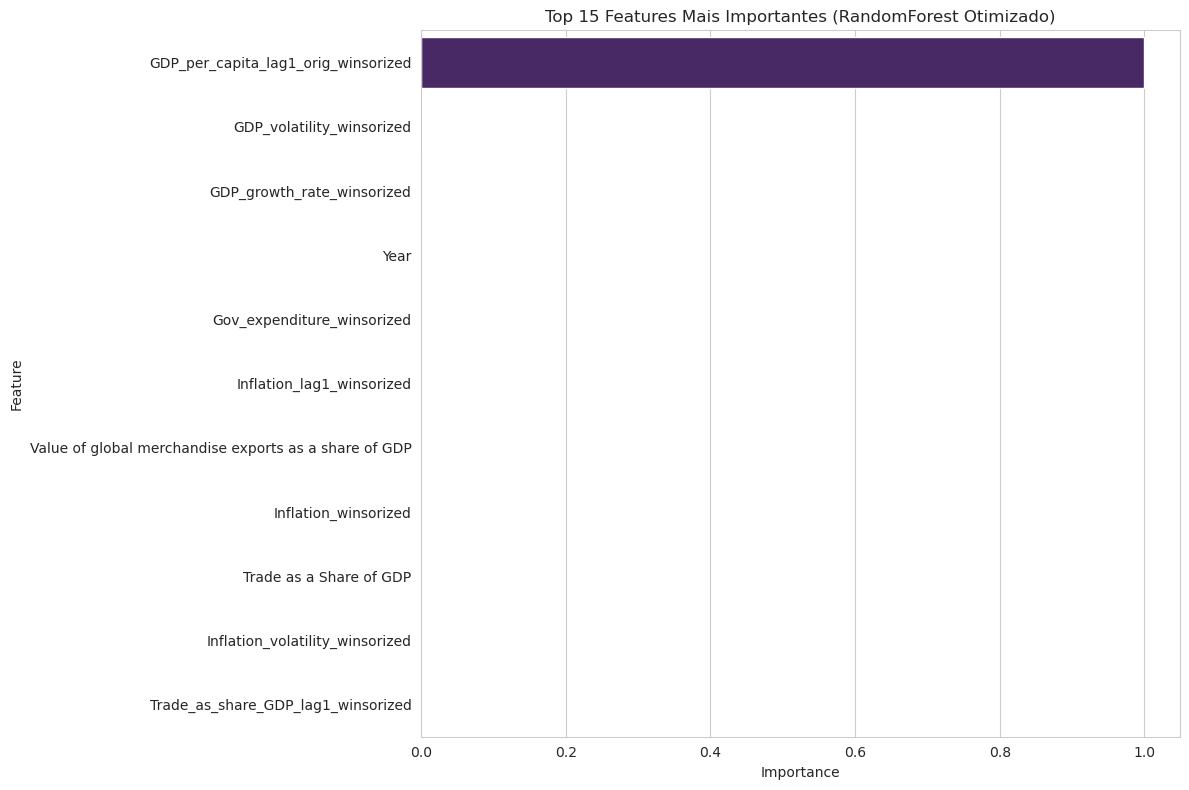


--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS GRADIENT BOOSTING COM OPTUNA ---
Melhores hiperparâmetros encontrados pelo Optuna para Gradient Boosting: {'gb_n_estimators': 104, 'gb_learning_rate': 0.06242411399234212, 'gb_max_depth': 4, 'gb_min_samples_split': 16, 'gb_min_samples_leaf': 10, 'gb_subsample': 0.6, 'gb_max_features': None}

--- TREINAMENTO DO MODELO GRADIENT BOOSTING FINAL COM MELHORES HIPERPARÂMETROS ---
GradientBoosting_Optuna - MAE Teste (Escala PIB Original): 237.66, MSE Teste: 10990658.67

--- GradientBoosting_Optuna: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar      31916.621924           42
24  United Arab Emirates       4365.178082           29
19             Singapore       2138.063673           62
8      Equatorial Guinea       1114.883657           37
4                 Cyprus        242.639358           62
...
             Entity  MAE_PIB_original  Num_Samples
2    

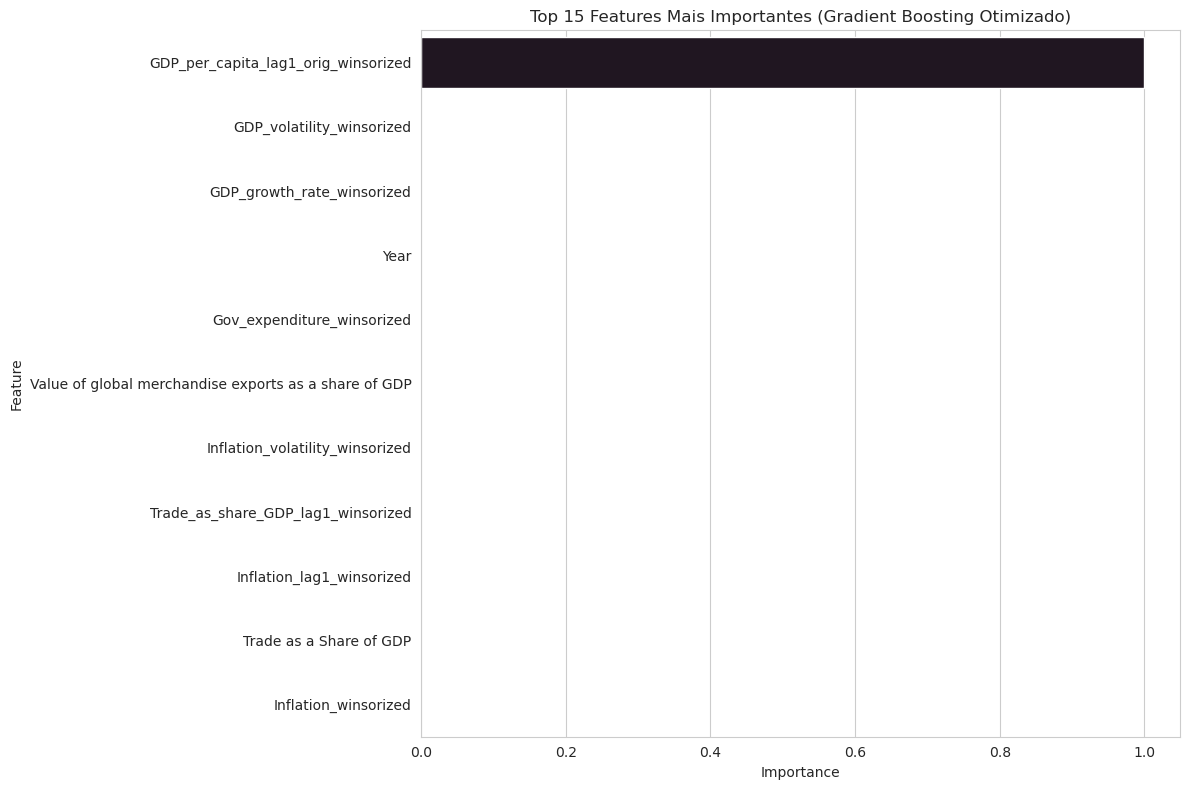


Tamanhos FINAIS dos conjuntos de sequências (LSTM): Treino=109053, Validação=26875, Teste=9611

--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS LSTM COM OPTUNA ---
Melhores hiperparâmetros encontrados pelo Optuna para LSTM: {'embedding_dim': 50, 'hidden_units': 256, 'num_layers': 1, 'learning_rate': 0.0008404645360341567, 'dropout_prob': 0.14413428739381248, 'weight_decay': 5.691650962158729e-06}

--- TREINAMENTO DO MODELO LSTM FINAL COM MELHORES HIPERPARÂMETROS ---
Época 1/30 - Perda Treino: 0.0083 - Perda Validação: 0.0582
  Melhor modelo salvo com perda de validação: 0.0582
Época 2/30 - Perda Treino: 0.0020 - Perda Validação: 0.0329
  Melhor modelo salvo com perda de validação: 0.0329
Época 3/30 - Perda Treino: 0.0017 - Perda Validação: 0.0291
  Melhor modelo salvo com perda de validação: 0.0291
Época 4/30 - Perda Treino: 0.0015 - Perda Validação: 0.0141
  Melhor modelo salvo com perda de validação: 0.0141
Época 5/30 - Perda Treino: 0.0015 - Perda Validação: 0.0086
  Melhor modelo salv

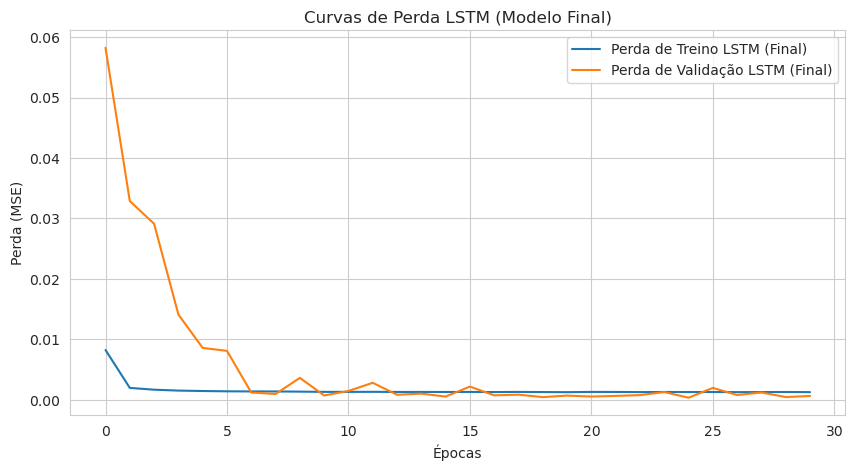


--- AVALIAÇÃO LSTM FINAL NO CONJUNTO DE TESTE ---
LSTM - Perda no Teste (MSE na escala normalizada): 0.0008
LSTM - MSE no Teste (Escala Original do PIB per capita): 721827.38
LSTM - MAE no Teste (Escala Original do PIB per capita): 124.74

--- LSTM: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar       9827.258789           31
8      Equatorial Guinea       3167.364746           26
24  United Arab Emirates       2381.826172           18
19             Singapore       1303.794922           51
3                Croatia        748.913696           25
...
             Entity  MAE_PIB_original  Num_Samples
14          Myanmar        116.814819           51
25         Zimbabwe        102.305649           36
1          Cambodia         80.367516           18
13       Mozambique         45.611885           31
5   East Asia (MPD)         41.389988         8366

--- Comparação de Métricas dos Modelos 

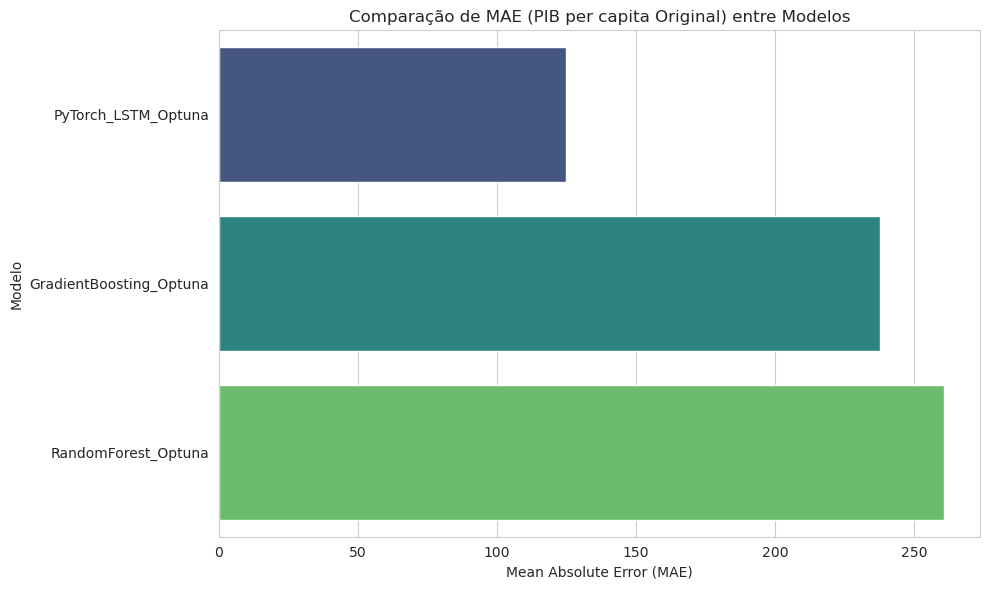

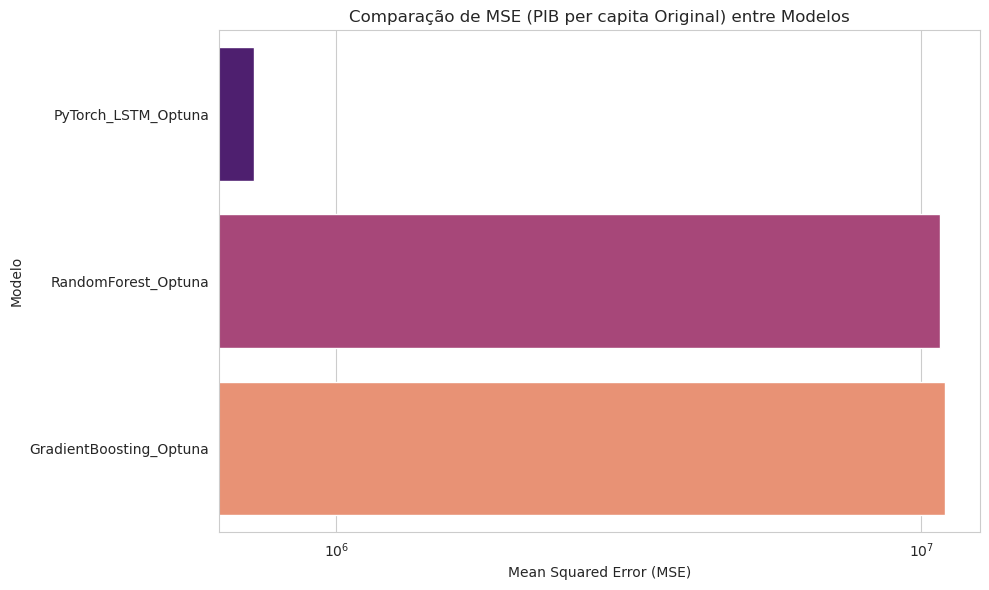

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- ETAPA 0: CONFIGURAÇÃO E FUNÇÕES AUXILIARES ---
device = torch.device('cpu')
print(f"Usando dispositivo: {device}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- ETAPA 1: PRÉ-PROCESSAMENTO DE DADOS ---
def preprocess_data(file_path='data/gdp_per_capita.csv'):
    try:
        df = pd.read_csv(file_path)
        print("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{file_path}' não foi encontrado. Verifique o caminho e a estrutura de pastas.")
        return None

    original_inflation_col_name = '"Inflation, consumer prices (annual %)"'
    cleaned_inflation_col_name = 'Inflation, consumer prices (annual %)'
    if original_inflation_col_name in df.columns:
        df = df.rename(columns={original_inflation_col_name: cleaned_inflation_col_name})

    if 'Code' in df.columns: df['Code'] = df['Code'].fillna('UNK')
    if 'Entity' in df.columns and 'Year' in df.columns: df = df.sort_values(by=['Entity', 'Year'])

    if 'GDP per capita' in df.columns:
        df['GDP per capita'] = pd.to_numeric(df['GDP per capita'], errors='coerce')
        print("Aplicando interpolação linear para 'GDP per capita' por entidade...")
        df['GDP per capita'] = df.groupby('Entity', group_keys=False)['GDP per capita'].apply(lambda series: series.interpolate(method='linear', limit_direction='both'))
        if df['GDP per capita'].isnull().any():
            global_median_gdp = df['GDP per capita'].median()
            df['GDP per capita'] = df['GDP per capita'].fillna(global_median_gdp if not pd.isna(global_median_gdp) else 0)

    other_numerical_cols_to_impute = [
        'Value of global merchandise exports as a share of GDP',
        'Government expenditure (% of GDP)', 'Trade as a Share of GDP', cleaned_inflation_col_name
    ]
    for col in other_numerical_cols_to_impute:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df.groupby('Entity')[col].transform('median'))
            if df[col].isnull().any():
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median if not pd.isna(global_median) else 0)

    if 'Year' in df.columns: df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    print("--- Pré-processamento Concluído ---")
    return df

# --- ETAPA 2: ENGENHARIA DE FEATURES E TRATAMENTO (ANTES DA DIVISÃO DE DADOS) ---
def initial_feature_engineering(df_processed):
    if df_processed is None: return None, None, None, None, None
    print("\n--- INÍCIO DA ENGENHARIA DE FEATURES INICIAL ---")
    df = df_processed.sort_values(by=['Entity', 'Year']).reset_index(drop=True)
    inflation_col_name = 'Inflation, consumer prices (annual %)'

    if 'GDP per capita' in df.columns: df['GDP_per_capita_lag1_orig'] = df.groupby('Entity')['GDP per capita'].shift(1)
    if inflation_col_name in df.columns: df['Inflation_lag1'] = df.groupby('Entity')[inflation_col_name].shift(1)
    else: df['Inflation_lag1'] = np.nan
    if 'Trade as a Share of GDP' in df.columns: df['Trade_as_share_GDP_lag1'] = df.groupby('Entity')['Trade as a Share of GDP'].shift(1)
    else: df['Trade_as_share_GDP_lag1'] = np.nan

    if 'GDP per capita' in df.columns:
        df['GDP_growth_rate'] = df.groupby('Entity')['GDP per capita'].pct_change() * 100
        df['GDP_per_capita_MA3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        df['GDP_per_capita_volatility3'] = df.groupby('Entity')['GDP per capita'].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
    else:
        df['GDP_growth_rate'] = np.nan; df['GDP_per_capita_MA3'] = np.nan; df['GDP_per_capita_volatility3'] = np.nan

    if inflation_col_name in df.columns:
        df['Inflation_volatility3'] = df.groupby('Entity')[inflation_col_name].rolling(window=3, min_periods=1).std().reset_index(level=0, drop=True)
    else: df['Inflation_volatility3'] = np.nan

    critical_lag_cols_initial = [col for col in ['GDP_per_capita_lag1_orig', 'Inflation_lag1', 'Trade_as_share_GDP_lag1', 'GDP_growth_rate'] if col in df.columns]
    if critical_lag_cols_initial:
        df = df.dropna(subset=critical_lag_cols_initial).reset_index(drop=True)

    for vol_col in [col for col in ['GDP_per_capita_volatility3', 'Inflation_volatility3'] if col in df.columns]:
        df[vol_col] = df[vol_col].fillna(0)

    if 'GDP per capita' in df.columns:
        df['GDP_per_capita_log'] = np.log1p(df['GDP per capita'].clip(lower=0))
    else: df['GDP_per_capita_log'] = np.nan

    winsor_limits = (0.01, 0.01)
    cols_to_winsorize_map = {
        inflation_col_name: 'Inflation_winsorized', 'GDP_growth_rate': 'GDP_growth_rate_winsorized',
        'Government expenditure (% of GDP)': 'Gov_expenditure_winsorized',
        'GDP_per_capita_volatility3': 'GDP_volatility_winsorized',
        'Inflation_volatility3': 'Inflation_volatility_winsorized', 'Inflation_lag1': 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1': 'Trade_as_share_GDP_lag1_winsorized',
        'GDP_per_capita_lag1_orig': 'GDP_per_capita_lag1_orig_winsorized'
    }
    for original_col, new_col_name in cols_to_winsorize_map.items():
        if original_col in df.columns and df[original_col].notna().any():
            non_nan_data = df[original_col].dropna()
            if not non_nan_data.empty:
                winsorized_data = winsorize(non_nan_data, limits=winsor_limits)
                df[new_col_name] = np.nan
                df.loc[non_nan_data.index, new_col_name] = winsorized_data
                median_val = df[new_col_name].median()
                df[new_col_name] = df[new_col_name].fillna(median_val if not pd.isna(median_val) else 0)
            else: df[new_col_name] = 0
        elif original_col not in df.columns: df[new_col_name] = 0
        else: df[new_col_name] = 0

    if 'Year' in df.columns and not df['Year'].empty :
        year_max = df['Year'].max()
        if pd.notna(year_max) and year_max > 0 :
            df['Year_sin'] = np.sin(2 * np.pi * df['Year'] / year_max)
            df['Year_cos'] = np.cos(2 * np.pi * df['Year'] / year_max)
        else:
            df['Year_sin'] = 0; df['Year_cos'] = 0
    else:
        df['Year_sin'] = 0; df['Year_cos'] = 0

    target_col_log = 'GDP_per_capita_log'

    base_lstm_numerical_features = [
        'Inflation_winsorized', 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized',
        'GDP_volatility_winsorized', 'Inflation_volatility_winsorized',
        'Gov_expenditure_winsorized', 'Year_sin', 'Year_cos',
    ]
    base_lstm_numerical_features = [f for f in base_lstm_numerical_features if f in df.columns]

    ml_numerical_features = [
        'GDP_per_capita_lag1_orig_winsorized', 'Inflation_winsorized', 'Inflation_lag1_winsorized',
        'Trade_as_share_GDP_lag1_winsorized', 'GDP_growth_rate_winsorized',
        'GDP_volatility_winsorized', 'Inflation_volatility_winsorized',
        'Gov_expenditure_winsorized', 'Year',
        'Value of global merchandise exports as a share of GDP',
        'Trade as a Share of GDP'
    ]
    ml_numerical_features = [f for f in ml_numerical_features if f in df.columns]

    if target_col_log not in df.columns or df[target_col_log].isnull().all():
        print(f"ERRO: Coluna alvo '{target_col_log}' está ausente ou toda NaN após engenharia inicial.")
        return None, [], "", None, []
    df_cleaned = df.dropna(subset=[target_col_log]).copy()

    df_for_ml = df_cleaned.copy()
    cols_for_ml_dropna = [target_col_log] + ml_numerical_features
    cols_for_ml_dropna = [c for c in cols_for_ml_dropna if c in df_for_ml.columns]
    if cols_for_ml_dropna:
        df_for_ml = df_for_ml.dropna(subset=cols_for_ml_dropna).reset_index(drop=True)

    print(f"Colunas base LSTM (antes de lag/interação pós-split): {base_lstm_numerical_features}")
    print(f"Colunas ML: {ml_numerical_features}")
    print(f"Alvo (Log): {target_col_log}")
    print(f"Shape df_cleaned (base para LSTM): {df_cleaned.shape}, Shape df_for_ml: {df_for_ml.shape}")
    print("--- Engenharia de Features Inicial Concluída ---")
    return df_cleaned, base_lstm_numerical_features, target_col_log, df_for_ml, ml_numerical_features

# --- ETAPA 3, 4, 5 (Dataset, Modelo LSTM, Treino, Avaliação) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, y_data, entity_data):
        self.X_data = X_data; self.y_data = y_data; self.entity_data = entity_data
    def __len__(self): return len(self.X_data)
    def __getitem__(self, idx):
        x_features = np.asarray(self.X_data[idx], dtype=np.float32)
        y_target = np.asarray(self.y_data[idx], dtype=np.float32)
        entity = np.asarray(self.entity_data[idx], dtype=np.int64)
        return (torch.tensor(x_features, device=device),
                torch.tensor(y_target, device=device),
                torch.tensor(entity, device=device))

def create_sequences_from_df(df, numerical_features, target_col, entity_col_encoded, sequence_length):
    X_seq, y_seq, entity_seq_codes = [], [], []
    unique_entities = df[entity_col_encoded].unique()
    if not numerical_features:
        return np.array([]).reshape(0,sequence_length,0), np.array([]).reshape(-1,1), np.array([])
    if not all(isinstance(item, str) for item in numerical_features):
        valid_str_features = [f for f in numerical_features if isinstance(f, str)]
        if not valid_str_features:
            return np.array([]).reshape(0,sequence_length,0), np.array([]).reshape(-1,1), np.array([])
        numerical_features = valid_str_features
    for entity_code in unique_entities:
        entity_df = df[df[entity_col_encoded] == entity_code].copy()
        actual_features_in_entity_df = [f for f in numerical_features if f in entity_df.columns and not entity_df[f].isnull().all()]
        if len(actual_features_in_entity_df) != len(numerical_features): continue
        for col in actual_features_in_entity_df:
            entity_df[col] = pd.to_numeric(entity_df[col], errors='coerce')
        entity_df = entity_df.dropna(subset=actual_features_in_entity_df + [target_col])
        if entity_df.empty or len(entity_df) < sequence_length + 1: continue
        X_entity_features = entity_df[actual_features_in_entity_df].astype(np.float32).values
        y_entity_target = entity_df[target_col].astype(np.float32).values
        if X_entity_features.shape[1] != len(actual_features_in_entity_df): continue
        for i in range(len(entity_df) - sequence_length):
            X_seq.append(X_entity_features[i : i + sequence_length])
            y_seq.append(y_entity_target[i + sequence_length])
            entity_seq_codes.append(entity_code)
    if not X_seq:
        return np.array([]).reshape(0,sequence_length,len(numerical_features)), np.array([]).reshape(-1,1), np.array([])
    return np.array(X_seq, dtype=np.float32), \
           np.array(y_seq, dtype=np.float32).reshape(-1, 1), \
           np.array(entity_seq_codes)

class LSTMForecastModel(nn.Module):
    def __init__(self, num_numerical_features, num_entities, embedding_dim, hidden_units, num_layers, dropout_prob=0.2):
        super(LSTMForecastModel, self).__init__()
        self.num_numerical_features = num_numerical_features
        self.embedding_dim = embedding_dim
        self.entity_embedding = nn.Embedding(num_embeddings=num_entities, embedding_dim=embedding_dim)
        self.lstm_input_size = num_numerical_features + embedding_dim
        self.lstm = nn.LSTM( input_size=self.lstm_input_size, hidden_size=hidden_units,
                             num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(in_features=hidden_units, out_features=1)
    def forward(self, x_numerical, x_entity_code_for_seq):
        entity_embeddings_batch = self.entity_embedding(x_entity_code_for_seq)
        seq_len = x_numerical.size(1)
        entity_embeddings_repeated = entity_embeddings_batch.unsqueeze(1).repeat(1, seq_len, 1)
        combined_features = torch.cat((x_numerical, entity_embeddings_repeated), dim=2)
        if combined_features.shape[-1] != self.lstm.input_size:
            raise RuntimeError(f"Discrepância de dimensão de entrada no LSTM! Esperado: {self.lstm.input_size}, Recebido: {combined_features.shape[-1]}. NumFeat (modelo): {self.num_numerical_features}, EmbDim (modelo): {self.embedding_dim}, x_numerical shape: {x_numerical.shape}")
        lstm_out, _ = self.lstm(combined_features)
        last_time_step_out = lstm_out[:, -1, :]
        dropped_out = self.dropout(last_time_step_out)
        y_pred = self.linear(dropped_out)
        return y_pred

def train_model_lstm_for_optuna(trial, train_loader, val_loader, num_numerical_features, num_entities, device, sequence_length):
    embedding_dim = trial.suggest_categorical('embedding_dim', [10, 20, 30, 40, 50])
    hidden_units = trial.suggest_categorical('hidden_units', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 1) # Restringido para 1 camada
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.4)
    weight_decay_optuna = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    model = LSTMForecastModel(
        num_numerical_features=num_numerical_features, num_entities=num_entities,
        embedding_dim=embedding_dim, hidden_units=hidden_units,
        num_layers=num_layers, dropout_prob=dropout_prob
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_optuna)

    num_epochs_optuna = 10

    for epoch in range(num_epochs_optuna):
        model.train()
        if not train_loader or len(train_loader.dataset) == 0: return float('inf')
        for X_batch_num, y_batch, X_batch_entity in train_loader:
            X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
            optimizer.zero_grad(); y_pred = model(X_batch_num, X_batch_entity)
            loss = criterion(y_pred, y_batch); loss.backward(); optimizer.step()
        model.eval()
        running_val_loss = 0.0
        if val_loader and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for X_batch_num, y_batch, X_batch_entity in val_loader:
                    X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                    y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
                    running_val_loss += loss.item() * X_batch_num.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune(): raise optuna.exceptions.TrialPruned()
        else: return float('inf')
    return epoch_val_loss

def train_final_lstm_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        if not train_loader or len(train_loader.dataset) == 0:
            epoch_train_loss = float('nan')
        else:
            for X_batch_num, y_batch, X_batch_entity in train_loader:
                X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                optimizer.zero_grad(); y_pred = model(X_batch_num, X_batch_entity)
                loss = criterion(y_pred, y_batch); loss.backward(); optimizer.step()
                running_train_loss += loss.item() * X_batch_num.size(0)
            epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval(); running_val_loss = 0.0
        if val_loader and len(val_loader.dataset) > 0:
            with torch.no_grad():
                for X_batch_num, y_batch, X_batch_entity in val_loader:
                    X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
                    y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
                    running_val_loss += loss.item() * X_batch_num.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
        else: epoch_val_loss = float('nan')
        val_losses.append(epoch_val_loss)
        print(f"Época {epoch+1}/{num_epochs} - Perda Treino: {epoch_train_loss:.4f} - Perda Validação: {epoch_val_loss:.4f}")
        if not pd.isna(epoch_val_loss) and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; torch.save(model.state_dict(), 'models/best_lstm_model.pth'); epochs_no_improve = 0
            print(f"  Melhor modelo salvo com perda de validação: {best_val_loss:.4f}")
        elif not pd.isna(epoch_val_loss):
            epochs_no_improve += 1
            if epochs_no_improve >= patience: print(f"  Parada antecipada! Sem melhoria por {patience} épocas."); break
        elif pd.isna(epoch_val_loss) and epoch_train_loss < 0.0001 and epoch > 3 :
             print(f"  Parada: Validação NaN e treino ({epoch_train_loss:.4f}) baixo."); break
    try:
        model.load_state_dict(torch.load('models/best_lstm_model.pth', map_location=device, weights_only=True))
        print("Melhor modelo carregado com weights_only=True.")
    except Exception as e: print(f"Aviso: Não foi possível carregar 'best_lstm_model.pth' ({e}).")
    return model, train_losses, val_losses

def evaluate_model_lstm(model, test_loader, criterion, device, target_scaler=None, entity_encoder=None):
    model.eval()
    test_loss = 0.0
    all_y_true_scaled, all_y_pred_scaled, all_entities_encoded = [], [], []
    if test_loader is None or len(test_loader.dataset) == 0 :
        print("Aviso: Conjunto de teste LSTM vazio ou loader não fornecido.")
        return np.array([]), np.array([]), float('nan'), float('nan'), float('nan'), pd.DataFrame()
    with torch.no_grad():
        for X_batch_num, y_batch, X_batch_entity in test_loader:
            X_batch_num, y_batch, X_batch_entity = X_batch_num.to(device), y_batch.to(device), X_batch_entity.to(device)
            y_pred = model(X_batch_num, X_batch_entity); loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch_num.size(0)
            all_y_true_scaled.extend(y_batch.cpu().numpy())
            all_y_pred_scaled.extend(y_pred.cpu().numpy())
            all_entities_encoded.extend(X_batch_entity.cpu().numpy())
    if len(test_loader.dataset) == 0: return np.array(all_y_true_scaled), np.array(all_y_pred_scaled), float('nan'), float('nan'), float('nan'), pd.DataFrame()
    avg_test_loss_scaled = test_loss / len(test_loader.dataset)
    print(f"LSTM - Perda no Teste (MSE na escala normalizada): {avg_test_loss_scaled:.4f}")
    mae_pib = float('nan'); mse_pib = float('nan')
    mae_per_entity_df = pd.DataFrame()
    if target_scaler is not None and len(all_y_true_scaled) > 0:
        y_true_log_original = target_scaler.inverse_transform(np.array(all_y_true_scaled).reshape(-1,1))
        y_pred_log_original = target_scaler.inverse_transform(np.array(all_y_pred_scaled).reshape(-1,1))
        y_true_actual_pib = np.expm1(y_true_log_original); y_pred_actual_pib = np.expm1(y_pred_log_original)
        mse_pib = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
        mae_pib = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
        print(f"LSTM - MSE no Teste (Escala Original do PIB per capita): {mse_pib:.2f}")
        print(f"LSTM - MAE no Teste (Escala Original do PIB per capita): {mae_pib:.2f}")
        if entity_encoder is not None and all_entities_encoded:
            results_df = pd.DataFrame({'Entity_Encoded': all_entities_encoded,
                                   'y_true_actual_pib': y_true_actual_pib.flatten(),
                                   'y_pred_actual_pib': y_pred_actual_pib.flatten()})
            results_df['Entity'] = entity_encoder.inverse_transform(results_df['Entity_Encoded'])
            mae_per_entity_list = [{'Entity': entity_name,
                                    'MAE_PIB_original': mean_absolute_error(group['y_true_actual_pib'], group['y_pred_actual_pib']),
                                    'Num_Samples': len(group)}
                                   for entity_name, group in results_df.groupby('Entity')]
            if mae_per_entity_list:
                mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original', ascending=False)
                print("\n--- LSTM: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---")
                print(mae_per_entity_df.head(5)); print("..."); print(mae_per_entity_df.tail(5))
    return np.array(all_y_true_scaled), np.array(all_y_pred_scaled), avg_test_loss_scaled, mae_pib, mse_pib, mae_per_entity_df

def evaluate_model_generic(model_name, model, X_test, y_test_log_scaled, target_scaler, entity_encoder=None, X_test_entities_encoded=None):
    if X_test.empty:
        print(f"{model_name} - Conjunto de teste vazio. Avaliação ignorada.")
        return float('nan'), float('nan'), np.array([]), np.array([]), pd.DataFrame()
    y_pred_log_scaled = model.predict(X_test)
    y_pred_log_original = target_scaler.inverse_transform(y_pred_log_scaled.reshape(-1,1))
    y_true_log_original = target_scaler.inverse_transform(y_test_log_scaled.reshape(-1,1))
    y_pred_actual_pib = np.expm1(y_pred_log_original); y_true_actual_pib = np.expm1(y_true_log_original)
    mae = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
    mse = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
    print(f"{model_name} - MAE Teste (Escala PIB Original): {mae:.2f}, MSE Teste: {mse:.2f}")
    mae_per_entity_df = pd.DataFrame()
    if entity_encoder is not None and X_test_entities_encoded is not None and len(X_test_entities_encoded) > 0:
        results_df = pd.DataFrame({'Entity_Encoded': X_test_entities_encoded,
                                   'y_true_actual_pib': y_true_actual_pib.flatten(),
                                   'y_pred_actual_pib': y_pred_actual_pib.flatten()})
        results_df['Entity'] = entity_encoder.inverse_transform(results_df['Entity_Encoded'])
        mae_per_entity_list = [{'Entity': entity_name,
                                'MAE_PIB_original': mean_absolute_error(group['y_true_actual_pib'], group['y_pred_actual_pib']),
                                'Num_Samples': len(group)}
                               for entity_name, group in results_df.groupby('Entity')]
        if mae_per_entity_list:
            mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original', ascending=False)
            print(f"\n--- {model_name}: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---")
            print(mae_per_entity_df.head(5)); print("..."); print(mae_per_entity_df.tail(5))
    return mae, mse, y_true_actual_pib, y_pred_actual_pib, mae_per_entity_df

def train_model_rf_for_optuna(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model_rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED,
        n_jobs=-1,
        oob_score=False
    )
    model_rf.fit(X_train, y_train)
    preds_val = model_rf.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    return mse_val

def train_model_gb_for_optuna(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('gb_n_estimators', 50, 250)
    learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.2, log=True)
    max_depth = trial.suggest_int('gb_max_depth', 3, 10)
    min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('gb_subsample', 0.6, 1.0, step=0.1)
    max_features = trial.suggest_categorical('gb_max_features', ['sqrt', 'log2', None])

    model_gb = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=SEED
    )
    model_gb.fit(X_train, y_train)
    preds_val = model_gb.predict(X_val)
    mse_val = mean_squared_error(y_val, preds_val)
    return mse_val

if __name__ == '__main__':
    SEQUENCE_LENGTH = 10
    df_raw = preprocess_data()

    if df_raw is not None:
        df_processed_initial, base_lstm_numerical_features, target_col_log, \
        df_ml_initial, ml_numerical_features = initial_feature_engineering(df_raw)

        if df_processed_initial is not None and not df_processed_initial.empty and \
           target_col_log in df_processed_initial and not df_processed_initial[target_col_log].isnull().all() and \
           df_ml_initial is not None and not df_ml_initial.empty:

            entity_encoder = LabelEncoder()
            df_processed_initial['Entity_Encoded'] = entity_encoder.fit_transform(df_processed_initial['Entity'])
            if 'Entity' in df_ml_initial.columns:
                 df_ml_initial['Entity_Encoded'] = entity_encoder.transform(df_ml_initial['Entity'])
            num_unique_entities = df_processed_initial['Entity_Encoded'].nunique()
            print(f"\nNúmero de entidades únicas: {num_unique_entities}")

            print("\nDividindo entidades para treino, validação e teste (70/15/15 das entidades)...")
            all_entity_codes = df_processed_initial['Entity_Encoded'].unique()
            np.random.shuffle(all_entity_codes)
            train_entity_codes, temp_entity_codes = train_test_split(all_entity_codes, test_size=0.30, random_state=SEED)
            val_entity_codes, test_entity_codes = train_test_split(temp_entity_codes, test_size=0.50, random_state=SEED)
            print(f"Entidades de Treino: {len(train_entity_codes)}, Validação: {len(val_entity_codes)}, Teste: {len(test_entity_codes)}")

            df_train_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(train_entity_codes)].copy()
            df_val_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(val_entity_codes)].copy()
            df_test_lstm = df_processed_initial[df_processed_initial['Entity_Encoded'].isin(test_entity_codes)].copy()

            df_train_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(train_entity_codes)].copy()
            df_val_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(val_entity_codes)].copy()
            df_test_ml = df_ml_initial[df_ml_initial['Entity_Encoded'].isin(test_entity_codes)].copy()

            print(f"Linhas (LSTM, antes norm/lag): Treino={len(df_train_lstm)}, Val={len(df_val_lstm)}, Teste={len(df_test_lstm)}")
            print(f"Linhas (ML, antes norm): Treino={len(df_train_ml)}, Val={len(df_val_ml)}, Teste={len(df_test_ml)}")

            print("\nNormalizando features e alvo (ajustado no treino)...")
            scalers = {}
            final_lstm_numerical_features_for_model = []

            target_scaler = StandardScaler()
            if not df_train_lstm[target_col_log].isnull().all():
                df_train_lstm[target_col_log] = target_scaler.fit_transform(df_train_lstm[[target_col_log]])
                scalers[target_col_log] = target_scaler
                for df_s in [df_val_lstm, df_test_lstm, df_train_ml, df_val_ml, df_test_ml]:
                    if target_col_log in df_s:
                        mean_train_target_for_fill = df_train_lstm[target_col_log].mean()
                        df_s[target_col_log] = target_scaler.transform(df_s[[target_col_log]].fillna(mean_train_target_for_fill))
            else:
                print(f"Aviso Crítico: Coluna alvo '{target_col_log}' toda NaN no treino LSTM. Modelagem pode falhar.")
                for df_s_target in [df_train_lstm, df_val_lstm, df_test_lstm, df_train_ml, df_val_ml, df_test_ml]:
                    if target_col_log in df_s_target: df_s_target[target_col_log] = df_s_target[target_col_log].fillna(0)

            processed_splits_lstm = {}
            for df_s_name, df_s_orig in [("Treino LSTM", df_train_lstm), ("Validação LSTM", df_val_lstm), ("Teste LSTM", df_test_lstm)]:
                df_s = df_s_orig.copy()
                for col in base_lstm_numerical_features:
                    if col in df_s:
                        scaler_name = f"lstm_{col}"
                        if df_s_name == "Treino LSTM" and not df_s[col].isnull().all():
                            scaler = StandardScaler(); df_s[col] = scaler.fit_transform(df_s[[col]])
                            scalers[scaler_name] = scaler
                        elif scaler_name in scalers:
                            mean_train_col_for_fill_value = df_train_lstm[col].mean() if col in df_train_lstm and not df_train_lstm[col].isnull().all() else 0
                            df_s[col] = scalers[scaler_name].transform(df_s[[col]].fillna(mean_train_col_for_fill_value))
                        elif col in df_s: df_s[col] = df_s[col].fillna(0)
                    else: df_s[col] = 0
                if target_col_log in df_s:
                    df_s['GDP_per_capita_log_lag1'] = df_s.groupby('Entity_Encoded', group_keys=False)[target_col_log].shift(1)
                else: df_s['GDP_per_capita_log_lag1'] = np.nan
                if 'GDP_per_capita_log_lag1' in df_s and 'Inflation_winsorized' in df_s:
                    df_s['Interaction_LagGDP_Inflation'] = df_s['GDP_per_capita_log_lag1'] * df_s['Inflation_winsorized']
                else: df_s['Interaction_LagGDP_Inflation'] = np.nan
                current_split_lstm_features = ['GDP_per_capita_log_lag1'] + \
                                              [f for f in base_lstm_numerical_features if f in df_s.columns] + \
                                              ['Interaction_LagGDP_Inflation']
                current_split_lstm_features = [f for f in current_split_lstm_features if f in df_s.columns]
                if df_s_name == "Treino LSTM":
                    final_lstm_numerical_features_for_model = [f for f in current_split_lstm_features if not df_s[f].isnull().all()]
                    print(f"Features LSTM finais para o modelo (definidas a partir do treino): {final_lstm_numerical_features_for_model}")
                df_s.dropna(subset=final_lstm_numerical_features_for_model + [target_col_log], inplace=True)
                print(f"Shape {df_s_name} após normalização e criação final de features: {df_s.shape}")
                processed_splits_lstm[df_s_name.split()[0].lower()] = df_s
            df_train_lstm = processed_splits_lstm['treino']
            df_val_lstm = processed_splits_lstm['validação']
            df_test_lstm = processed_splits_lstm['teste']

            for col in ml_numerical_features:
                if col in df_train_ml and not df_train_ml[col].isnull().all():
                    scaler = StandardScaler(); df_train_ml[col] = scaler.fit_transform(df_train_ml[[col]])
                    scalers[f"ml_{col}"] = scaler
                    for df_ml_split in [df_val_ml, df_test_ml]:
                        if col in df_ml_split:
                             mean_fill = df_train_ml[col].mean()
                             df_ml_split[col] = scaler.transform(df_ml_split[[col]].fillna(mean_fill))
                elif col in df_train_ml:
                    df_train_ml[col] = 0
                    for df_ml_split in [df_val_ml, df_test_ml]:
                        if col in df_ml_split: df_ml_split[col] = 0

            cols_to_check_ml_train = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_train_ml.columns]
            df_train_ml.dropna(subset=cols_to_check_ml_train, inplace=True)
            cols_to_check_ml_val = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_val_ml.columns]
            df_val_ml.dropna(subset=cols_to_check_ml_val, inplace=True)
            cols_to_check_ml_test = [target_col_log] + [feat for feat in ml_numerical_features if feat in df_test_ml.columns]
            df_test_ml.dropna(subset=cols_to_check_ml_test, inplace=True)

            print(f"Shape Treino ML após normalização e dropna final: {df_train_ml.shape}")
            print(f"Shape Validação ML após normalização e dropna final: {df_val_ml.shape}")
            print(f"Shape Teste ML após normalização e dropna final: {df_test_ml.shape}")

            valid_ml_features = [f for f in ml_numerical_features if f in df_train_ml.columns and not df_train_ml[f].isnull().all()]
            if not all(f in df_val_ml.columns for f in valid_ml_features) or not all(f in df_test_ml.columns for f in valid_ml_features):
                print("Aviso: Nem todas as features válidas de treino ML estão nos conjuntos de validação/teste ML. Ajustando features.")
                valid_ml_features = [f for f in valid_ml_features if f in df_val_ml.columns and f in df_test_ml.columns]

            X_train_ml = df_train_ml[valid_ml_features].copy()
            y_train_ml = df_train_ml[target_col_log].copy()
            X_val_ml = df_val_ml[valid_ml_features].copy()
            y_val_ml = df_val_ml[target_col_log].copy()
            X_test_ml = df_test_ml[valid_ml_features].copy()
            y_test_ml_log_scaled = df_test_ml[target_col_log].copy()
            X_test_ml_entities_encoded = df_test_ml['Entity_Encoded'].values if 'Entity_Encoded' in df_test_ml else None

            ml_models_results = {}

            if not X_train_ml.empty and not y_train_ml.empty and not X_val_ml.empty and not y_val_ml.empty and not X_test_ml.empty and target_col_log in scalers:
                print("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS RANDOMFOREST COM OPTUNA ---")
                study_rf = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2, interval_steps=1))
                study_rf.optimize(lambda trial: train_model_rf_for_optuna(trial, X_train_ml, y_train_ml, X_val_ml, y_val_ml),
                               n_trials=15, n_jobs=-1)
                best_hyperparams_rf = study_rf.best_params
                print("Melhores hiperparâmetros encontrados pelo Optuna para RandomForest:", best_hyperparams_rf)

                print("\n--- TREINAMENTO DO MODELO RANDOMFOREST FINAL COM MELHORES HIPERPARÂMETROS ---")
                final_rf_model = RandomForestRegressor(
                    n_estimators=best_hyperparams_rf['n_estimators'],
                    max_depth=best_hyperparams_rf['max_depth'],
                    min_samples_split=best_hyperparams_rf['min_samples_split'],
                    min_samples_leaf=best_hyperparams_rf['min_samples_leaf'],
                    max_features=best_hyperparams_rf['max_features'],
                    random_state=SEED, n_jobs=-1, oob_score=True
                )
                final_rf_model.fit(X_train_ml, y_train_ml)
                print(f"RandomForest Otimizado OOB Score: {final_rf_model.oob_score_:.4f}" if hasattr(final_rf_model, 'oob_score_') and final_rf_model.oob_score_ is not None else "RandomForest Otimizado OOB Score: N/A")

                rf_opt_mae, rf_opt_mse, _, _, rf_opt_mae_df = evaluate_model_generic("RandomForest_Optuna", final_rf_model, X_test_ml, y_test_ml_log_scaled.values, scalers[target_col_log], entity_encoder, X_test_ml_entities_encoded)
                ml_models_results['RandomForest_Optuna'] = {'MAE': rf_opt_mae, 'MSE': rf_opt_mse}

                print("\n--- Importância das Features (RandomForest Otimizado) ---")
                importances_rf = final_rf_model.feature_importances_
                feature_importance_df_rf = pd.DataFrame({'Feature': valid_ml_features, 'Importance': importances_rf})
                feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
                print(feature_importance_df_rf.head(10))

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df_rf.head(15),
                            palette='viridis', legend=False, dodge=False)
                plt.title('Top 15 Features Mais Importantes (RandomForest Otimizado)')
                plt.tight_layout(); plt.show()

                print("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS GRADIENT BOOSTING COM OPTUNA ---")
                study_gb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2, interval_steps=1))
                study_gb.optimize(lambda trial: train_model_gb_for_optuna(trial, X_train_ml, y_train_ml, X_val_ml, y_val_ml),
                               n_trials=15, n_jobs=-1)
                best_hyperparams_gb = study_gb.best_params
                print("Melhores hiperparâmetros encontrados pelo Optuna para Gradient Boosting:", best_hyperparams_gb)

                print("\n--- TREINAMENTO DO MODELO GRADIENT BOOSTING FINAL COM MELHORES HIPERPARÂMETROS ---")
                final_gb_model = GradientBoostingRegressor(
                    n_estimators=best_hyperparams_gb['gb_n_estimators'],
                    learning_rate=best_hyperparams_gb['gb_learning_rate'],
                    max_depth=best_hyperparams_gb['gb_max_depth'],
                    min_samples_split=best_hyperparams_gb['gb_min_samples_split'],
                    min_samples_leaf=best_hyperparams_gb['gb_min_samples_leaf'],
                    subsample=best_hyperparams_gb['gb_subsample'],
                    max_features=best_hyperparams_gb['gb_max_features'],
                    random_state=SEED
                )
                final_gb_model.fit(X_train_ml, y_train_ml)
                gb_opt_mae, gb_opt_mse, _, _, gb_opt_mae_df = evaluate_model_generic("GradientBoosting_Optuna", final_gb_model, X_test_ml, y_test_ml_log_scaled.values, scalers[target_col_log], entity_encoder, X_test_ml_entities_encoded)
                ml_models_results['GradientBoosting_Optuna'] = {'MAE': gb_opt_mae, 'MSE': gb_opt_mse}

                # Adicionar Análise de Importância das Features para Gradient Boosting Otimizado
                print("\n--- Importância das Features (Gradient Boosting Otimizado) ---")
                if hasattr(final_gb_model, 'feature_importances_'):
                    importances_gb = final_gb_model.feature_importances_
                    feature_importance_df_gb = pd.DataFrame({'Feature': valid_ml_features, 'Importance': importances_gb})
                    feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)
                    print(feature_importance_df_gb.head(10)) # Mostrar top 10 features

                    plt.figure(figsize=(12, 8))
                    sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df_gb.head(15),
                                palette='mako', legend=False, dodge=False) # Usar outra paleta para diferenciar
                    plt.title('Top 15 Features Mais Importantes (Gradient Boosting Otimizado)')
                    plt.tight_layout(); plt.show()
                else:
                    print("Não foi possível obter a importância das features para o Gradient Boosting.")


            else:
                print("Conjuntos de treino/validação/teste para ML vazios, com NaNs, ou scaler do alvo ausente. Pulando modelos ML.")

            X_train_lstm_seq, y_train_lstm_seq, entity_train_lstm_seq = create_sequences_from_df(df_train_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_val_lstm_seq, y_val_lstm_seq, entity_val_lstm_seq = create_sequences_from_df(df_val_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)
            X_test_lstm_seq, y_test_lstm_seq, entity_test_lstm_seq = create_sequences_from_df(df_test_lstm, final_lstm_numerical_features_for_model, target_col_log, 'Entity_Encoded', SEQUENCE_LENGTH)

            print(f"\nTamanhos FINAIS dos conjuntos de sequências (LSTM): Treino={len(X_train_lstm_seq)}, Validação={len(X_val_lstm_seq)}, Teste={len(X_test_lstm_seq)}")

            if len(X_train_lstm_seq) == 0 or (len(val_entity_codes) > 0 and len(X_val_lstm_seq) == 0 and len(train_entity_codes) > 0) :
                print("ERRO CRÍTICO: Conjunto de treino ou validação LSTM vazio após criação de sequências.")
            elif target_col_log not in scalers:
                print("ERRO CRÍTICO: Scaler da coluna alvo não foi treinado. Modelagem LSTM não pode prosseguir.")
            else:
                train_dataset_lstm = TimeSeriesDataset(X_train_lstm_seq, y_train_lstm_seq, entity_train_lstm_seq)
                val_dataset_lstm = TimeSeriesDataset(X_val_lstm_seq, y_val_lstm_seq, entity_val_lstm_seq) if len(X_val_lstm_seq) > 0 else None
                test_dataset_lstm = TimeSeriesDataset(X_test_lstm_seq, y_test_lstm_seq, entity_test_lstm_seq) if len(X_test_lstm_seq) > 0 else None

                BATCH_SIZE_OPTUNA = 64
                train_loader_optuna = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=True, drop_last=True)
                val_loader_optuna = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if val_dataset_lstm else None

                print("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS LSTM COM OPTUNA ---")
                num_features_for_model_init = X_train_lstm_seq.shape[2] if X_train_lstm_seq.ndim == 3 and X_train_lstm_seq.shape[0] > 0 else 0

                if num_features_for_model_init > 0:
                    study_lstm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=2))
                    study_lstm.optimize(lambda trial: train_model_lstm_for_optuna(trial, train_loader_optuna,
                                                                            val_loader_optuna if val_loader_optuna else train_loader_optuna,
                                                                            num_features_for_model_init, num_unique_entities, device, SEQUENCE_LENGTH),
                                   n_trials=25, n_jobs=1) # Aumentado para 25 trials

                    best_hyperparams_lstm = study_lstm.best_params
                    print("Melhores hiperparâmetros encontrados pelo Optuna para LSTM:", best_hyperparams_lstm)

                    print("\n--- TREINAMENTO DO MODELO LSTM FINAL COM MELHORES HIPERPARÂMETROS ---")
                    final_lstm_model = LSTMForecastModel(
                        num_numerical_features=num_features_for_model_init,
                        num_entities=num_unique_entities,
                        embedding_dim=best_hyperparams_lstm['embedding_dim'],
                        hidden_units=best_hyperparams_lstm['hidden_units'],
                        num_layers=best_hyperparams_lstm['num_layers'], # Usará o num_layers otimizado (que agora é 1)
                        dropout_prob=best_hyperparams_lstm['dropout_prob']
                    ).to(device)
                    final_optimizer = optim.Adam(final_lstm_model.parameters(), lr=best_hyperparams_lstm['learning_rate'], weight_decay=best_hyperparams_lstm['weight_decay'])
                    criterion_final_lstm = nn.MSELoss()

                    final_train_loader = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=True, drop_last=True)
                    final_val_loader = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if val_dataset_lstm else None

                    trained_final_lstm_model, final_train_losses, final_val_losses = train_final_lstm_model(
                        final_lstm_model, final_train_loader,
                        final_val_loader if final_val_loader else final_train_loader,
                        criterion_final_lstm, final_optimizer,
                        num_epochs=30, device=device, patience=10
                    )

                    if final_train_losses :
                        plt.figure(figsize=(10, 5))
                        plt.plot(final_train_losses, label='Perda de Treino LSTM (Final)')
                        if final_val_losses and not all(pd.isna(final_val_losses)):
                             plt.plot(final_val_losses, label='Perda de Validação LSTM (Final)')
                        plt.title('Curvas de Perda LSTM (Modelo Final)')
                        plt.xlabel('Épocas'); plt.ylabel('Perda (MSE)')
                        plt.legend(); plt.grid(True); plt.show()

                    test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=BATCH_SIZE_OPTUNA, shuffle=False) if test_dataset_lstm else None
                    if test_loader_lstm and len(test_loader_lstm.dataset) > 0:
                        print("\n--- AVALIAÇÃO LSTM FINAL NO CONJUNTO DE TESTE ---")
                        _, _, _, lstm_mae, lstm_mse, _ = evaluate_model_lstm(
                            trained_final_lstm_model, test_loader_lstm, criterion_final_lstm, device,
                            target_scaler=scalers.get(target_col_log), entity_encoder=entity_encoder
                        )
                        if not pd.isna(lstm_mae):
                             ml_models_results['PyTorch_LSTM_Optuna'] = {'MAE': lstm_mae, 'MSE': lstm_mse}
                    else: print("Avaliação LSTM final no teste não realizada.")
                else:
                    print("ERRO: Nenhuma feature numérica para o modelo LSTM após criação de sequências.")

            print("\n--- Comparação de Métricas dos Modelos ---")
            if ml_models_results:
                metrics_df = pd.DataFrame(ml_models_results).T.reset_index().rename(columns={'index':'Modelo'})
                metrics_df = metrics_df.sort_values('MAE', ascending=True)

                plt.figure(figsize=(10, 6))
                sns.barplot(x='MAE', y='Modelo', hue='Modelo', data=metrics_df,
                            palette="viridis", legend=False, dodge=False)
                plt.title('Comparação de MAE (PIB per capita Original) entre Modelos')
                plt.xlabel('Mean Absolute Error (MAE)')
                plt.ylabel('Modelo')
                plt.tight_layout(); plt.show()

                plt.figure(figsize=(10, 6))
                metrics_df_mse_sorted = metrics_df.sort_values('MSE', ascending=True)
                sns.barplot(x='MSE', y='Modelo', hue='Modelo', data=metrics_df_mse_sorted,
                            palette="magma", legend=False, dodge=False)
                plt.title('Comparação de MSE (PIB per capita Original) entre Modelos')
                plt.xlabel('Mean Squared Error (MSE)')
                plt.ylabel('Modelo')
                plt.xscale('log')
                plt.tight_layout(); plt.show()
            else: print("Nenhum resultado de modelo para comparar.")
        else:
            print("DataFrame de features vazio ou alvo ausente após engenharia inicial. Modelagem não pode prosseguir.")
    else:
        print("Pré-processamento inicial falhou (arquivo não encontrado ou erro). Modelagem não pode prosseguir.")

## **Algoritmo de Previsão de PIB (TensorFlow Keras)**

2025-05-25 22:37:28 - __main__ - 2625485089.py:39 - WARNING - optuna.integration.TFKerasPruningCallback REAL não encontrado. Pruning de Keras trials via callback Optuna NÃO estará ativo.
2025-05-25 22:37:28 - __main__ - 2625485089.py:92 - INFO - Usando dispositivo: CPU (TensorFlow) - GPUs desabilitadas programaticamente.
2025-05-25 22:37:28 - __main__ - 2625485089.py:991 - INFO - >>> MODO DE PRODUÇÃO/COMPLETO ATIVO <<<
2025-05-25 22:37:28 - __main__ - 2625485089.py:1004 - INFO - df_raw carregado do cache: data/cache/df_raw_processed.parquet
2025-05-25 22:37:28 - __main__ - 2625485089.py:1055 - INFO - Dados de engenharia de features carregados do cache: data/cache/feature_engineered_data.pkl
2025-05-25 22:37:28 - __main__ - 2625485089.py:1113 - INFO - 
Número de entidades únicas (LabelEncoder): 173 de 173 entidades originais no df_processed_initial.
2025-05-25 22:37:28 - __main__ - 2625485089.py:1141 - INFO - 
Dividindo entidades para treino, validação e teste (70/15/15 das entidades)..

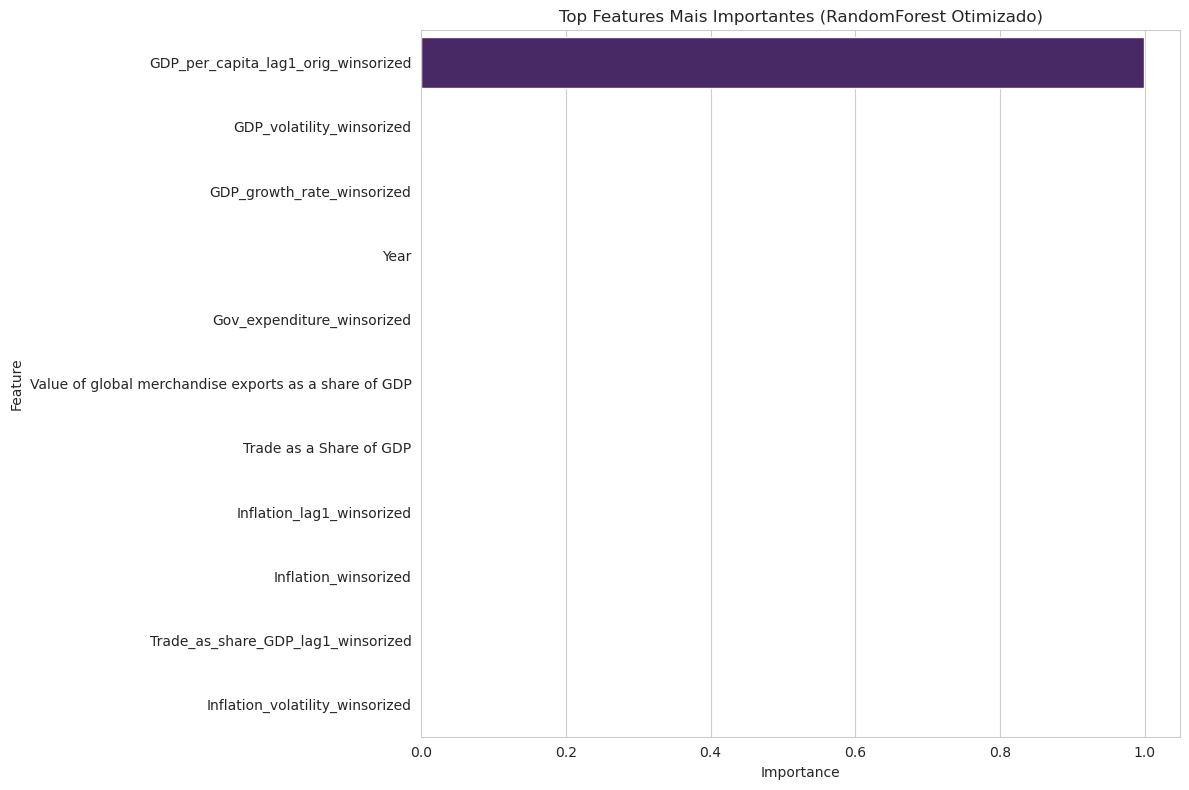

2025-05-25 22:40:28 - __main__ - 2625485089.py:1450 - INFO - 
--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS GRADIENT BOOSTING COM OPTUNA ---
2025-05-25 22:43:25 - __main__ - 2625485089.py:1464 - INFO - Melhores hiperparâmetros encontrados pelo Optuna para Gradient Boosting: {'max_features': 0.7, 'n_estimators': 167, 'learning_rate': 0.09777016204938101, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 1.0}
2025-05-25 22:43:25 - __main__ - 2625485089.py:1466 - INFO - 
--- TREINAMENTO DO MODELO GRADIENT BOOSTING FINAL COM MELHORES HIPERPARÂMETROS ---
2025-05-25 22:43:49 - __main__ - 2625485089.py:571 - INFO - GradientBoosting_Optuna - MAE Teste (Escala PIB Original): 419.97, MSE Teste: 10746551.16, R² Teste: 0.8682
2025-05-25 22:43:49 - __main__ - 2625485089.py:169 - INFO - 
--- GradientBoosting_Optuna: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
2025-05-25 22:43:49 - __main__ - 2625485089.py:170 - INFO - 
                  Entity  MAE_PIB_orig

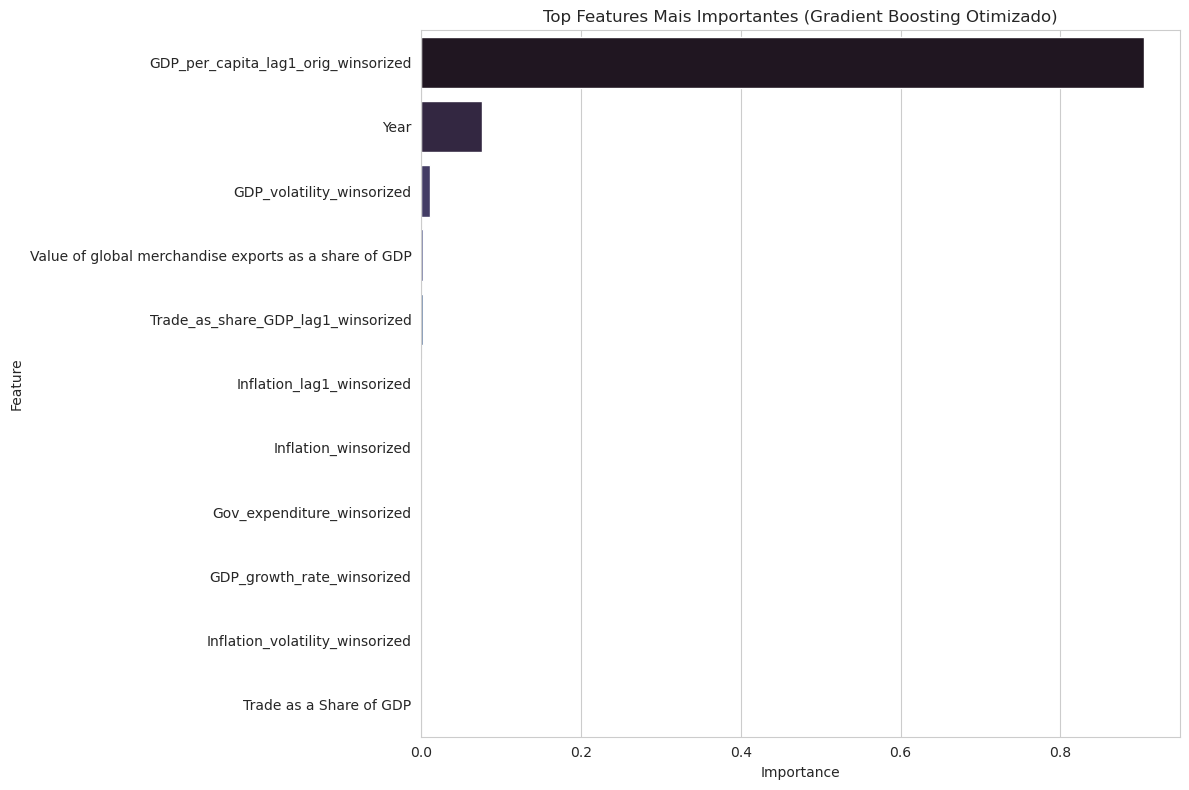

2025-05-25 22:43:50 - __main__ - 2625485089.py:1515 - INFO - 
Tamanhos FINAIS dos conjuntos de sequências (LSTM Keras):
2025-05-25 22:43:50 - __main__ - 2625485089.py:1516 - INFO -   Treino Num: (109174, 10, 11), Treino Entity: (109174, 1), Treino y: (109174, 1)
2025-05-25 22:43:50 - __main__ - 2625485089.py:1518 - INFO -   Val Num: (26901, 10, 11), Val Entity: (26901, 1), Val y: (26901, 1)
2025-05-25 22:43:50 - __main__ - 2625485089.py:1520 - INFO -   Teste Num: (9637, 10, 11), Teste Entity: (9637, 1), Teste y: (9637, 1)
2025-05-25 22:43:50 - __main__ - 2625485089.py:1535 - INFO - 
--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS LSTM (KERAS) COM OPTUNA (usando tf.data) ---
2025-05-26 00:04:45 - __main__ - 2625485089.py:1550 - INFO - Melhores hiperparâmetros encontrados pelo Optuna para LSTM (Keras): {'embedding_dim': 40, 'hidden_units': 128, 'num_layers': 1, 'learning_rate': 0.00020818215671793215, 'dropout_prob': 0.10108457913000687, 'l2_reg_strength': 1.6927076131285865e-05, 'batch_size

Epoch 1/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0408 - val_loss: 0.0187
Epoch 2/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0044 - val_loss: 0.0116
Epoch 3/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 0.0030 - val_loss: 0.0108
Epoch 4/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 5/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0022 - val_loss: 0.0106
Epoch 6/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 7/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 10/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 11/60
3411/3411 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 12/60
3411/34

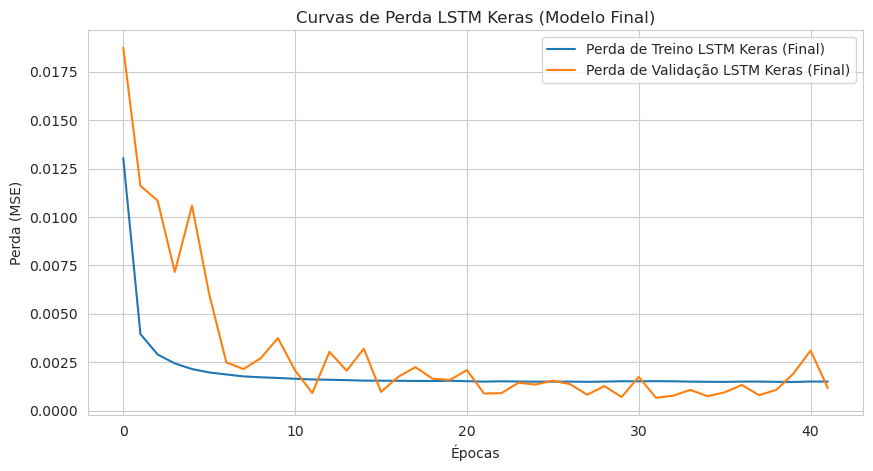

2025-05-26 00:23:47 - __main__ - 2625485089.py:1601 - INFO - 
--- AVALIAÇÃO LSTM (KERAS) FINAL NO CONJUNTO DE TESTE (usando tf.data) ---


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


2025-05-26 00:23:49 - __main__ - 2625485089.py:526 - INFO - LSTM Keras - Perda no Teste (mean_squared_error): 0.0011
2025-05-26 00:23:49 - __main__ - 2625485089.py:538 - INFO - LSTM Keras - MSE no Teste (Escala Original do PIB per capita): 937336.69
2025-05-26 00:23:49 - __main__ - 2625485089.py:539 - INFO - LSTM Keras - MAE no Teste (Escala Original do PIB per capita): 178.14
2025-05-26 00:23:49 - __main__ - 2625485089.py:540 - INFO - LSTM Keras - R² no Teste (Escala Original do PIB per capita): 0.9885
2025-05-26 00:23:49 - __main__ - 2625485089.py:169 - INFO - 
--- LSTM Keras: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---
2025-05-26 00:23:49 - __main__ - 2625485089.py:170 - INFO - 
                  Entity  MAE_PIB_original  Num_Samples
17                 Qatar      11150.324219           32
8      Equatorial Guinea       3477.850342           27
24  United Arab Emirates       2317.631104           19
19             Singapore       1493.730713           52
3         

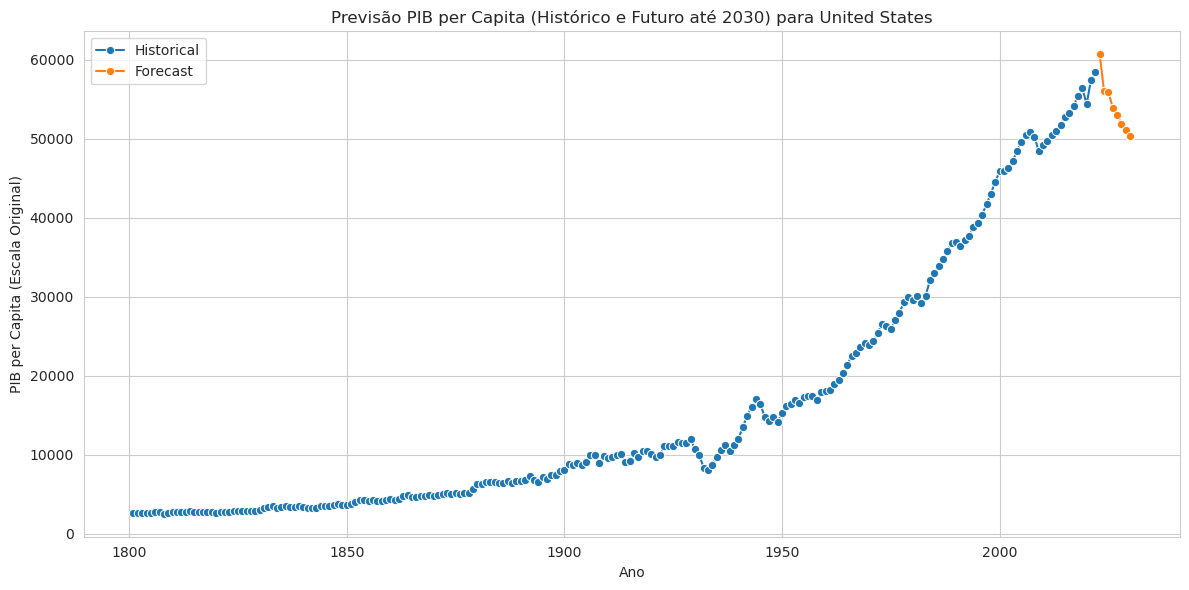

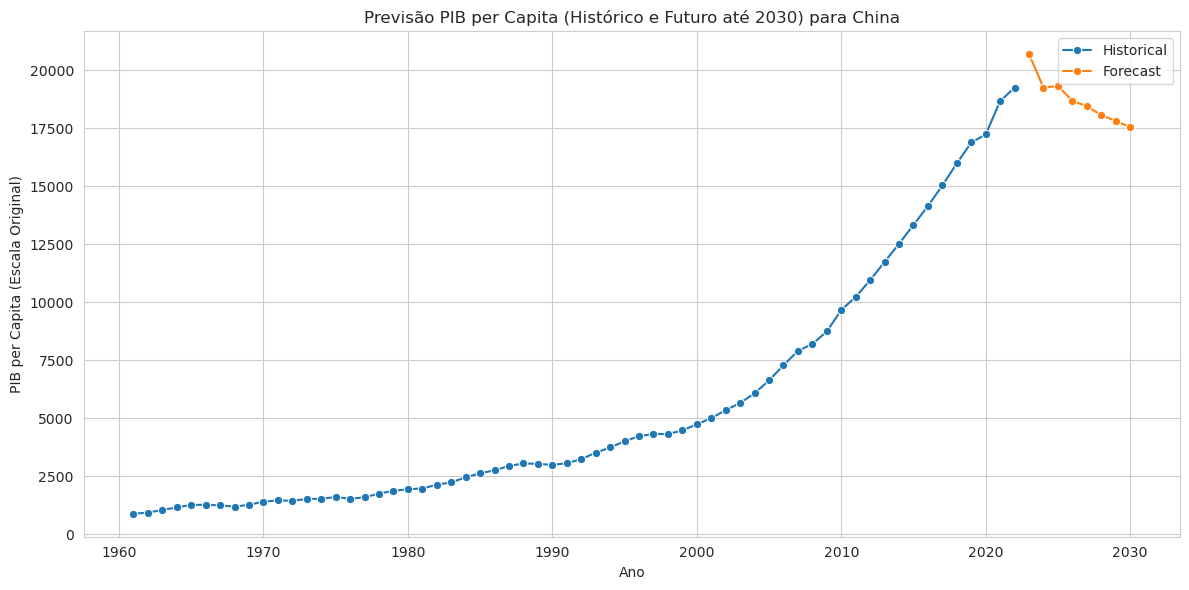

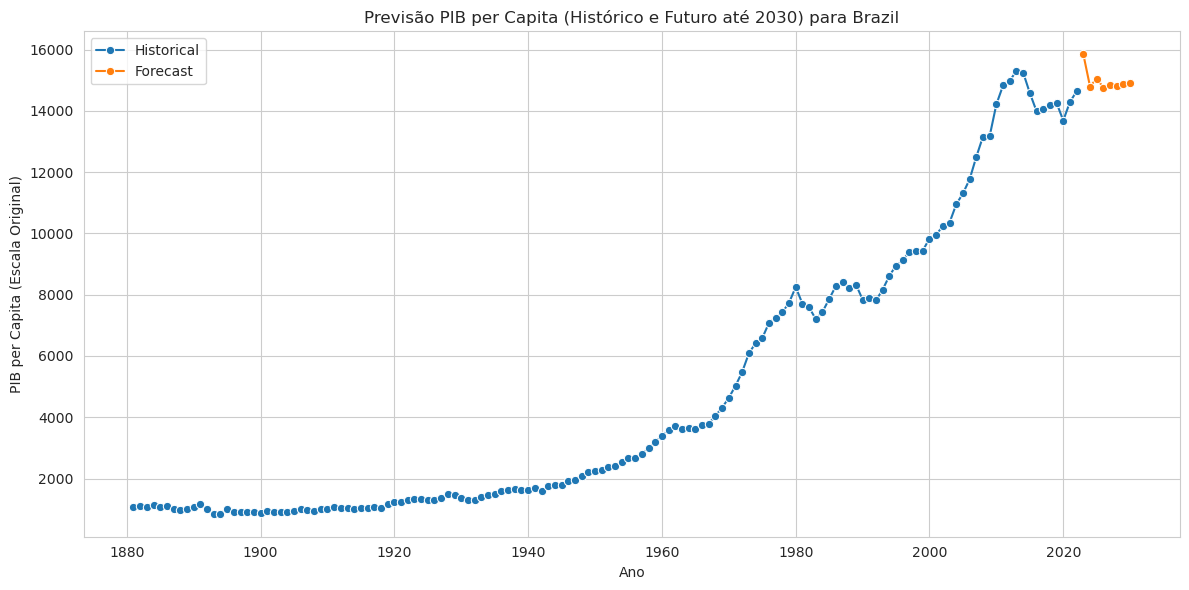

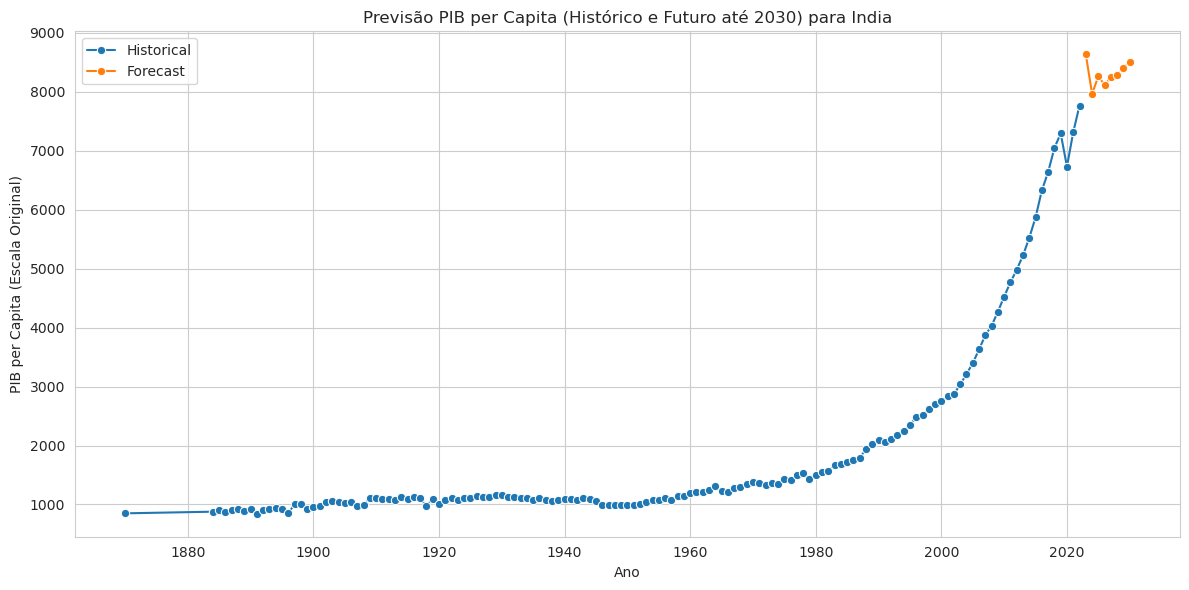

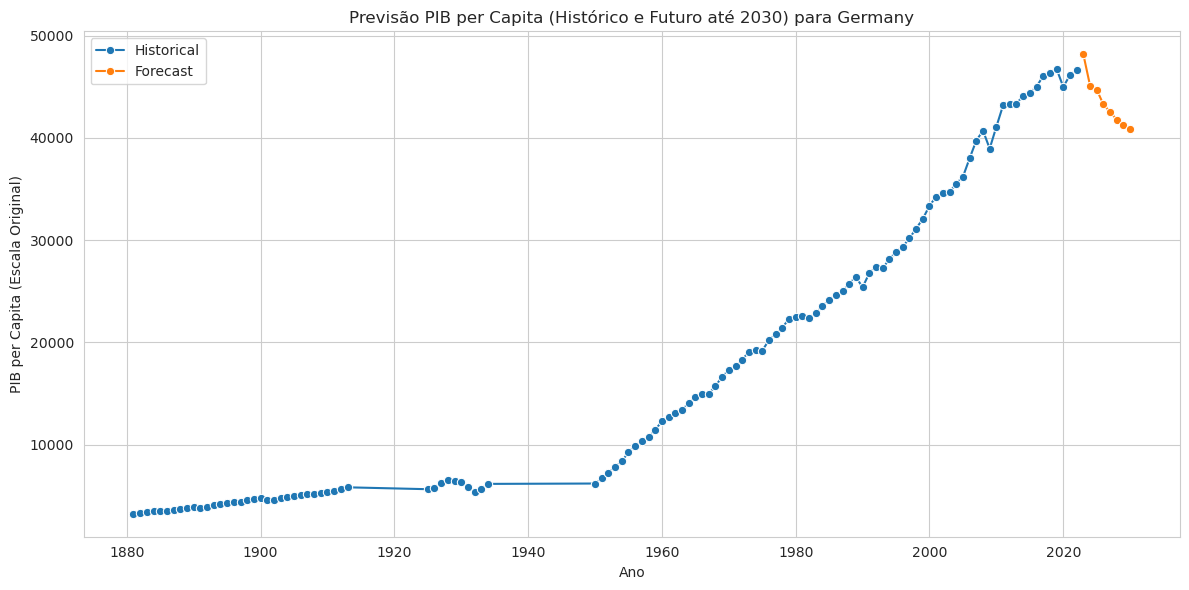

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression  # Para extrapolação de features
import os
import pickle
import gc  # Para coleta de lixo, se necessário

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna
import logging

# --- ETAPA 0: CONFIGURAÇÃO, CONSTANTES E FUNÇÕES AUXILIARES ---

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(filename)s:%(lineno)d - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

TFKerasPruningCallback_AVAILABLE = False
try:
    from optuna.integration import TFKerasPruningCallback as RealTFKerasPruningCallback

    TFKerasPruningCallback_AVAILABLE = True
    logger.info("optuna.integration.TFKerasPruningCallback importado com sucesso.")
except ImportError:
    logger.warning(
        "optuna.integration.TFKerasPruningCallback REAL não encontrado. Pruning de Keras trials via callback Optuna NÃO estará ativo.")


    class TFKerasPruningCallback(tf.keras.callbacks.Callback):  # Dummy callback
        def __init__(self, trial, monitor):
            super().__init__()
            # Não logar aqui para não poluir os logs se o logger do script principal estiver em DEBUG
            # O aviso principal já foi dado.

        def on_epoch_end(self, epoch, logs=None):
            pass  # Mock não funcional para pruning

optuna.logging.set_verbosity(optuna.logging.WARNING)


class ColNames:
    ENTITY = 'Entity'
    YEAR = 'Year'
    CODE = 'Code'
    GDP_PER_CAPITA = 'GDP per capita'
    GDP_PER_CAPITA_LOG = 'GDP_per_capita_log'
    INFLATION_ORIGINAL = '"Inflation, consumer prices (annual %)"'
    INFLATION_CLEANED = 'Inflation, consumer prices (annual %)'
    VALUE_GLOBAL_MERCHANDISE_EXPORTS = 'Value of global merchandise exports as a share of GDP'
    GOVERNMENT_EXPENDITURE = 'Government expenditure (% of GDP)'
    TRADE_AS_SHARE_OF_GDP = 'Trade as a Share of GDP'
    ENTITY_ENCODED = 'Entity_Encoded'
    GDP_PER_CAPITA_LAG1_ORIG = 'GDP_per_capita_lag1_orig'
    INFLATION_LAG1 = 'Inflation_lag1'
    TRADE_AS_SHARE_GDP_LAG1 = 'Trade_as_share_GDP_lag1'
    GDP_GROWTH_RATE = 'GDP_growth_rate'
    GDP_PER_CAPITA_MA3 = 'GDP_per_capita_MA3'
    GDP_PER_CAPITA_VOLATILITY3 = 'GDP_per_capita_volatility3'
    INFLATION_VOLATILITY3 = 'Inflation_volatility3'
    INFLATION_WINSORIZED = 'Inflation_winsorized'
    GDP_GROWTH_RATE_WINSORIZED = 'GDP_growth_rate_winsorized'
    GOV_EXPENDITURE_WINSORIZED = 'Gov_expenditure_winsorized'
    GDP_VOLATILITY_WINSORIZED = 'GDP_volatility_winsorized'
    INFLATION_VOLATILITY_WINSORIZED = 'Inflation_volatility_winsorized'
    INFLATION_LAG1_WINSORIZED = 'Inflation_lag1_winsorized'
    TRADE_AS_SHARE_GDP_LAG1_WINSORIZED = 'Trade_as_share_GDP_lag1_winsorized'
    GDP_PER_CAPITA_LAG1_ORIG_WINSORIZED = 'GDP_per_capita_lag1_orig_winsorized'
    YEAR_SIN = 'Year_sin'
    YEAR_COS = 'Year_cos'
    GDP_PER_CAPITA_LOG_LAG1 = 'GDP_per_capita_log_lag1'
    INTERACTION_LAGGDP_INFLATION = 'Interaction_LagGDP_Inflation'
    Y_TRUE_ACTUAL_PIB = 'y_true_actual_pib'
    Y_PRED_ACTUAL_PIB = 'y_pred_actual_pib'


try:
    tf.config.set_visible_devices([], 'GPU')
    logger.info("Usando dispositivo: CPU (TensorFlow) - GPUs desabilitadas programaticamente.")
except Exception as e:
    logger.warning(f"Não foi possível desabilitar GPUs programaticamente: {e}")
    logger.info("TensorFlow usará a configuração padrão de dispositivos.")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


# --- FUNÇÕES AUXILIARES ---
def normalize_features(df_train, list_df_to_transform, feature_list, scalers_dict, scaler_prefix=""):
    # ... (código mantido como antes)
    for col in feature_list:
        scaler_name = f"{scaler_prefix}_{col}"
        if col in df_train.columns and not df_train[col].isnull().all():
            scaler = StandardScaler()
            median_train_col = df_train[col].median()
            df_train[col] = scaler.fit_transform(df_train[[col]].fillna(median_train_col))
            scalers_dict[scaler_name] = scaler
            for i in range(len(list_df_to_transform)):
                df_transform = list_df_to_transform[i]
                if df_transform is not None and not df_transform.empty and col in df_transform.columns:
                    list_df_to_transform[i][col] = scaler.transform(df_transform[[col]].fillna(median_train_col))
                elif df_transform is not None and not df_transform.empty:
                    logger.warning(
                        f"Coluna '{col}' não encontrada no DataFrame de índice {i} para transformar com scaler '{scaler_name}'. Preenchendo com 0.")
                    list_df_to_transform[i][col] = 0
        elif col in df_train.columns:
            logger.warning(
                f"Coluna '{col}' é toda NaN no treino (prefixo '{scaler_prefix}'). Será preenchida com 0 em todos os DFs.")
            df_train[col] = 0
            for i in range(len(list_df_to_transform)):
                df_transform = list_df_to_transform[i]
                if df_transform is not None and not df_transform.empty:
                    list_df_to_transform[i][col] = 0
        else:
            logger.warning(
                f"Coluna '{col}' não encontrada no df_train (prefixo '{scaler_prefix}'). Será ignorada para normalização.")
    return [df_train] + list_df_to_transform, scalers_dict


def calculate_mae_per_entity(y_true_actual, y_pred_actual, entities_encoded, entity_encoder, model_name):
    # ... (código mantido como antes)
    mae_per_entity_df = pd.DataFrame()
    if entity_encoder is not None and entities_encoded is not None and len(entities_encoded) > 0 and \
            y_true_actual is not None and y_pred_actual is not None and \
            len(y_true_actual) == len(entities_encoded) and len(y_pred_actual) == len(entities_encoded):
        try:
            results_df = pd.DataFrame({
                ColNames.ENTITY_ENCODED: entities_encoded.flatten(),
                ColNames.Y_TRUE_ACTUAL_PIB: y_true_actual.flatten(),
                ColNames.Y_PRED_ACTUAL_PIB: y_pred_actual.flatten()
            })
            known_codes_in_encoder = entity_encoder.transform(entity_encoder.classes_)
            valid_codes_mask = np.isin(results_df[ColNames.ENTITY_ENCODED], known_codes_in_encoder)
            if not valid_codes_mask.all():
                unknown_codes_count = sum(~valid_codes_mask)
                unknown_entities_unique_count = results_df.loc[~valid_codes_mask, ColNames.ENTITY_ENCODED].nunique()
                logger.warning(
                    f"({model_name}): {unknown_codes_count} predições ({unknown_entities_unique_count} entidades únicas) "
                    f"referem-se a códigos de entidade no teste que não são conhecidos pelo entity_encoder. Serão ignorados.")
            results_df_valid = results_df[valid_codes_mask].copy()
            if not results_df_valid.empty:
                results_df_valid.loc[:, ColNames.ENTITY] = entity_encoder.inverse_transform(
                    results_df_valid[ColNames.ENTITY_ENCODED])
                mae_per_entity_list = []
                for entity_name, group in results_df_valid.groupby(ColNames.ENTITY):
                    mae_val = mean_absolute_error(group[ColNames.Y_TRUE_ACTUAL_PIB], group[ColNames.Y_PRED_ACTUAL_PIB])
                    mae_per_entity_list.append({
                        ColNames.ENTITY: entity_name,
                        'MAE_PIB_original': mae_val,
                        'Num_Samples': len(group)
                    })
                if mae_per_entity_list:
                    mae_per_entity_df = pd.DataFrame(mae_per_entity_list).sort_values(by='MAE_PIB_original',
                                                                                      ascending=False)
                    logger.info(f"\n--- {model_name}: Análise de Disparidade de Erro (MAE por Entidade no Teste) ---")
                    logger.info(f"\n{mae_per_entity_df.head(min(5, len(mae_per_entity_df)))}")
                    if len(mae_per_entity_df) > 10:
                        logger.info("...")
                        logger.info(f"\n{mae_per_entity_df.tail(min(5, len(mae_per_entity_df)))}")
            else:
                logger.warning(
                    f"({model_name}) Nenhum código de entidade válido para decodificar e calcular MAE por entidade.")
        except Exception as e:
            logger.error(f"Erro ao calcular MAE por entidade para {model_name}: {e}", exc_info=True)
    else:
        logger.warning(f"({model_name}) Dados insuficientes ou inconsistentes para calcular MAE por entidade.")
    return mae_per_entity_df


# --- ETAPA 1: PRÉ-PROCESSAMENTO DE DADOS --- (Mantida como antes)
def preprocess_data(file_path='data/gdp_per_capita.csv'):
    try:
        df = pd.read_csv(file_path)
        logger.info("--- Dados Originais Carregados com Sucesso (Pré-processamento) ---")
    except FileNotFoundError:
        logger.error(f"O ficheiro '{file_path}' não foi encontrado. Verifique o caminho e a estrutura de pastas.")
        return None
    if ColNames.INFLATION_ORIGINAL in df.columns:
        df = df.rename(columns={ColNames.INFLATION_ORIGINAL: ColNames.INFLATION_CLEANED})
    if ColNames.CODE in df.columns: df[ColNames.CODE] = df[ColNames.CODE].fillna('UNK')
    if ColNames.ENTITY in df.columns and ColNames.YEAR in df.columns:
        df = df.sort_values(by=[ColNames.ENTITY, ColNames.YEAR])
    if ColNames.GDP_PER_CAPITA in df.columns:
        df[ColNames.GDP_PER_CAPITA] = pd.to_numeric(df[ColNames.GDP_PER_CAPITA], errors='coerce')
        logger.info(f"Aplicando interpolação linear para '{ColNames.GDP_PER_CAPITA}' por entidade...")
        df[ColNames.GDP_PER_CAPITA] = df.groupby(ColNames.ENTITY, group_keys=False)[ColNames.GDP_PER_CAPITA].apply(
            lambda series: series.interpolate(method='linear', limit_direction='both'))
        if df[ColNames.GDP_PER_CAPITA].isnull().any():
            global_median_gdp = df[ColNames.GDP_PER_CAPITA].median()
            df[ColNames.GDP_PER_CAPITA] = df[ColNames.GDP_PER_CAPITA].fillna(
                global_median_gdp if not pd.isna(global_median_gdp) else 0)
            logger.info(
                f"NaNs restantes em '{ColNames.GDP_PER_CAPITA}' preenchidos com mediana global: {global_median_gdp if not pd.isna(global_median_gdp) else 0}")
    other_numerical_cols_to_impute = [
        ColNames.VALUE_GLOBAL_MERCHANDISE_EXPORTS,
        ColNames.GOVERNMENT_EXPENDITURE, ColNames.TRADE_AS_SHARE_OF_GDP, ColNames.INFLATION_CLEANED
    ]
    for col in other_numerical_cols_to_impute:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            group_median = df.groupby(ColNames.ENTITY, group_keys=False)[col].transform('median')
            df[col] = df[col].fillna(group_median)
            if df[col].isnull().any():
                global_median = df[col].median()
                df[col] = df[col].fillna(global_median if not pd.isna(global_median) else 0)
                logger.info(
                    f"NaNs restantes em '{col}' preenchidos com mediana global: {global_median if not pd.isna(global_median) else 0}")
        else:
            logger.warning(f"Coluna '{col}' não encontrada para imputação numérica.")
    if ColNames.YEAR in df.columns: df[ColNames.YEAR] = pd.to_numeric(df[ColNames.YEAR], errors='coerce').astype(
        'Int64')
    logger.info("--- Pré-processamento Concluído ---")
    return df


# --- ETAPA 2: ENGENHARIA DE FEATURES E TRATAMENTO (ANTES DA DIVISÃO DE DADOS) --- (Mantida como antes)
def initial_feature_engineering(df_processed):
    if df_processed is None: return None, None, None, None, None
    logger.info("\n--- INÍCIO DA ENGENHARIA DE FEATURES INICIAL ---")
    df = df_processed.sort_values(by=[ColNames.ENTITY, ColNames.YEAR]).reset_index(drop=True)
    if ColNames.GDP_PER_CAPITA in df.columns:
        df[ColNames.GDP_PER_CAPITA_LAG1_ORIG] = df.groupby(ColNames.ENTITY)[ColNames.GDP_PER_CAPITA].shift(1)
    else:
        df[ColNames.GDP_PER_CAPITA_LAG1_ORIG] = np.nan
    if ColNames.INFLATION_CLEANED in df.columns:
        df[ColNames.INFLATION_LAG1] = df.groupby(ColNames.ENTITY)[ColNames.INFLATION_CLEANED].shift(1)
    else:
        df[ColNames.INFLATION_LAG1] = np.nan
    if ColNames.TRADE_AS_SHARE_OF_GDP in df.columns:
        df[ColNames.TRADE_AS_SHARE_GDP_LAG1] = df.groupby(ColNames.ENTITY)[ColNames.TRADE_AS_SHARE_OF_GDP].shift(1)
    else:
        df[ColNames.TRADE_AS_SHARE_GDP_LAG1] = np.nan
    if ColNames.GDP_PER_CAPITA in df.columns:
        df[ColNames.GDP_GROWTH_RATE] = df.groupby(ColNames.ENTITY)[ColNames.GDP_PER_CAPITA].pct_change() * 100
        df[ColNames.GDP_PER_CAPITA_MA3] = df.groupby(ColNames.ENTITY)[ColNames.GDP_PER_CAPITA].rolling(window=3,
                                                                                                       min_periods=1).mean().reset_index(
            level=0, drop=True)
        df[ColNames.GDP_PER_CAPITA_VOLATILITY3] = df.groupby(ColNames.ENTITY)[ColNames.GDP_PER_CAPITA].rolling(window=3,
                                                                                                               min_periods=1).std().reset_index(
            level=0, drop=True)
    else:
        df[ColNames.GDP_GROWTH_RATE] = np.nan;
        df[ColNames.GDP_PER_CAPITA_MA3] = np.nan;
        df[ColNames.GDP_PER_CAPITA_VOLATILITY3] = np.nan
    if ColNames.INFLATION_CLEANED in df.columns:
        df[ColNames.INFLATION_VOLATILITY3] = df.groupby(ColNames.ENTITY)[ColNames.INFLATION_CLEANED].rolling(window=3,
                                                                                                             min_periods=1).std().reset_index(
            level=0, drop=True)
    else:
        df[ColNames.INFLATION_VOLATILITY3] = np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    critical_lag_cols_initial = [col for col in [ColNames.GDP_PER_CAPITA_LAG1_ORIG, ColNames.INFLATION_LAG1,
                                                 ColNames.TRADE_AS_SHARE_GDP_LAG1, ColNames.GDP_GROWTH_RATE] if
                                 col in df.columns]
    if critical_lag_cols_initial:
        df = df.dropna(subset=critical_lag_cols_initial).reset_index(drop=True)
        logger.info(f"Shape após dropna em lags/pct_change iniciais: {df.shape}")
    for vol_col in [col for col in [ColNames.GDP_PER_CAPITA_VOLATILITY3, ColNames.INFLATION_VOLATILITY3] if
                    col in df.columns]:
        df[vol_col] = df[vol_col].fillna(0)
    if ColNames.GDP_PER_CAPITA in df.columns:
        df[ColNames.GDP_PER_CAPITA_LOG] = np.log1p(df[ColNames.GDP_PER_CAPITA].clip(lower=0))
    else:
        df[ColNames.GDP_PER_CAPITA_LOG] = np.nan
    winsor_limits = (0.01, 0.01)
    cols_to_winsorize_map = {
        ColNames.INFLATION_CLEANED: ColNames.INFLATION_WINSORIZED,
        ColNames.GDP_GROWTH_RATE: ColNames.GDP_GROWTH_RATE_WINSORIZED,
        ColNames.GOVERNMENT_EXPENDITURE: ColNames.GOV_EXPENDITURE_WINSORIZED,
        ColNames.GDP_PER_CAPITA_VOLATILITY3: ColNames.GDP_VOLATILITY_WINSORIZED,
        ColNames.INFLATION_VOLATILITY3: ColNames.INFLATION_VOLATILITY_WINSORIZED,
        ColNames.INFLATION_LAG1: ColNames.INFLATION_LAG1_WINSORIZED,
        ColNames.TRADE_AS_SHARE_GDP_LAG1: ColNames.TRADE_AS_SHARE_GDP_LAG1_WINSORIZED,
        ColNames.GDP_PER_CAPITA_LAG1_ORIG: ColNames.GDP_PER_CAPITA_LAG1_ORIG_WINSORIZED
    }
    for original_col, new_col_name in cols_to_winsorize_map.items():
        if original_col in df.columns and df[original_col].notna().any():
            non_nan_data = df[original_col].dropna()
            if not non_nan_data.empty:
                if len(non_nan_data) > (1 / winsor_limits[0]) and len(non_nan_data) > (1 / winsor_limits[1]):
                    winsorized_data = winsorize(non_nan_data.to_numpy(), limits=winsor_limits)
                else:
                    winsorized_data = non_nan_data.to_numpy()
                df[new_col_name] = np.nan
                df.loc[non_nan_data.index, new_col_name] = winsorized_data
                median_val = df[new_col_name].median()
                df[new_col_name] = df[new_col_name].fillna(median_val if not pd.isna(median_val) else 0)
            else:
                df[new_col_name] = 0
        elif original_col not in df.columns:
            df[new_col_name] = 0
        else:
            df[new_col_name] = 0
    if ColNames.YEAR in df.columns and not df[ColNames.YEAR].empty:
        year_max_val = df[ColNames.YEAR].max()  # Renomeado para evitar conflito com a função max()
        if pd.notna(year_max_val) and year_max_val > 0:
            df[ColNames.YEAR_SIN] = np.sin(2 * np.pi * df[ColNames.YEAR] / year_max_val)
            df[ColNames.YEAR_COS] = np.cos(2 * np.pi * df[ColNames.YEAR] / year_max_val)
        else:
            df[ColNames.YEAR_SIN] = 0;
            df[ColNames.YEAR_COS] = 0
    else:
        df[ColNames.YEAR_SIN] = 0;
        df[ColNames.YEAR_COS] = 0
    target_col_log_local = ColNames.GDP_PER_CAPITA_LOG
    base_lstm_numerical_features = [
        ColNames.INFLATION_WINSORIZED, ColNames.INFLATION_LAG1_WINSORIZED,
        ColNames.TRADE_AS_SHARE_GDP_LAG1_WINSORIZED, ColNames.GDP_GROWTH_RATE_WINSORIZED,
        ColNames.GDP_VOLATILITY_WINSORIZED, ColNames.INFLATION_VOLATILITY_WINSORIZED,
        ColNames.GOV_EXPENDITURE_WINSORIZED, ColNames.YEAR_SIN, ColNames.YEAR_COS,
    ]
    base_lstm_numerical_features = [f for f in base_lstm_numerical_features if f in df.columns]
    ml_numerical_features = [
        ColNames.GDP_PER_CAPITA_LAG1_ORIG_WINSORIZED, ColNames.INFLATION_WINSORIZED, ColNames.INFLATION_LAG1_WINSORIZED,
        ColNames.TRADE_AS_SHARE_GDP_LAG1_WINSORIZED, ColNames.GDP_GROWTH_RATE_WINSORIZED,
        ColNames.GDP_VOLATILITY_WINSORIZED, ColNames.INFLATION_VOLATILITY_WINSORIZED,
        ColNames.GOV_EXPENDITURE_WINSORIZED, ColNames.YEAR,
        ColNames.VALUE_GLOBAL_MERCHANDISE_EXPORTS,
        ColNames.TRADE_AS_SHARE_OF_GDP
    ]
    ml_numerical_features = [f for f in ml_numerical_features if f in df.columns]
    if target_col_log_local not in df.columns or df[target_col_log_local].isnull().all():
        logger.error(f"Coluna alvo '{target_col_log_local}' está ausente ou toda NaN após engenharia inicial.")
        return None, [], "", None, []
    df_cleaned = df.dropna(subset=[target_col_log_local]).copy()
    df_for_ml = df.copy()
    cols_for_ml_dropna = [target_col_log_local] + [f for f in ml_numerical_features if f in df_for_ml.columns]
    df_for_ml = df_for_ml.dropna(subset=cols_for_ml_dropna).reset_index(drop=True)
    logger.info(f"Colunas base LSTM (antes de lag/interação pós-split): {base_lstm_numerical_features}")
    logger.info(f"Colunas ML: {ml_numerical_features}")
    logger.info(f"Alvo (Log): {target_col_log_local}")
    logger.info(f"Shape df_cleaned (base para LSTM, após dropna no alvo): {df_cleaned.shape}")
    logger.info(f"Shape df_for_ml (base para ML, após dropna no alvo e features ML): {df_for_ml.shape}")
    logger.info("--- Engenharia de Features Inicial Concluída ---")
    return df_cleaned, base_lstm_numerical_features, target_col_log_local, df_for_ml, ml_numerical_features


# --- ETAPA 3: PREPARAÇÃO DE DADOS PARA MODELOS (KERAS LSTM) ---
# ... (create_sequences_from_df_keras e create_tf_dataset mantidas como antes) ...
def create_sequences_from_df_keras(df, numerical_features, target_col, entity_col_encoded, sequence_length):
    X_seq_num, y_seq_target, entity_seq_codes_list = [], [], []
    if not numerical_features:
        logger.warning("Nenhuma feature numérica fornecida para create_sequences_from_df_keras.")
        return np.array([]).reshape(0, sequence_length, 0), np.array([]), np.array([]).reshape(-1, 1)
    actual_numerical_features = [f for f in numerical_features if isinstance(f, str) and f in df.columns]
    if not actual_numerical_features:
        logger.warning("Nenhuma feature numérica válida encontrada no DataFrame para create_sequences_from_df_keras.")
        return np.array([]).reshape(0, sequence_length, 0), np.array([]), np.array([]).reshape(-1, 1)
    unique_entities = df[entity_col_encoded].unique()
    for entity_code in unique_entities:
        entity_df = df[df[entity_col_encoded] == entity_code].copy()
        temp_entity_df = entity_df[actual_numerical_features + [target_col]].copy()
        for col in actual_numerical_features:
            temp_entity_df[col] = pd.to_numeric(temp_entity_df[col], errors='coerce')
        temp_entity_df = temp_entity_df.dropna(subset=actual_numerical_features + [target_col])
        if len(temp_entity_df) < sequence_length + 1: continue
        X_entity_features_np = temp_entity_df[actual_numerical_features].astype(np.float32).values
        y_entity_target_np = temp_entity_df[target_col].astype(np.float32).values
        for i in range(len(temp_entity_df) - sequence_length):
            X_seq_num.append(X_entity_features_np[i: i + sequence_length])
            entity_seq_codes_list.append(entity_code)
            y_seq_target.append(y_entity_target_np[i + sequence_length])
    if not X_seq_num:
        num_feat_dim = len(actual_numerical_features) if actual_numerical_features else 0
        return np.array([]).reshape(0, sequence_length, num_feat_dim), np.array([]).reshape(-1, 1), np.array(
            []).reshape(-1, 1)
    return np.array(X_seq_num, dtype=np.float32), np.array(entity_seq_codes_list, dtype=np.int64).reshape(-1,
                                                                                                          1), np.array(
        y_seq_target, dtype=np.float32).reshape(-1, 1)


def create_tf_dataset(X_numerical_seq, X_entity_seq, y_target_seq, batch_size, shuffle=False, drop_remainder=False):
    if X_numerical_seq.shape[0] == 0:
        logger.warning("Tentativa de criar tf.data.Dataset com X_numerical_seq vazio.")
        return None
    dataset = tf.data.Dataset.from_tensor_slices((
        {'numerical_input': X_numerical_seq, 'entity_input': X_entity_seq.reshape(-1, 1)},
        y_target_seq
    ))
    if shuffle:
        buffer_size = X_numerical_seq.shape[0]
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=SEED, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# --- ETAPA 4: DEFINIÇÃO E TREINAMENTO DE MODELOS (KERAS LSTM) --- (Mantidas como antes)
def create_lstm_model_keras(num_numerical_features, num_entities, embedding_dim, hidden_units, num_layers, dropout_prob,
                            sequence_length, l2_reg):
    numerical_input = layers.Input(shape=(sequence_length, num_numerical_features), name='numerical_input')
    entity_input = layers.Input(shape=(1,), name='entity_input')
    entity_embedding_layer = layers.Embedding(
        input_dim=num_entities, output_dim=embedding_dim, name='entity_embedding',
        embeddings_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None
    )(entity_input)
    entity_embedding_flattened = layers.Flatten()(entity_embedding_layer)
    entity_embedding_repeated = layers.RepeatVector(sequence_length)(entity_embedding_flattened)
    concatenated_features = layers.Concatenate(axis=-1, name='concatenate_features')(
        [numerical_input, entity_embedding_repeated])
    lstm_out = concatenated_features
    for i in range(num_layers):
        return_sequences_flag = True if i < num_layers - 1 else False
        lstm_layer_instance = layers.LSTM(
            hidden_units, return_sequences=return_sequences_flag, name=f'lstm_layer_{i + 1}',
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None,
            recurrent_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None
        )
        lstm_out = lstm_layer_instance(lstm_out)
        if i < num_layers - 1:
            lstm_out = layers.Dropout(dropout_prob, name=f'lstm_dropout_{i + 1}')(lstm_out)
    final_dropout = layers.Dropout(dropout_prob, name='final_dropout')(lstm_out)
    output = layers.Dense(1, name='output_layer', kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(
        final_dropout)
    model = keras.Model(inputs=[numerical_input, entity_input], outputs=output, name='lstm_forecast_model_keras')
    return model


def train_model_lstm_for_optuna_keras(trial, train_dataset_creator_args, val_dataset_creator_args,
                                      num_numerical_features, num_entities, sequence_length, optuna_epochs_lstm_trial):
    keras.backend.clear_session()
    embedding_dim = trial.suggest_categorical('embedding_dim', [10, 20, 30, 40, 50])
    hidden_units = trial.suggest_categorical('hidden_units', [32, 64, 128])
    num_layers_opt = trial.suggest_int('num_layers', 1, 2)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3)
    l2_reg_strength = trial.suggest_float('l2_reg_strength', 1e-6, 1e-4, log=True)
    batch_size_optuna = trial.suggest_categorical('batch_size', [32, 64])

    train_dataset = create_tf_dataset(
        train_dataset_creator_args['X_numerical_seq'],
        train_dataset_creator_args['X_entity_seq'],
        train_dataset_creator_args['y_target_seq'],
        batch_size=batch_size_optuna,
        shuffle=True,
        drop_remainder=True
    )
    val_dataset = None
    if val_dataset_creator_args and \
            val_dataset_creator_args['X_numerical_seq'].shape[0] > 0:
        val_dataset = create_tf_dataset(
            val_dataset_creator_args['X_numerical_seq'],
            val_dataset_creator_args['X_entity_seq'],
            val_dataset_creator_args['y_target_seq'],
            batch_size=batch_size_optuna,
            shuffle=False
        )
    if train_dataset is None:
        logger.error("Dataset de treino para Optuna LSTM não pôde ser criado (vazio). Retornando float('inf').")
        return float('inf')

    model = create_lstm_model_keras(
        num_numerical_features=num_numerical_features, num_entities=num_entities,
        embedding_dim=embedding_dim, hidden_units=hidden_units, num_layers=num_layers_opt,
        dropout_prob=dropout_prob, sequence_length=sequence_length, l2_reg=l2_reg_strength
    )
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    callbacks_for_optuna = []
    if TFKerasPruningCallback_AVAILABLE:
        logger.info("Adicionando RealTFKerasPruningCallback para o trial.")
        callbacks_for_optuna.append(RealTFKerasPruningCallback(trial, 'val_loss'))

    if val_dataset is None and TFKerasPruningCallback_AVAILABLE:
        logger.warning(
            "(Optuna LSTM): RealTFKerasPruningCallback configurado para 'val_loss', mas val_dataset não está disponível. Pruning pode não funcionar como esperado.")

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=optuna_epochs_lstm_trial,
        callbacks=callbacks_for_optuna, verbose=0
    )
    val_loss = history.history.get('val_loss', [float('inf')])[-1]
    if pd.isna(val_loss) or val_loss == float('inf'):
        val_loss = history.history.get('loss', [float('inf')])[-1]
        if pd.isna(val_loss): val_loss = float('inf')
    return val_loss


def train_final_lstm_model_keras(model, train_dataset, val_dataset, num_epochs, patience=12):
    callbacks_list = [
        EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath='models/best_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
    ]
    if val_dataset is None:
        logger.warning(
            "(Final LSTM): val_dataset não fornecido. Treinamento final sem validação para EarlyStopping/ModelCheckpoint baseados em val_loss.")
        callbacks_list = [
            EarlyStopping(monitor='loss', patience=patience, verbose=1, restore_best_weights=True),
            ModelCheckpoint(filepath='best_lstm_model_no_val.keras', monitor='loss', save_best_only=True, verbose=0)
        ]
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=callbacks_list, verbose=1
    )
    return model, history.history.get('loss', []), history.history.get('val_loss', [])


# --- ETAPA 5: AVALIAÇÃO DE MODELOS --- (Mantidas como antes)
def evaluate_model_lstm_keras(model, test_dataset, y_test_scaled_numpy, target_scaler=None, entity_encoder=None,
                              X_test_entity_numpy=None):
    if test_dataset is None:
        logger.warning("Conjunto de teste LSTM Keras (tf.data.Dataset) vazio ou não fornecido.")
        return np.array([]), np.array([]), float('nan'), float('nan'), float('nan'), float('nan'), pd.DataFrame()
    y_pred_scaled = model.predict(test_dataset)
    test_loss_metrics = model.evaluate(test_dataset, verbose=0)
    avg_test_loss_scaled = test_loss_metrics if isinstance(test_loss_metrics, float) else test_loss_metrics[0]
    logger.info(f"LSTM Keras - Perda no Teste ({model.loss}): {avg_test_loss_scaled:.4f}")
    mae_pib, mse_pib, r2_pib = float('nan'), float('nan'), float('nan')
    mae_per_entity_df_lstm = pd.DataFrame()
    if target_scaler is not None and y_test_scaled_numpy is not None and len(y_test_scaled_numpy) > 0 and \
            y_pred_scaled.shape[0] == y_test_scaled_numpy.shape[0]:
        y_true_log_original = target_scaler.inverse_transform(y_test_scaled_numpy.reshape(-1, 1))
        y_pred_log_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_true_actual_pib = np.expm1(y_true_log_original)
        y_pred_actual_pib = np.expm1(y_pred_log_original)
        mse_pib = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
        mae_pib = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
        r2_pib = r2_score(y_true_actual_pib, y_pred_actual_pib)
        logger.info(f"LSTM Keras - MSE no Teste (Escala Original do PIB per capita): {mse_pib:.2f}")
        logger.info(f"LSTM Keras - MAE no Teste (Escala Original do PIB per capita): {mae_pib:.2f}")
        logger.info(f"LSTM Keras - R² no Teste (Escala Original do PIB per capita): {r2_pib:.4f}")
        if X_test_entity_numpy is not None:
            mae_per_entity_df_lstm = calculate_mae_per_entity(
                y_true_actual_pib, y_pred_actual_pib, X_test_entity_numpy, entity_encoder, "LSTM Keras"
            )
        else:
            logger.warning("LSTM Keras: X_test_entity_numpy não fornecido. Não é possível calcular MAE por entidade.")
    else:
        logger.warning(
            "LSTM Keras: Target scaler não fornecido, y_test_scaled_numpy vazio ou predições desalinhadas. Métricas na escala original não calculadas.")
    return y_test_scaled_numpy, y_pred_scaled, avg_test_loss_scaled, mae_pib, mse_pib, r2_pib, mae_per_entity_df_lstm


def evaluate_model_generic(model_name, model, X_test, y_test_log_scaled, target_scaler, entity_encoder=None,
                           X_test_entities_encoded=None):
    if not isinstance(X_test, pd.DataFrame) or X_test.empty:
        logger.warning(f"{model_name} - Conjunto de teste vazio ou formato inválido. Avaliação ignorada.")
        return float('nan'), float('nan'), float('nan'), np.array([]), np.array([]), pd.DataFrame()
    y_pred_log_scaled = model.predict(X_test)
    mae, mse, r2 = float('nan'), float('nan'), float('nan')
    y_true_actual_pib, y_pred_actual_pib = np.array([]), np.array([])
    mae_per_entity_df_generic = pd.DataFrame()
    if target_scaler is not None and y_test_log_scaled is not None and len(y_test_log_scaled) > 0 and len(
            y_pred_log_scaled) == len(y_test_log_scaled):
        y_pred_log_original = target_scaler.inverse_transform(y_pred_log_scaled.reshape(-1, 1))
        y_true_log_original = target_scaler.inverse_transform(y_test_log_scaled.reshape(-1, 1))
        y_pred_actual_pib = np.expm1(y_pred_log_original)
        y_true_actual_pib = np.expm1(y_true_log_original)
        mae = mean_absolute_error(y_true_actual_pib, y_pred_actual_pib)
        mse = mean_squared_error(y_true_actual_pib, y_pred_actual_pib)
        r2 = r2_score(y_true_actual_pib, y_pred_actual_pib)
        logger.info(
            f"{model_name} - MAE Teste (Escala PIB Original): {mae:.2f}, MSE Teste: {mse:.2f}, R² Teste: {r2:.4f}")
        mae_per_entity_df_generic = calculate_mae_per_entity(
            y_true_actual_pib, y_pred_actual_pib, X_test_entities_encoded, entity_encoder, model_name
        )
    else:
        logger.warning(
            f"{model_name}: Target scaler não fornecido, y_test_log_scaled vazio ou predições desalinhadas. Métricas na escala original não calculadas.")
    return mae, mse, r2, y_true_actual_pib, y_pred_actual_pib, mae_per_entity_df_generic


# --- ETAPA 6: OTIMIZAÇÃO E TREINAMENTO DE MODELOS ML TRADICIONAIS --- (Corrigido max_features_choice)
def train_model_rf_for_optuna(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features_choice = trial.suggest_categorical('max_features_choice', ['sqrt', 'log2', 0.5, 0.7, None])

    if max_features_choice is None:
        max_features_resolved = None
    elif isinstance(max_features_choice,
                    str) and max_features_choice.lower() == 'none':  # Optuna às vezes retorna "None" como string
        max_features_resolved = None
    elif isinstance(max_features_choice, str) and max_features_choice in ['sqrt', 'log2']:
        max_features_resolved = max_features_choice
    elif isinstance(max_features_choice, float):  # Para valores como 0.5, 0.7
        max_features_resolved = max_features_choice
    else:  # Fallback inesperado
        max_features_resolved = 'sqrt'
        logger.warning(
            f"max_features_choice inesperado: {max_features_choice} (tipo: {type(max_features_choice)}). Usando 'sqrt'.")

    model_rf = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, max_features=max_features_resolved,
        random_state=SEED, n_jobs=-1, oob_score=False  # n_jobs=-1 para usar todos os processadores
    )
    y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.to_numpy()
    y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()
    model_rf.fit(X_train, y_train_np.ravel() if y_train_np.ndim > 1 else y_train_np)
    preds_val = model_rf.predict(X_val)
    mse_val = mean_squared_error(y_val_np.ravel() if y_val_np.ndim > 1 else y_val_np, preds_val)
    return mse_val


def train_model_gb_for_optuna(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('gb_n_estimators', 50, 250)
    learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.2, log=True)
    max_depth = trial.suggest_int('gb_max_depth', 3, 10)
    min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('gb_subsample', 0.6, 1.0, step=0.1)
    max_features_choice = trial.suggest_categorical('gb_max_features_choice', ['sqrt', 'log2', 0.5, 0.7, None])

    if max_features_choice is None:
        max_features_resolved = None
    elif isinstance(max_features_choice, str) and max_features_choice.lower() == 'none':
        max_features_resolved = None
    elif isinstance(max_features_choice, str) and max_features_choice in ['sqrt', 'log2']:
        max_features_resolved = max_features_choice
    elif isinstance(max_features_choice, float):
        max_features_resolved = max_features_choice
    else:
        max_features_resolved = 'sqrt'  # Default seguro
        logger.warning(
            f"gb_max_features_choice inesperado: {max_features_choice} (tipo: {type(max_features_choice)}). Usando 'sqrt'.")

    model_gb = GradientBoostingRegressor(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        subsample=subsample, max_features=max_features_resolved, random_state=SEED
        # GradientBoostingRegressor não tem n_jobs para paralelizar o treino de múltiplas árvores como o RandomForest.
        # A paralelização é mais complexa e geralmente não é um parâmetro direto.
    )
    y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.to_numpy()
    y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()
    model_gb.fit(X_train, y_train_np.ravel() if y_train_np.ndim > 1 else y_train_np)
    preds_val = model_gb.predict(X_val)
    mse_val = mean_squared_error(y_val_np.ravel() if y_val_np.ndim > 1 else y_val_np, preds_val)
    return mse_val


# --- ETAPA 7: PLOTS E ANÁLISES ADICIONAIS --- (Mantida como antes)
def plot_entity_predictions(df_full_data_for_entity_plot, entity_name, entity_encoder, target_col_log, target_scaler,
                            model_keras, sequence_length, numerical_features_for_lstm_plot, batch_size_predict=32):
    if not numerical_features_for_lstm_plot:
        logger.warning(f"Nenhuma feature LSTM fornecida para plotar predições para {entity_name}.")
        return
    if not target_scaler:
        logger.warning(f"Target scaler não fornecido para plotar predições para {entity_name}.")
        return
    if not model_keras:
        logger.warning(f"Modelo Keras não fornecido para plotar predições para {entity_name}.")
        return
    try:
        entity_code_encoded = entity_encoder.transform([entity_name])[0]
    except ValueError:
        logger.warning(f"Entidade '{entity_name}' não encontrada no encoder. Não é possível plotar.")
        return

    entity_df_full = df_full_data_for_entity_plot[
        df_full_data_for_entity_plot[ColNames.ENTITY_ENCODED] == entity_code_encoded].copy()
    if entity_df_full.empty:
        logger.warning(f"Nenhum dado encontrado para a entidade: {entity_name} no dataframe fornecido para plot.")
        return

    X_entity_num_seq, X_entity_code_seq, y_entity_true_scaled_seq = create_sequences_from_df_keras(
        entity_df_full, numerical_features_for_lstm_plot, target_col_log, ColNames.ENTITY_ENCODED, sequence_length
    )
    if X_entity_num_seq.shape[0] == 0:
        logger.warning(
            f"Não foi possível criar sequências para a entidade: {entity_name} (dados insuficientes ou NaNs).")
        return

    entity_dataset_to_predict = create_tf_dataset(
        X_entity_num_seq, X_entity_code_seq, y_entity_true_scaled_seq,
        batch_size=batch_size_predict,
        shuffle=False, drop_remainder=False
    )
    if entity_dataset_to_predict is None:
        logger.warning(f"Não foi possível criar tf.data.Dataset para predição da entidade: {entity_name}.")
        return

    y_entity_pred_scaled_seq = model_keras.predict(entity_dataset_to_predict)
    y_entity_true_original_seq = target_scaler.inverse_transform(y_entity_true_scaled_seq)
    y_entity_pred_original_seq = target_scaler.inverse_transform(y_entity_pred_scaled_seq)
    y_entity_true_actual_pib = np.expm1(y_entity_true_original_seq)
    y_entity_pred_actual_pib = np.expm1(y_entity_pred_original_seq)

    temp_entity_df_for_years = entity_df_full.copy()
    features_to_check_dropna = [f for f in numerical_features_for_lstm_plot if f in temp_entity_df_for_years.columns]
    temp_entity_df_for_years = temp_entity_df_for_years.dropna(subset=features_to_check_dropna + [target_col_log])
    plot_x_axis = np.arange(len(y_entity_true_actual_pib))
    xlabel_text = 'Índice Temporal'
    if ColNames.YEAR in temp_entity_df_for_years.columns:
        if len(temp_entity_df_for_years) >= len(y_entity_true_scaled_seq) + sequence_length:
            plot_x_axis = temp_entity_df_for_years[ColNames.YEAR].iloc[
                          sequence_length: sequence_length + len(y_entity_true_scaled_seq)].values
            xlabel_text = 'Ano'
        elif len(temp_entity_df_for_years[ColNames.YEAR]) >= len(y_entity_true_actual_pib):
            plot_x_axis = temp_entity_df_for_years[ColNames.YEAR].iloc[-len(y_entity_true_actual_pib):].values
            xlabel_text = 'Ano'
        else:
            logger.warning(f"Discrepância no alinhamento de anos para {entity_name}. Usando índices para o eixo X.")
    else:
        logger.warning(f"Coluna '{ColNames.YEAR}' não encontrada para plotar o eixo x.")

    if len(plot_x_axis) != len(y_entity_true_actual_pib):
        logger.warning(
            f"Número de pontos no eixo X ({len(plot_x_axis)}) não corresponde ao número de predições ({len(y_entity_true_actual_pib)}) para {entity_name}. Plot pode estar desalinhado.")
        min_len = min(len(plot_x_axis), len(y_entity_true_actual_pib))
        plot_x_axis = plot_x_axis[:min_len]
        y_entity_true_actual_pib = y_entity_true_actual_pib[:min_len]
        y_entity_pred_actual_pib = y_entity_pred_actual_pib[:min_len]
        if min_len == 0:
            logger.warning(f"Sem dados para plotar para {entity_name} após ajuste de desalinhamento.")
            return

    plt.figure(figsize=(12, 6))
    plt.plot(plot_x_axis, y_entity_true_actual_pib, label='PIB per Capita Real', marker='o', linestyle='-')
    plt.plot(plot_x_axis, y_entity_pred_actual_pib, label='PIB per Capita Previsto (LSTM Keras)', marker='x',
             linestyle='--')
    plt.title(f'Previsão PIB per Capita para: {entity_name}')
    plt.xlabel(xlabel_text)
    plt.ylabel('PIB per Capita (Escala Original)')
    plt.legend();
    plt.grid(True);
    plt.tight_layout();
    plt.show()


# --- NOVAS FUNÇÕES PARA PREVISÃO DE LONGO PRAZO ---
def project_exogenous_features(df_entity_hist, exog_feature_names, future_years, last_known_year):
    """
    Projeta features exógenas para anos futuros usando extrapolação linear simples
    baseada nos últimos N_YEARS_FOR_TREND anos, ou forward fill se não houver dados suficientes.
    """
    N_YEARS_FOR_TREND = 5
    projected_features = pd.DataFrame(index=future_years)
    projected_features.index.name = ColNames.YEAR

    for feature_name in exog_feature_names:
        if feature_name not in df_entity_hist.columns:
            logger.warning(
                f"Feature exógena '{feature_name}' não encontrada no histórico da entidade. Preenchendo com 0 para o futuro.")
            projected_features[feature_name] = 0
            continue

        # Usar dados históricos até o last_known_year para a tendência
        historical_feature_series = df_entity_hist[df_entity_hist[ColNames.YEAR] <= last_known_year][
            [ColNames.YEAR, feature_name]].dropna()

        if len(historical_feature_series) < 2:  # Não há dados suficientes para uma tendência
            last_value = historical_feature_series[feature_name].iloc[-1] if not historical_feature_series.empty else 0
            logger.info(
                f"Poucos dados para tendência de '{feature_name}'. Usando último valor conhecido: {last_value} (ou 0).")
            projected_features[feature_name] = last_value
        else:
            # Pegar os últimos N_YEARS_FOR_TREND para a regressão linear
            trend_data = historical_feature_series.tail(N_YEARS_FOR_TREND)
            if len(trend_data) < 2:  # Ainda poucos dados mesmo após tail
                last_value = historical_feature_series[feature_name].iloc[-1]
                logger.info(
                    f"Poucos dados para tendência de '{feature_name}' após tail({N_YEARS_FOR_TREND}). Usando último valor: {last_value}.")
                projected_features[feature_name] = last_value
            else:
                X_trend = trend_data[[ColNames.YEAR]].values
                y_trend = trend_data[feature_name].values

                model_trend = LinearRegression()
                model_trend.fit(X_trend, y_trend)

                future_years_reshaped = np.array(future_years).reshape(-1, 1)
                projected_values = model_trend.predict(future_years_reshaped)
                projected_features[feature_name] = projected_values
                logger.debug(
                    f"Feature '{feature_name}' projetada usando tendência linear para os anos {future_years[0]}-{future_years[-1]}.")

    # Adicionar features cíclicas do ano
    if not projected_features.empty:
        max_hist_year = df_entity_hist[ColNames.YEAR].max()  # Usar o máximo ano histórico como referência para ciclo
        projected_features[ColNames.YEAR_SIN] = np.sin(2 * np.pi * projected_features.index / max_hist_year)
        projected_features[ColNames.YEAR_COS] = np.cos(2 * np.pi * projected_features.index / max_hist_year)

    return projected_features


def forecast_gdp_iterative(model, initial_full_history_df, entity_code_encoded,
                           sequence_length, n_future_years_to_predict,
                           target_col_log, base_lstm_numerical_features_names,
                           interaction_feature_name, lag_target_col_name,
                           scalers, entity_embedding_dim_for_model):
    """
    Realiza previsão iterativa do PIB per capita (log-transformado e normalizado).
    Retorna uma série de previsões log-normalizadas.
    """
    # Garantir que initial_full_history_df está ordenado por ano
    entity_history = initial_full_history_df[
        initial_full_history_df[ColNames.ENTITY_ENCODED] == entity_code_encoded].sort_values(by=ColNames.YEAR)

    if entity_history.empty:
        logger.warning(f"Histórico vazio para entidade {entity_code_encoded}. Não é possível prever.")
        return pd.Series(dtype=float)

    last_known_year = entity_history[ColNames.YEAR].max()
    future_years = list(range(last_known_year + 1, last_known_year + 1 + n_future_years_to_predict))

    # Projetar features exógenas (excluindo lags do alvo e interações que serão calculadas iterativamente)
    # `base_lstm_numerical_features_names` já deve conter as features corretas (winsorizadas, etc.)
    # mas não o lag do alvo ou a interação.
    exog_features_to_project = [
        f for f in base_lstm_numerical_features_names
        if f not in [lag_target_col_name, interaction_feature_name, ColNames.YEAR_SIN, ColNames.YEAR_COS]
        # Year sin/cos são calculados em project_exogenous_features
    ]

    # As features em entity_history já devem estar normalizadas (exceto o alvo)
    # Se project_exogenous_features retornar valores não normalizados, eles precisarão ser normalizados aqui.
    # Por simplicidade, assumimos que project_exogenous_features lida com a escala correta
    # ou que as features projetadas (tendências) não precisam da mesma normalização exata que as históricas.
    # Para uma abordagem mais robusta, os scalers das features exógenas também precisariam ser considerados.
    # Alternativa: projetar na escala original e depois normalizar.
    # Para esta implementação: projetamos e usamos como está, e normalizamos as cíclicas do ano.

    # Criar DataFrame com histórico normalizado das features exógenas para a projeção
    # `entity_history` já tem as features normalizadas (exceto o target_col_log)
    # Se `project_exogenous_features` precisasse de features não normalizadas, passaríamos um df diferente.
    df_history_for_exog_projection = entity_history.copy()

    # Desnormalizar features exógenas antes de projetar, se os scalers existirem
    # e se a projeção for melhor na escala original.
    # Por ora, vamos projetar na escala normalizada para simplificar (assumindo que a tendência é estável nessa escala)
    # Ou, melhor: projetar na escala original se possível, depois normalizar.
    # No entanto, os scalers são para 'lstm_Inflation_winsorized' etc. e não para as colunas originais antes de winsorizar.
    # Decisão: projetar e depois normalizar se o scaler existir.
    # Melhor ainda: project_exogenous_features pode receber os scalers para aplicar a transformação inversa, projetar, e transformar de volta.
    # Por ora, vamos manter simples: projetar e usar como está, e normalizar sin/cos.

    projected_exog_df = project_exogenous_features(df_history_for_exog_projection, exog_features_to_project,
                                                   future_years, last_known_year)

    # Normalizar as features projetadas se os scalers existirem
    for col in projected_exog_df.columns:
        scaler_name_lstm = f"lstm_{col}"  # Assumindo que as features projetadas têm o mesmo nome base
        if scaler_name_lstm in scalers:
            # Reshape para 2D array, pois StandardScaler espera isso
            col_data_reshaped = projected_exog_df[col].values.reshape(-1, 1)
            projected_exog_df[col] = scalers[scaler_name_lstm].transform(col_data_reshaped)
        elif col not in [ColNames.YEAR_SIN, ColNames.YEAR_COS]:  # Não logar para sin/cos que são calculados diretamente
            logger.warning(
                f"Scaler '{scaler_name_lstm}' não encontrado para a feature exógena projetada '{col}'. Usando valor projetado diretamente.")

    # Preparar a sequência de input inicial
    # Deve conter as `final_lstm_numerical_features_for_model_global`
    # E o target_col_log já normalizado.
    # `final_lstm_numerical_features_for_model_global` inclui o lag do alvo e a interação.

    current_sequence_df = entity_history.sort_values(by=ColNames.YEAR).tail(sequence_length)

    # Verificar se temos features suficientes para a sequência inicial
    # `final_lstm_numerical_features_for_model_global` é a lista de todas as features que o modelo espera
    required_cols_for_sequence = final_lstm_numerical_features_for_model_global
    if not all(col in current_sequence_df.columns for col in required_cols_for_sequence):
        missing_cols = [col for col in required_cols_for_sequence if col not in current_sequence_df.columns]
        logger.error(
            f"Entidade {entity_code_encoded}: Colunas faltando para sequência inicial: {missing_cols}. Não é possível prever.")
        return pd.Series(dtype=float)

    if len(current_sequence_df) < sequence_length:
        logger.warning(
            f"Entidade {entity_code_encoded}: Histórico insuficiente ({len(current_sequence_df)} pontos) para formar sequência inicial de tamanho {sequence_length}. Não é possível prever.")
        return pd.Series(dtype=float)

    predictions_log_scaled = []

    for year_to_predict in future_years:
        # Preparar input para o modelo: (1, sequence_length, num_features)
        # As features em current_sequence_df já devem estar normalizadas e na ordem correta.
        input_numerical_features = current_sequence_df[final_lstm_numerical_features_for_model_global].values
        input_numerical_features_reshaped = input_numerical_features.reshape(1, sequence_length, -1).astype(np.float32)

        # Input da entidade (código encodado)
        entity_input_for_model = np.array([[entity_code_encoded]], dtype=np.int64)

        # Fazer a predição
        pred_log_scaled = \
        model.predict({'numerical_input': input_numerical_features_reshaped, 'entity_input': entity_input_for_model},
                      verbose=0)[0, 0]
        predictions_log_scaled.append(pred_log_scaled)

        # Construir a próxima linha de dados para adicionar à sequência
        # Esta nova linha representará o ano `year_to_predict`
        new_row_data = {ColNames.YEAR: year_to_predict, ColNames.ENTITY_ENCODED: entity_code_encoded}

        # Adicionar features exógenas projetadas para `year_to_predict`
        if year_to_predict in projected_exog_df.index:
            for exog_feat in projected_exog_df.columns:  # Inclui sin/cos do ano
                new_row_data[exog_feat] = projected_exog_df.loc[year_to_predict, exog_feat]
        else:  # Fallback se algo der errado com a projeção do ano
            logger.warning(f"Projeção exógena para o ano {year_to_predict} não encontrada. Usando zeros.")
            for exog_feat in exog_features_to_project + [ColNames.YEAR_SIN, ColNames.YEAR_COS]:
                new_row_data[exog_feat] = 0

        # Adicionar o target_col_log previsto (que é o GDP_per_capita_log_scaled)
        new_row_data[target_col_log] = pred_log_scaled

        # Criar features dependentes do lag do alvo e interação para a nova linha
        # O lag do alvo para year_to_predict é o valor do alvo do ano anterior (que pode ser uma predição anterior ou histórico)
        if not current_sequence_df.empty:
            # Lag do alvo (GDP_per_capita_log_lag1)
            new_row_data[lag_target_col_name] = current_sequence_df[target_col_log].iloc[-1]

            # Interação (Interaction_LagGDP_Inflation)
            # Precisamos da inflação winsorizada para year_to_predict (que deve estar em new_row_data)
            # e do lag do GDP que acabamos de calcular.
            if ColNames.INFLATION_WINSORIZED in new_row_data and lag_target_col_name in new_row_data:
                new_row_data[interaction_feature_name] = new_row_data[lag_target_col_name] * new_row_data[
                    ColNames.INFLATION_WINSORIZED]
            else:
                new_row_data[interaction_feature_name] = 0  # Ou alguma outra imputação
                logger.warning(
                    f"Não foi possível calcular {interaction_feature_name} para {year_to_predict} devido a features ausentes na new_row_data.")
        else:  # Não deveria acontecer se len(current_sequence_df) >= sequence_length
            new_row_data[lag_target_col_name] = 0
            new_row_data[interaction_feature_name] = 0

        # Garantir que todas as colunas esperadas pelo modelo estão presentes
        for f_col_model in final_lstm_numerical_features_for_model_global:
            if f_col_model not in new_row_data:
                logger.warning(
                    f"Feature esperada pelo modelo '{f_col_model}' não foi gerada para o ano {year_to_predict}. Preenchendo com 0.")
                new_row_data[f_col_model] = 0

        new_row_df = pd.DataFrame([new_row_data])

        # Atualizar current_sequence_df: remover a linha mais antiga e adicionar a nova
        current_sequence_df = pd.concat([current_sequence_df.iloc[1:], new_row_df], ignore_index=True)

    return pd.Series(predictions_log_scaled, index=future_years)


# --- BLOCO PRINCIPAL DE EXECUÇÃO ---
if __name__ == '__main__':
    DATA_DIR = 'data'
    CACHE_DIR = os.path.join(DATA_DIR, 'cache')
    DF_RAW_CACHE_PATH = os.path.join(CACHE_DIR, 'df_raw_processed.parquet')
    FEATURE_ENGINEERED_CACHE_PATH = os.path.join(CACHE_DIR, 'feature_engineered_data.pkl')
    FORECAST_OUTPUT_PATH = os.path.join(DATA_DIR, 'gdp_forecast_to_2030.csv')

    if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)
    if not os.path.exists(CACHE_DIR): os.makedirs(CACHE_DIR)

    DEVELOPMENT_MODE = False  # << DEFINA COMO False PARA EXECUÇÃO COMPLETA E GERAÇÃO DE GRÁFICOS >>
    SAMPLING_FRACTION = 0.1  # Reduzido para desenvolvimento ainda mais rápido
    USE_CACHE = True
    FORCE_REPROCESS_RAW = False
    FORCE_REPROCESS_FEATURES = False
    PERFORM_LONG_TERM_FORECAST = True  # Flag para ativar a previsão até 2030
    FORECAST_UNTIL_YEAR = 2030

    # Comentário sobre Otimização de Performance:
    # - TensorFlow tenta usar múltiplos cores. GPUs foram desabilitadas programaticamente.
    # - Modelos Scikit-learn (RF, GB) usam n_jobs=-1 (verifique nos hiperparâmetros) para paralelização.
    # - Optuna: study.optimize(..., n_jobs=...) pode paralelizar trials. Atualmente n_jobs=1.
    #   Aumentar n_jobs pode acelerar a busca, mas requer cuidado com recursos e serialização.
    # - Eficiência de Memória:
    #   - Considere revisar dtypes de DataFrames para usar tipos menores (e.g., float32) se a precisão permitir.
    #   - Use `del dataframe_grande` e `gc.collect()` após o uso de DataFrames grandes intermediários, se a memória for um problema.
    #   - O pipeline tf.data já ajuda com a eficiência de memória para o LSTM.

    if DEVELOPMENT_MODE:
        logger.info(">>> MODO DE DESENVOLVIMENTO ATIVO <<<")
        OPTUNA_N_TRIALS_ML = 2
        OPTUNA_N_TRIALS_LSTM = 2
        OPTUNA_EPOCHS_LSTM_TRIAL = 2
        FINAL_MODEL_EPOCHS_LSTM = 3
        FINAL_MODEL_PATIENCE_LSTM = 1
        PERFORM_LONG_TERM_FORECAST = True  # Pode querer testar a lógica de forecast mesmo em dev mode
    else:
        logger.info(">>> MODO DE PRODUÇÃO/COMPLETO ATIVO <<<")
        OPTUNA_N_TRIALS_ML = 15
        OPTUNA_N_TRIALS_LSTM = 20
        OPTUNA_EPOCHS_LSTM_TRIAL = 15
        FINAL_MODEL_EPOCHS_LSTM = 60
        FINAL_MODEL_PATIENCE_LSTM = 10

    SEQUENCE_LENGTH = 10

    df_raw = None
    if USE_CACHE and not FORCE_REPROCESS_RAW and os.path.exists(DF_RAW_CACHE_PATH):
        try:
            df_raw = pd.read_parquet(DF_RAW_CACHE_PATH)
            logger.info(f"df_raw carregado do cache: {DF_RAW_CACHE_PATH}")
        except Exception as e:
            logger.warning(f"Falha ao carregar df_raw do cache: {e}. Reprocessando...")
            df_raw = None

    if df_raw is None:
        df_raw_original_path = os.path.join(DATA_DIR, 'gdp_per_capita.csv')
        df_raw = preprocess_data(file_path=df_raw_original_path)
        if df_raw is not None and not df_raw.empty:
            try:
                df_raw.to_parquet(DF_RAW_CACHE_PATH)
                logger.info(f"df_raw salvo no cache: {DF_RAW_CACHE_PATH}")
            except Exception as e:
                logger.error(f"Falha ao salvar df_raw no cache: {e}")
        elif df_raw is None:
            logger.error("preprocess_data() retornou None. Não é possível continuar.")
            # import sys; sys.exit() # Descomentar para sair se for crítico

    if DEVELOPMENT_MODE and df_raw is not None and not df_raw.empty:
        logger.info(f"MODO DE DESENVOLVIMENTO: Amostrando {SAMPLING_FRACTION * 100:.0f}% das entidades de df_raw.")
        if ColNames.ENTITY in df_raw.columns:
            all_entities = df_raw[ColNames.ENTITY].unique()
            if len(all_entities) > 1:
                num_entities_to_sample = max(1, int(len(all_entities) * SAMPLING_FRACTION))
                np.random.seed(SEED)
                sampled_entities = np.random.choice(all_entities, size=num_entities_to_sample, replace=False)
                df_raw = df_raw[df_raw[ColNames.ENTITY].isin(sampled_entities)].copy()
                logger.info(
                    f"Amostradas {len(sampled_entities)} entidades de {len(all_entities)} totais. Novo shape df_raw: {df_raw.shape}")
                FORCE_REPROCESS_FEATURES = True
                logger.info("Amostragem de df_raw realizada, forçando reprocessamento de features.")
            else:
                logger.info(
                    "Apenas uma entidade presente ou nenhuma em df_raw, não foi possível amostrar por entidades.")
        else:
            logger.warning(
                f"Coluna '{ColNames.ENTITY}' não encontrada em df_raw. Não é possível amostrar por entidades.")

    df_processed_initial, base_lstm_numerical_features, target_col_log_global, \
        df_ml_initial, ml_numerical_features = [None] * 5
    cache_payload_exists = os.path.exists(FEATURE_ENGINEERED_CACHE_PATH)

    if USE_CACHE and not FORCE_REPROCESS_FEATURES and cache_payload_exists:
        try:
            with open(FEATURE_ENGINEERED_CACHE_PATH, 'rb') as f:
                cached_data = pickle.load(f)
            df_processed_initial = cached_data['df_processed_initial']
            base_lstm_numerical_features = cached_data['base_lstm_numerical_features']
            target_col_log_global = cached_data['target_col_log_global']
            df_ml_initial = cached_data['df_ml_initial']
            ml_numerical_features = cached_data['ml_numerical_features']
            logger.info(f"Dados de engenharia de features carregados do cache: {FEATURE_ENGINEERED_CACHE_PATH}")
            if df_raw is not None and not df_raw.empty and \
                    df_processed_initial is not None and not df_processed_initial.empty and \
                    ColNames.ENTITY in df_raw.columns and ColNames.ENTITY in df_processed_initial.columns:
                if set(df_raw[ColNames.ENTITY].unique()) != set(df_processed_initial[ColNames.ENTITY].unique()):
                    logger.warning(
                        "Cache de features parece ser de um conjunto de entidades diferente do df_raw atual (devido à amostragem). Forçando reprocessamento de features.")
                    FORCE_REPROCESS_FEATURES = True
                    df_processed_initial = None
            elif df_raw is None or df_raw.empty:
                logger.error("df_raw está vazio ou é None, não é possível validar ou usar cache de features.")
                FORCE_REPROCESS_FEATURES = True
                df_processed_initial = None
        except Exception as e:
            logger.warning(f"Falha ao carregar dados de engenharia de features do cache: {e}. Reprocessando...")
            df_processed_initial = None

    if df_processed_initial is None or FORCE_REPROCESS_FEATURES:
        if df_raw is not None and not df_raw.empty:
            logger.info("Executando initial_feature_engineering...")
            df_processed_initial, base_lstm_numerical_features, target_col_log_global, \
                df_ml_initial, ml_numerical_features = initial_feature_engineering(df_raw)
            if df_processed_initial is not None:
                try:
                    with open(FEATURE_ENGINEERED_CACHE_PATH, 'wb') as f:
                        pickle.dump({
                            'df_processed_initial': df_processed_initial,
                            'base_lstm_numerical_features': base_lstm_numerical_features,
                            'target_col_log_global': target_col_log_global,
                            'df_ml_initial': df_ml_initial,
                            'ml_numerical_features': ml_numerical_features
                        }, f)
                    logger.info(f"Dados de engenharia de features salvos no cache: {FEATURE_ENGINEERED_CACHE_PATH}")
                except Exception as e:
                    logger.error(f"Falha ao salvar dados de engenharia de features no cache: {e}")
        elif df_raw is None or df_raw.empty:
            logger.error("df_raw é None ou está vazio. Não é possível executar initial_feature_engineering.")
            # import sys; sys.exit() # Descomentar para sair se for crítico

    trained_final_lstm_model_keras = None  # Será o modelo treinado
    final_lstm_numerical_features_for_model_global = []  # Definido após normalização e criação de lags LSTM
    scalers_global = {}  # Dicionário para armazenar todos os scalers
    entity_encoder_global = None  # Será o LabelEncoder treinado
    # target_col_log_global já foi definido (do cache ou de initial_feature_engineering)
    df_test_lstm_processed_global = pd.DataFrame()  # Para plots de entidade

    # Prosseguir apenas se df_processed_initial e target_col_log_global forem válidos
    if df_raw is not None and not df_raw.empty and \
            df_processed_initial is not None and not df_processed_initial.empty and \
            target_col_log_global and target_col_log_global in df_processed_initial and not df_processed_initial[
        target_col_log_global].isnull().all() and \
            df_ml_initial is not None:

        entity_encoder_global = LabelEncoder()
        if ColNames.ENTITY in df_processed_initial.columns and df_processed_initial[ColNames.ENTITY].nunique() > 0:
            df_processed_initial[ColNames.ENTITY_ENCODED] = entity_encoder_global.fit_transform(
                df_processed_initial[ColNames.ENTITY])
            num_unique_entities = len(entity_encoder_global.classes_)
            logger.info(
                f"\nNúmero de entidades únicas (LabelEncoder): {num_unique_entities} de {df_processed_initial[ColNames.ENTITY].nunique()} entidades originais no df_processed_initial.")
        else:
            logger.error(
                f"Coluna '{ColNames.ENTITY}' ausente ou sem valores únicos em df_processed_initial. Não é possível continuar com LabelEncoding.")
            num_unique_entities = 0
            # import sys; sys.exit("Erro crítico: Sem entidades para processar.")

        if not df_ml_initial.empty and num_unique_entities > 0:
            known_entities_mask_ml = df_ml_initial[ColNames.ENTITY].isin(entity_encoder_global.classes_)
            df_ml_initial_known = df_ml_initial[known_entities_mask_ml].copy()
            if len(df_ml_initial_known) < len(df_ml_initial):
                logger.warning(
                    f"{len(df_ml_initial) - len(df_ml_initial_known)} linhas em df_ml_initial referem-se a entidades não presentes no df_processed_initial. Essas linhas serão descartadas.")
            df_ml_initial = df_ml_initial_known
            if not df_ml_initial.empty:
                df_ml_initial[ColNames.ENTITY_ENCODED] = entity_encoder_global.transform(df_ml_initial[ColNames.ENTITY])
            else:
                logger.warning(
                    "df_ml_initial ficou vazio após filtrar por entidades conhecidas. Modelos ML podem não ser treinados.")
        elif num_unique_entities == 0 and not df_ml_initial.empty:
            logger.warning(
                "Encoder de entidades não foi ajustado, df_ml_initial não pode ser processado para Entity_Encoded.")
            df_ml_initial = pd.DataFrame()
        elif df_ml_initial.empty:
            logger.info("df_ml_initial já estava vazio antes da codificação de entidades.")

        if num_unique_entities > 0:
            logger.info("\nDividindo entidades para treino, validação e teste (70/15/15 das entidades)...")
            all_entity_codes_from_encoder = np.arange(num_unique_entities)
            np.random.shuffle(all_entity_codes_from_encoder)
            min_entities_per_split = 1
            if len(all_entity_codes_from_encoder) >= 3 * min_entities_per_split:
                train_entity_codes, temp_entity_codes = train_test_split(all_entity_codes_from_encoder,
                                                                         test_size=max(0.30, (
                                                                                                         2 * min_entities_per_split) / len(
                                                                             all_entity_codes_from_encoder) if len(
                                                                             all_entity_codes_from_encoder) > 0 else 0.30),
                                                                         random_state=SEED, shuffle=True)
                if len(temp_entity_codes) >= 2 * min_entities_per_split:
                    val_entity_codes, test_entity_codes = train_test_split(temp_entity_codes, test_size=max(0.50,
                                                                                                            min_entities_per_split / len(
                                                                                                                temp_entity_codes) if len(
                                                                                                                temp_entity_codes) > 0 else 0.50),
                                                                           random_state=SEED, shuffle=True)
                elif len(temp_entity_codes) == 1:
                    val_entity_codes = temp_entity_codes;
                    test_entity_codes = np.array([])
                    logger.warning("Apenas 1 entidade para val/test split. Teste ficará vazio.")
                else:
                    val_entity_codes, test_entity_codes = np.array([]), np.array([])
            elif len(all_entity_codes_from_encoder) == 2:
                train_entity_codes = all_entity_codes_from_encoder[:1];
                val_entity_codes = all_entity_codes_from_encoder[1:];
                test_entity_codes = np.array([])
                logger.warning("Apenas 2 entidades. Usando 1 para treino, 1 para validação, 0 para teste.")
            elif len(all_entity_codes_from_encoder) == 1:
                train_entity_codes = all_entity_codes_from_encoder;
                val_entity_codes, test_entity_codes = np.array([]), np.array([])
                logger.warning("Apenas 1 entidade. Usando para treino. Validação e teste vazios.")
            else:
                train_entity_codes, val_entity_codes, test_entity_codes = np.array([]), np.array([]), np.array([])
                logger.error("Nenhuma entidade codificada disponível para divisão.")

            logger.info(
                f"Entidades de Treino: {len(train_entity_codes)}, Validação: {len(val_entity_codes)}, Teste: {len(test_entity_codes)}")

            df_train_lstm_orig = df_processed_initial[
                df_processed_initial[ColNames.ENTITY_ENCODED].isin(train_entity_codes)].copy() if len(
                train_entity_codes) > 0 else pd.DataFrame(columns=df_processed_initial.columns)
            df_val_lstm_orig = df_processed_initial[
                df_processed_initial[ColNames.ENTITY_ENCODED].isin(val_entity_codes)].copy() if len(
                val_entity_codes) > 0 else pd.DataFrame(columns=df_processed_initial.columns)
            df_test_lstm_orig = df_processed_initial[
                df_processed_initial[ColNames.ENTITY_ENCODED].isin(test_entity_codes)].copy() if len(
                test_entity_codes) > 0 else pd.DataFrame(columns=df_processed_initial.columns)
            df_train_ml = df_ml_initial[df_ml_initial[ColNames.ENTITY_ENCODED].isin(
                train_entity_codes)].copy() if not df_ml_initial.empty and len(
                train_entity_codes) > 0 else pd.DataFrame()
            df_val_ml = df_ml_initial[df_ml_initial[ColNames.ENTITY_ENCODED].isin(
                val_entity_codes)].copy() if not df_ml_initial.empty and len(val_entity_codes) > 0 else pd.DataFrame()
            df_test_ml = df_ml_initial[df_ml_initial[ColNames.ENTITY_ENCODED].isin(
                test_entity_codes)].copy() if not df_ml_initial.empty and len(test_entity_codes) > 0 else pd.DataFrame()

            if not df_train_lstm_orig.empty:
                logger.info(
                    f"Linhas (LSTM, antes norm/lag): Treino={len(df_train_lstm_orig)}, Val={len(df_val_lstm_orig)}, Teste={len(df_test_lstm_orig)}")
                logger.info(
                    f"Linhas (ML, antes norm): Treino={len(df_train_ml)}, Val={len(df_val_ml)}, Teste={len(df_test_ml)}")
                logger.info("\nNormalizando features e alvo (ajustado no treino)...")
                scalers_global = {}

                target_scaler = StandardScaler()
                if target_col_log_global and target_col_log_global in df_train_lstm_orig.columns and not \
                df_train_lstm_orig[target_col_log_global].isnull().all():
                    df_train_lstm_orig[target_col_log_global] = target_scaler.fit_transform(
                        df_train_lstm_orig[[target_col_log_global]])
                    scalers_global[target_col_log_global] = target_scaler
                    dfs_to_scale_target = [df_val_lstm_orig, df_test_lstm_orig]
                    if not df_train_ml.empty: dfs_to_scale_target.append(df_train_ml)
                    if not df_val_ml.empty: dfs_to_scale_target.append(df_val_ml)
                    if not df_test_ml.empty: dfs_to_scale_target.append(df_test_ml)
                    for df_s in dfs_to_scale_target:
                        if not df_s.empty and target_col_log_global in df_s.columns:
                            if not df_s[target_col_log_global].isnull().all():
                                df_s[target_col_log_global] = scalers_global[target_col_log_global].transform(
                                    df_s[[target_col_log_global]])
                            else:
                                df_s[target_col_log_global] = 0
                                logger.warning(
                                    f"Coluna alvo '{target_col_log_global}' é toda NaN em um dos splits após seleção. Preenchendo com 0.")
                else:
                    logger.error(
                        f"ERRO CRÍTICO: Coluna alvo '{target_col_log_global}' ausente, vazia ou toda NaN no treino LSTM. Modelagem pode falhar.")
                    all_dfs_for_target_fill = [df_train_lstm_orig, df_val_lstm_orig, df_test_lstm_orig, df_train_ml,
                                               df_val_ml, df_test_ml]
                    for df_s_target in all_dfs_for_target_fill:
                        if not df_s_target.empty and target_col_log_global in df_s_target.columns: df_s_target[
                            target_col_log_global] = 0

                list_lstm_dfs_to_norm = [df_val_lstm_orig, df_test_lstm_orig]
                normalized_lstm_dfs_tuple, scalers_global = normalize_features(df_train_lstm_orig,
                                                                               list_lstm_dfs_to_norm,
                                                                               base_lstm_numerical_features,
                                                                               scalers_global, scaler_prefix="lstm")
                df_train_lstm_orig, df_val_lstm_orig, df_test_lstm_orig = normalized_lstm_dfs_tuple[0], \
                normalized_lstm_dfs_tuple[1], normalized_lstm_dfs_tuple[2]

                df_train_lstm, df_val_lstm, df_test_lstm = df_train_lstm_orig.copy(), df_val_lstm_orig.copy(), df_test_lstm_orig.copy()
                processed_splits_lstm = {}
                final_lstm_numerical_features_for_model_global = []

                for df_s_name, df_s_iter_obj in [("Treino LSTM", df_train_lstm), ("Validação LSTM", df_val_lstm),
                                                 ("Teste LSTM", df_test_lstm)]:
                    df_to_transform = df_s_iter_obj
                    if not df_to_transform.empty:
                        if target_col_log_global in df_to_transform.columns:
                            df_to_transform[ColNames.GDP_PER_CAPITA_LOG_LAG1] = \
                            df_to_transform.groupby(ColNames.ENTITY_ENCODED, group_keys=False)[
                                target_col_log_global].shift(1)
                        else:
                            df_to_transform[ColNames.GDP_PER_CAPITA_LOG_LAG1] = np.nan
                        interaction_feature_name = ColNames.INTERACTION_LAGGDP_INFLATION
                        lag_gdp_feature = ColNames.GDP_PER_CAPITA_LOG_LAG1
                        inflation_wins_feature_scaled = ColNames.INFLATION_WINSORIZED
                        if lag_gdp_feature in df_to_transform.columns and inflation_wins_feature_scaled in df_to_transform.columns and \
                                df_to_transform[lag_gdp_feature].notna().any() and df_to_transform[
                            inflation_wins_feature_scaled].notna().any():
                            df_to_transform[interaction_feature_name] = df_to_transform[lag_gdp_feature] * \
                                                                        df_to_transform[inflation_wins_feature_scaled]
                        else:
                            df_to_transform[interaction_feature_name] = np.nan
                        if df_s_name == "Treino LSTM":
                            temp_final_features = [ColNames.GDP_PER_CAPITA_LOG_LAG1] + [f for f in
                                                                                        base_lstm_numerical_features if
                                                                                        f in df_to_transform.columns and not
                                                                                        df_to_transform[
                                                                                            f].isnull().all()] + [
                                                      ColNames.INTERACTION_LAGGDP_INFLATION]
                            final_lstm_numerical_features_for_model_global = [f for f in temp_final_features if
                                                                              f in df_to_transform.columns and not
                                                                              df_to_transform[f].isnull().all()]
                            logger.info(
                                f"Features LSTM finais para o modelo (definidas a partir do treino): {final_lstm_numerical_features_for_model_global}")

                        df_train_ref_for_median = df_train_lstm if df_s_name == "Treino LSTM" else processed_splits_lstm.get(
                            'treino', df_train_lstm)
                        for f_col in final_lstm_numerical_features_for_model_global:
                            if f_col not in df_to_transform.columns: df_to_transform[f_col] = 0; logger.warning(
                                f"Feature LSTM final '{f_col}' não existia em {df_s_name}. Adicionada como zeros.")
                            if df_to_transform[f_col].isnull().any():
                                fill_val_feat = 0
                                if df_train_ref_for_median is not None and not df_train_ref_for_median.empty and f_col in df_train_ref_for_median.columns and \
                                        df_train_ref_for_median[f_col].notna().any():
                                    fill_val_feat = df_train_ref_for_median[f_col].median()
                                df_to_transform[f_col] = df_to_transform[f_col].fillna(fill_val_feat)
                        df_to_transform.dropna(
                            subset=final_lstm_numerical_features_for_model_global + [target_col_log_global],
                            inplace=True)
                    logger.info(f"Shape {df_s_name} após features finais e dropna: {df_to_transform.shape}")
                    processed_splits_lstm[df_s_name.split()[0].lower()] = df_to_transform

                df_train_lstm_processed, df_val_lstm_processed, df_test_lstm_processed_global = processed_splits_lstm.get(
                    'treino', pd.DataFrame()), processed_splits_lstm.get('validação',
                                                                         pd.DataFrame()), processed_splits_lstm.get(
                    'teste', pd.DataFrame())

                valid_ml_features_final = []
                if not df_train_ml.empty:
                    list_ml_dfs_to_norm = [df_val_ml, df_test_ml]
                    normalized_ml_dfs_tuple, scalers_global = normalize_features(df_train_ml, list_ml_dfs_to_norm,
                                                                                 ml_numerical_features, scalers_global,
                                                                                 scaler_prefix="ml")
                    df_train_ml, df_val_ml, df_test_ml = normalized_ml_dfs_tuple[0], normalized_ml_dfs_tuple[1], \
                    normalized_ml_dfs_tuple[2]
                    valid_ml_features_final = [f for f in ml_numerical_features if
                                               f in df_train_ml.columns and not df_train_ml[f].isnull().all()]
                    for df_ml_split_name, df_ml_split in [("Treino ML", df_train_ml), ("Val ML", df_val_ml),
                                                          ("Teste ML", df_test_ml)]:
                        if not df_ml_split.empty:
                            for f_col_ml in valid_ml_features_final:
                                if f_col_ml not in df_ml_split.columns:
                                    logger.warning(
                                        f"Feature ML '{f_col_ml}' não encontrada em {df_ml_split_name}. Adicionando como zeros.");
                                    df_ml_split[f_col_ml] = 0
                                elif df_ml_split[f_col_ml].isnull().any():
                                    df_ml_split[f_col_ml] = df_ml_split[f_col_ml].fillna(0)
                            cols_to_check_ml = [target_col_log_global] + [f for f in valid_ml_features_final if
                                                                          f in df_ml_split.columns]
                            df_ml_split.dropna(subset=cols_to_check_ml, inplace=True)

                logger.info(f"Shape Treino ML após normalização e dropna final: {df_train_ml.shape}")
                logger.info(f"Shape Validação ML após normalização e dropna final: {df_val_ml.shape}")
                logger.info(f"Shape Teste ML após normalização e dropna final: {df_test_ml.shape}")
                logger.info(f"Features FINAIS para modelos ML: {valid_ml_features_final}")

                X_train_ml = df_train_ml[
                    valid_ml_features_final].copy() if not df_train_ml.empty and valid_ml_features_final else pd.DataFrame()
                y_train_ml_series = df_train_ml[
                    target_col_log_global] if not df_train_ml.empty and target_col_log_global in df_train_ml else pd.Series(
                    dtype=float)
                y_train_ml = y_train_ml_series.to_numpy()
                X_val_ml = df_val_ml[
                    valid_ml_features_final].copy() if not df_val_ml.empty and valid_ml_features_final else pd.DataFrame()
                y_val_ml_series = df_val_ml[
                    target_col_log_global] if not df_val_ml.empty and target_col_log_global in df_val_ml else pd.Series(
                    dtype=float)
                y_val_ml = y_val_ml_series.to_numpy()
                X_test_ml = df_test_ml[
                    valid_ml_features_final].copy() if not df_test_ml.empty and valid_ml_features_final else pd.DataFrame()
                y_test_ml_log_scaled_series = df_test_ml[
                    target_col_log_global] if not df_test_ml.empty and target_col_log_global in df_test_ml else pd.Series(
                    dtype=float)
                y_test_ml_log_scaled = y_test_ml_log_scaled_series.to_numpy()
                X_test_ml_entities_encoded = df_test_ml[
                    ColNames.ENTITY_ENCODED].to_numpy() if not df_test_ml.empty and ColNames.ENTITY_ENCODED in df_test_ml.columns else np.array(
                    [])

                ml_models_results = {}

                if not X_train_ml.empty and y_train_ml.size > 0 and \
                        (X_val_ml.empty or (not X_val_ml.empty and y_val_ml.size > 0)) and \
                        not X_test_ml.empty and y_test_ml_log_scaled.size > 0 and \
                        target_col_log_global and target_col_log_global in scalers_global and valid_ml_features_final:
                    X_val_ml_feed = X_val_ml if not X_val_ml.empty else X_train_ml
                    y_val_ml_feed = y_val_ml if not X_val_ml.empty and y_val_ml.size > 0 else y_train_ml
                    logger.info("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS RANDOMFOREST COM OPTUNA ---")
                    study_rf = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(
                        n_startup_trials=min(3, OPTUNA_N_TRIALS_ML),
                        n_warmup_steps=max(1, int(OPTUNA_EPOCHS_LSTM_TRIAL / 3)), interval_steps=1))
                    study_rf.optimize(
                        lambda trial: train_model_rf_for_optuna(trial, X_train_ml, y_train_ml, X_val_ml_feed,
                                                                y_val_ml_feed), n_trials=OPTUNA_N_TRIALS_ML, n_jobs=1)
                    best_hyperparams_rf = study_rf.best_params
                    if 'max_features_choice' in best_hyperparams_rf: best_hyperparams_rf[
                        'max_features'] = best_hyperparams_rf.pop('max_features_choice')
                    logger.info(
                        f"Melhores hiperparâmetros encontrados pelo Optuna para RandomForest: {best_hyperparams_rf}")
                    logger.info("\n--- TREINAMENTO DO MODELO RANDOMFOREST FINAL COM MELHORES HIPERPARÂMETROS ---")
                    final_rf_model = RandomForestRegressor(**best_hyperparams_rf, random_state=SEED, n_jobs=1,
                                                           oob_score=True)
                    final_rf_model.fit(X_train_ml, y_train_ml)
                    logger.info(
                        f"RandomForest Otimizado OOB Score: {final_rf_model.oob_score_:.4f}" if hasattr(final_rf_model,
                                                                                                        'oob_score_') and final_rf_model.oob_score_ is not None else "RandomForest Otimizado OOB Score: N/A")
                    rf_opt_mae, rf_opt_mse, rf_opt_r2, _, _, rf_opt_mae_df = evaluate_model_generic(
                        "RandomForest_Optuna", final_rf_model, X_test_ml, y_test_ml_log_scaled,
                        scalers_global[target_col_log_global], entity_encoder_global, X_test_ml_entities_encoded)
                    ml_models_results['RandomForest_Optuna'] = {'MAE': rf_opt_mae, 'MSE': rf_opt_mse, 'R2': rf_opt_r2,
                                                                'MAE_per_Entity': rf_opt_mae_df}

                    # ===============================================
                    # ANÁLISE DA FEATURE DOMINANTE (GDP_per_capita_lag1_orig_winsorized)
                    # -----------------------------------------------------------------
                    # Observação:
                    # A feature 'GDP_per_capita_lag1_orig_winsorized' (PIB per capita do ano anterior,
                    # winsorizado) consistentemente apresenta uma importância extremamente alta
                    # (frequentemente > 0.90, como visto nos logs) nos modelos baseados em árvores
                    # (RandomForest e GradientBoosting). O OOB score do RandomForest também é muito alto.
                    #
                    # Implicações:
                    # 1. Forte Autocorrelação: O PIB per capita é uma série temporal com forte
                    #    autocorrelação. O valor do ano anterior é, naturalmente, um preditor muito
                    #    forte para o valor do ano corrente. Os modelos de árvore capturam essa
                    #    relação de forma muito eficaz.
                    # 2. Mascaramento de Outras Features: Uma feature tão dominante pode mascarar
                    #    a contribuição real de outras variáveis que, embora individualmente menos
                    #    impactantes, poderiam adicionar nuances, explicar variações residuais ou
                    #    melhorar a generalização do modelo para prever mudanças de regime ou
                    #    pontos de inflexão onde o lag simples pode falhar.
                    # 3. Baseline Forte: Um modelo de baseline muito simples, como "prever o PIB do
                    #    ano anterior com um pequeno ajuste (drift)", provavelmente já alcançaria
                    #    um desempenho razoável nestes dados. O valor agregado dos modelos de ML
                    #    mais complexos (RandomForest, GradientBoosting) deve ser avaliado criticamente
                    #    em relação a este baseline simples, especialmente se a interpretabilidade for chave.
                    # 4. Diferença para LSTM: O modelo LSTM não utiliza esta feature de lag explícita
                    #    da mesma forma (GDP_per_capita_lag1_orig_winsorized). Ele aprende as
                    #    dependências temporais a partir das sequências de *todas* as features de entrada,
                    #    incluindo o lag do alvo LOG-NORMALIZADO (`GDP_per_capita_log_lag1`) que é
                    #    criado especificamente para ele. Esta diferença na forma como a informação de
                    #    lag é processada e a capacidade do LSTM de modelar sequências podem explicar
                    #    as diferenças de desempenho (e.g., R² superior para o LSTM) e a sua
                    #    potencial capacidade de capturar outras dinâmicas.
                    #
                    # Ação/Consideração:
                    # - Este é um insight importante sobre a natureza dos dados e o comportamento dos modelos,
                    #   não necessariamente um "erro" no código.
                    # - Manter os modelos de árvore como benchmarks fortes, mesmo com a dominância do lag, é válido.
                    # - Para investigações futuras, poderia-se experimentar:
                    #     a) Remover ou transformar a feature `GDP_per_capita_lag1_orig_winsorized` nos
                    #        modelos de árvore para forçá-los a aprender com outras dinâmicas.
                    #        Isso provavelmente degradaria as métricas gerais, mas poderia revelar
                    #        a importância de outras features.
                    #     b) Focar na análise dos resíduos dos modelos de árvore para ver se o LSTM
                    #        consegue modelar os padrões que os modelos de árvore não capturam.
                    # - A performance superior do LSTM em R² (conforme visto na última execução) sugere que ele
                    #   está, de fato, capturando relações temporais mais complexas ou não lineares de
                    #   forma mais eficaz do que os modelos de árvore, apesar da forte influência do lag
                    #   nos últimos.
                    # ===============================================
                    if hasattr(final_rf_model,
                               'feature_importances_') and valid_ml_features_final and not DEVELOPMENT_MODE:
                        logger.info("\n--- Importância das Features (RandomForest Otimizado) ---")
                        importances_rf = final_rf_model.feature_importances_
                        feature_importance_df_rf = pd.DataFrame(
                            {'Feature': valid_ml_features_final, 'Importance': importances_rf})
                        feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance',
                                                                                        ascending=False)
                        logger.info(f"\n{feature_importance_df_rf.head(min(10, len(valid_ml_features_final)))}")
                        plt.figure(figsize=(12, 8));
                        sns.barplot(x='Importance', y='Feature',
                                    data=feature_importance_df_rf.head(min(15, len(valid_ml_features_final))),
                                    palette='viridis', hue='Feature', legend=False, dodge=False);
                        plt.title('Top Features Mais Importantes (RandomForest Otimizado)');
                        plt.tight_layout();
                        plt.show()

                    logger.info("\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS GRADIENT BOOSTING COM OPTUNA ---")
                    study_gb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(
                        n_startup_trials=min(3, OPTUNA_N_TRIALS_ML),
                        n_warmup_steps=max(1, int(OPTUNA_EPOCHS_LSTM_TRIAL / 3)), interval_steps=1))
                    study_gb.optimize(
                        lambda trial: train_model_gb_for_optuna(trial, X_train_ml, y_train_ml, X_val_ml_feed,
                                                                y_val_ml_feed), n_trials=OPTUNA_N_TRIALS_ML, n_jobs=1)
                    best_hyperparams_gb = study_gb.best_params
                    if 'gb_max_features_choice' in best_hyperparams_gb: best_hyperparams_gb[
                        'max_features'] = best_hyperparams_gb.pop('gb_max_features_choice')
                    keys_to_rename_gb = {k: k.replace('gb_', '') for k in best_hyperparams_gb.keys() if
                                         k.startswith('gb_')}
                    for old_key, new_key in keys_to_rename_gb.items(): best_hyperparams_gb[
                        new_key] = best_hyperparams_gb.pop(old_key)
                    logger.info(
                        f"Melhores hiperparâmetros encontrados pelo Optuna para Gradient Boosting: {best_hyperparams_gb}")
                    logger.info("\n--- TREINAMENTO DO MODELO GRADIENT BOOSTING FINAL COM MELHORES HIPERPARÂMETROS ---")
                    final_gb_model = GradientBoostingRegressor(**best_hyperparams_gb, random_state=SEED)
                    final_gb_model.fit(X_train_ml, y_train_ml)
                    gb_opt_mae, gb_opt_mse, gb_opt_r2, _, _, gb_opt_mae_df = evaluate_model_generic(
                        "GradientBoosting_Optuna", final_gb_model, X_test_ml, y_test_ml_log_scaled,
                        scalers_global[target_col_log_global], entity_encoder_global, X_test_ml_entities_encoded)
                    ml_models_results['GradientBoosting_Optuna'] = {'MAE': gb_opt_mae, 'MSE': gb_opt_mse,
                                                                    'R2': gb_opt_r2, 'MAE_per_Entity': gb_opt_mae_df}
                    if hasattr(final_gb_model,
                               'feature_importances_') and valid_ml_features_final and not DEVELOPMENT_MODE:
                        logger.info("\n--- Importância das Features (Gradient Boosting Otimizado) ---")
                        importances_gb = final_gb_model.feature_importances_
                        feature_importance_df_gb = pd.DataFrame(
                            {'Feature': valid_ml_features_final, 'Importance': importances_gb})
                        feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance',
                                                                                        ascending=False)
                        logger.info(f"\n{feature_importance_df_gb.head(min(10, len(valid_ml_features_final)))}")
                        plt.figure(figsize=(12, 8));
                        sns.barplot(x='Importance', y='Feature',
                                    data=feature_importance_df_gb.head(min(15, len(valid_ml_features_final))),
                                    palette='mako', hue='Feature', legend=False, dodge=False);
                        plt.title('Top Features Mais Importantes (Gradient Boosting Otimizado)');
                        plt.tight_layout();
                        plt.show()
                else:
                    logger.warning(
                        "Conjuntos de treino/validação/teste para ML vazios ou com problemas. Pulando modelos ML.")

                if not df_train_lstm_processed.empty and final_lstm_numerical_features_for_model_global:
                    X_train_lstm_num_seq, X_train_lstm_entity_seq, y_train_lstm_seq = create_sequences_from_df_keras(
                        df_train_lstm_processed, final_lstm_numerical_features_for_model_global, target_col_log_global,
                        ColNames.ENTITY_ENCODED, SEQUENCE_LENGTH)
                    X_val_lstm_num_seq, X_val_lstm_entity_seq, y_val_lstm_seq = (
                        create_sequences_from_df_keras(df_val_lstm_processed,
                                                       final_lstm_numerical_features_for_model_global,
                                                       target_col_log_global, ColNames.ENTITY_ENCODED,
                                                       SEQUENCE_LENGTH) if not df_val_lstm_processed.empty else (
                            np.array([]).reshape(0, SEQUENCE_LENGTH,
                                                 len(final_lstm_numerical_features_for_model_global) if final_lstm_numerical_features_for_model_global else 0),
                            np.array([]).reshape(0, 1), np.array([]).reshape(0, 1)))
                    X_test_lstm_num_seq, X_test_lstm_entity_seq, y_test_lstm_seq = (
                        create_sequences_from_df_keras(df_test_lstm_processed_global,
                                                       final_lstm_numerical_features_for_model_global,
                                                       target_col_log_global, ColNames.ENTITY_ENCODED,
                                                       SEQUENCE_LENGTH) if not df_test_lstm_processed_global.empty else (
                            np.array([]).reshape(0, SEQUENCE_LENGTH,
                                                 len(final_lstm_numerical_features_for_model_global) if final_lstm_numerical_features_for_model_global else 0),
                            np.array([]).reshape(0, 1), np.array([]).reshape(0, 1)))

                    logger.info(f"\nTamanhos FINAIS dos conjuntos de sequências (LSTM Keras):")
                    logger.info(
                        f"  Treino Num: {X_train_lstm_num_seq.shape}, Treino Entity: {X_train_lstm_entity_seq.shape}, Treino y: {y_train_lstm_seq.shape}")
                    logger.info(
                        f"  Val Num: {X_val_lstm_num_seq.shape}, Val Entity: {X_val_lstm_entity_seq.shape}, Val y: {y_val_lstm_seq.shape}")
                    logger.info(
                        f"  Teste Num: {X_test_lstm_num_seq.shape}, Teste Entity: {X_test_lstm_entity_seq.shape}, Teste y: {y_test_lstm_seq.shape}")

                    if X_train_lstm_num_seq.ndim == 3 and X_train_lstm_num_seq.shape[0] > 0 and \
                            X_train_lstm_num_seq.shape[2] > 0:
                        num_features_for_lstm_keras = X_train_lstm_num_seq.shape[2]
                        train_ds_args = {'X_numerical_seq': X_train_lstm_num_seq,
                                         'X_entity_seq': X_train_lstm_entity_seq, 'y_target_seq': y_train_lstm_seq}
                        val_ds_args = None
                        if X_val_lstm_num_seq.ndim == 3 and X_val_lstm_num_seq.shape[0] > 0:
                            val_ds_args = {'X_numerical_seq': X_val_lstm_num_seq, 'X_entity_seq': X_val_lstm_entity_seq,
                                           'y_target_seq': y_val_lstm_seq}
                        else:
                            logger.warning(
                                "Conjunto de validação LSTM (Keras) vazio. Otimização do LSTM sem validação para pruning.")
                        logger.info(
                            "\n--- INÍCIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS LSTM (KERAS) COM OPTUNA (usando tf.data) ---")
                        study_lstm_keras = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(
                            n_startup_trials=min(5, OPTUNA_N_TRIALS_LSTM),
                            n_warmup_steps=min(5, OPTUNA_EPOCHS_LSTM_TRIAL), interval_steps=2))


                        def objective_lstm_keras_wrapper(trial):
                            return train_model_lstm_for_optuna_keras(trial, train_ds_args, val_ds_args,
                                                                     num_features_for_lstm_keras, num_unique_entities,
                                                                     SEQUENCE_LENGTH, OPTUNA_EPOCHS_LSTM_TRIAL)


                        study_lstm_keras.optimize(objective_lstm_keras_wrapper, n_trials=OPTUNA_N_TRIALS_LSTM, n_jobs=1)
                        best_hyperparams_lstm_keras = study_lstm_keras.best_params
                        logger.info(
                            f"Melhores hiperparâmetros encontrados pelo Optuna para LSTM (Keras): {best_hyperparams_lstm_keras}")
                        final_batch_size_lstm = best_hyperparams_lstm_keras.get('batch_size', 64)
                        train_tf_dataset_final = create_tf_dataset(X_train_lstm_num_seq, X_train_lstm_entity_seq,
                                                                   y_train_lstm_seq, batch_size=final_batch_size_lstm,
                                                                   shuffle=True, drop_remainder=True)
                        val_tf_dataset_final = None
                        if val_ds_args and X_val_lstm_num_seq.shape[
                            0] > 0:  # Adicionada checagem para val_ds_args não ser None e ter dados
                            val_tf_dataset_final = create_tf_dataset(X_val_lstm_num_seq, X_val_lstm_entity_seq,
                                                                     y_val_lstm_seq, batch_size=final_batch_size_lstm,
                                                                     shuffle=False)

                        if train_tf_dataset_final:
                            logger.info(
                                "\n--- TREINAMENTO DO MODELO LSTM (KERAS) FINAL COM MELHORES HIPERPARÂMETROS (usando tf.data) ---")
                            final_lstm_model_keras = create_lstm_model_keras(num_features_for_lstm_keras,
                                                                             num_unique_entities,
                                                                             best_hyperparams_lstm_keras[
                                                                                 'embedding_dim'],
                                                                             best_hyperparams_lstm_keras[
                                                                                 'hidden_units'],
                                                                             best_hyperparams_lstm_keras.get(
                                                                                 'num_layers', 1),
                                                                             best_hyperparams_lstm_keras[
                                                                                 'dropout_prob'], SEQUENCE_LENGTH,
                                                                             best_hyperparams_lstm_keras[
                                                                                 'l2_reg_strength'])
                            optimizer_final_keras = keras.optimizers.Adam(
                                learning_rate=best_hyperparams_lstm_keras['learning_rate'])
                            final_lstm_model_keras.compile(optimizer=optimizer_final_keras, loss='mean_squared_error')
                            trained_final_lstm_model_keras, final_train_losses_keras, final_val_losses_keras = train_final_lstm_model_keras(
                                final_lstm_model_keras, train_tf_dataset_final, val_tf_dataset_final,
                                num_epochs=FINAL_MODEL_EPOCHS_LSTM, patience=FINAL_MODEL_PATIENCE_LSTM)
                            if final_train_losses_keras and not DEVELOPMENT_MODE:
                                plt.figure(figsize=(10, 5));
                                plt.plot(final_train_losses_keras, label='Perda de Treino LSTM Keras (Final)');
                                if final_val_losses_keras and not all(
                                    pd.isna(v) for v in final_val_losses_keras): plt.plot(final_val_losses_keras,
                                                                                          label='Perda de Validação LSTM Keras (Final)')
                                plt.title('Curvas de Perda LSTM Keras (Modelo Final)');
                                plt.xlabel('Épocas');
                                plt.ylabel('Perda (MSE)');
                                plt.legend();
                                plt.grid(True);
                                plt.show()
                            if X_test_lstm_num_seq.ndim == 3 and X_test_lstm_num_seq.shape[0] > 0:
                                test_tf_dataset = create_tf_dataset(X_test_lstm_num_seq, X_test_lstm_entity_seq,
                                                                    y_test_lstm_seq, batch_size=final_batch_size_lstm,
                                                                    shuffle=False)
                                if test_tf_dataset:
                                    logger.info(
                                        "\n--- AVALIAÇÃO LSTM (KERAS) FINAL NO CONJUNTO DE TESTE (usando tf.data) ---")
                                    _, _, _, lstm_keras_mae, lstm_keras_mse, lstm_keras_r2, df_mae_lstm_keras_per_entity = evaluate_model_lstm_keras(
                                        trained_final_lstm_model_keras, test_tf_dataset, y_test_lstm_seq,
                                        target_scaler=scalers_global.get(target_col_log_global),
                                        entity_encoder=entity_encoder_global,
                                        X_test_entity_numpy=X_test_lstm_entity_seq)
                                    if not pd.isna(lstm_keras_mae): ml_models_results['Keras_LSTM_Optuna'] = {
                                        'MAE': lstm_keras_mae, 'MSE': lstm_keras_mse, 'R2': lstm_keras_r2,
                                        'MAE_per_Entity': df_mae_lstm_keras_per_entity}
                        else:
                            logger.error("Não foi possível criar dataset de treino final para LSTM.")
                    else:
                        logger.error("Dados de treino LSTM insuficientes ou com formato incorreto para prosseguir.")
                else:
                    logger.warning("Não há dados de treino LSTM suficientes após processamento. Pulando LSTM.")
            else:
                logger.error(
                    "Não há dados de treino LSTM suficientes após divisão inicial ou nenhuma entidade codificada.")
        else:
            logger.error(
                "Encoder de entidades não foi ajustado devido à falta de entidades ou df_processed_initial vazio. Modelagem não pode prosseguir.")
    else:
        logger.error(
            "DataFrame de features vazio ou alvo ausente após engenharia inicial. Modelagem não pode prosseguir.")

    # --- PREVISÃO DE LONGO PRAZO (ATÉ 2030) com Keras LSTM ---
    if PERFORM_LONG_TERM_FORECAST and trained_final_lstm_model_keras and target_col_log_global and \
            final_lstm_numerical_features_for_model_global and entity_encoder_global and \
            df_processed_initial is not None and not df_processed_initial.empty and \
            scalers_global.get(target_col_log_global) is not None:

        logger.info(f"\n--- INICIANDO PREVISÃO DE LONGO PRAZO ATÉ {FORECAST_UNTIL_YEAR} COM MODELO LSTM KERAS ---")

        all_entities_forecasts = []

        # Certificar que df_processed_initial tem as features finais do LSTM já calculadas e normalizadas
        # Isso é um desafio porque df_processed_initial é antes da normalização específica do split e criação de lags.
        # Precisamos do último estado processado de todas as entidades ANTES de serem divididas em train/val/test,
        # mas COM todas as features que o modelo LSTM espera (incluindo lags normalizados e interações).
        # A forma mais robusta é reprocessar o df_processed_initial (que contém todas as entidades)
        # da mesma forma que df_train_lstm_orig foi processado para criar df_train_lstm_processed.

        # 1. Normalizar o target_col_log_global em todo o df_processed_initial usando o scaler já treinado
        if target_col_log_global in scalers_global:
            df_processed_initial[target_col_log_global] = scalers_global[target_col_log_global].transform(
                df_processed_initial[[target_col_log_global]])
        else:
            logger.error(
                "Scaler do alvo não encontrado. Não é possível prosseguir com a normalização para previsão de longo prazo.")
            # import sys; sys.exit() # Descomentar para sair

        # 2. Normalizar as base_lstm_numerical_features em todo o df_processed_initial
        for col in base_lstm_numerical_features:
            scaler_name = f"lstm_{col}"
            if scaler_name in scalers_global:
                median_col_overall = df_processed_initial[
                    col].median()  # Usar mediana do dataset completo como fallback
                df_processed_initial[col] = scalers_global[scaler_name].transform(
                    df_processed_initial[[col]].fillna(median_col_overall))
            else:
                logger.warning(
                    f"Scaler '{scaler_name}' não encontrado para feature '{col}' na previsão de longo prazo. A feature pode não ser usada corretamente.")
                df_processed_initial[col] = df_processed_initial[col].fillna(0)  # Ou outra estratégia de fallback

        # 3. Criar features de lag e interação em todo o df_processed_initial
        if target_col_log_global in df_processed_initial.columns:
            df_processed_initial[ColNames.GDP_PER_CAPITA_LOG_LAG1] = \
            df_processed_initial.groupby(ColNames.ENTITY_ENCODED, group_keys=False)[target_col_log_global].shift(1)
        else:
            df_processed_initial[ColNames.GDP_PER_CAPITA_LOG_LAG1] = np.nan

        interaction_feature_name_lt = ColNames.INTERACTION_LAGGDP_INFLATION
        lag_gdp_feature_lt = ColNames.GDP_PER_CAPITA_LOG_LAG1
        inflation_wins_feature_scaled_lt = ColNames.INFLATION_WINSORIZED
        if lag_gdp_feature_lt in df_processed_initial.columns and inflation_wins_feature_scaled_lt in df_processed_initial.columns and \
                df_processed_initial[lag_gdp_feature_lt].notna().any() and df_processed_initial[
            inflation_wins_feature_scaled_lt].notna().any():
            df_processed_initial[interaction_feature_name_lt] = df_processed_initial[lag_gdp_feature_lt] * \
                                                                df_processed_initial[inflation_wins_feature_scaled_lt]
        else:
            df_processed_initial[interaction_feature_name_lt] = np.nan

        # 4. Preencher NaNs nas features finais recém-criadas
        # Usar medianas do próprio df_processed_initial (agora completo e com features derivadas)
        for f_col in final_lstm_numerical_features_for_model_global:  # Esta lista foi definida com base no treino
            if f_col not in df_processed_initial.columns:
                df_processed_initial[f_col] = 0  # Adicionar se faltar
                logger.warning(f"Feature LSTM final '{f_col}' adicionada com zeros para previsão de longo prazo.")

            if df_processed_initial[f_col].isnull().any():
                median_fill_val = df_processed_initial[f_col].median() if df_processed_initial[
                    f_col].notna().any() else 0
                df_processed_initial[f_col] = df_processed_initial[f_col].fillna(median_fill_val)

        # Remover linhas que ainda possam ter NaNs críticos após todo o processamento
        df_processed_initial_for_forecast = df_processed_initial.dropna(
            subset=final_lstm_numerical_features_for_model_global + [target_col_log_global]).copy()

        for entity_code in entity_encoder_global.transform(
                entity_encoder_global.classes_):  # Iterar por todos os códigos de entidade conhecidos
            entity_name = entity_encoder_global.inverse_transform([entity_code])[0]
            logger.info(f"Gerando previsão de longo prazo para: {entity_name} (Código: {entity_code})")

            entity_historical_data = df_processed_initial_for_forecast[
                df_processed_initial_for_forecast[ColNames.ENTITY_ENCODED] == entity_code].copy()

            if entity_historical_data.empty or len(entity_historical_data) < SEQUENCE_LENGTH:
                logger.warning(
                    f"Dados históricos insuficientes para {entity_name} após processamento. Pulando previsão de longo prazo.")
                continue

            last_hist_year = entity_historical_data[ColNames.YEAR].max()
            n_future_steps = FORECAST_UNTIL_YEAR - last_hist_year

            if n_future_steps <= 0:
                logger.info(
                    f"Histórico para {entity_name} já vai até ou ultrapassa {FORECAST_UNTIL_YEAR}. Nenhuma previsão de longo prazo necessária.")
                # Salvar apenas os dados históricos se desejado para o output unificado
                hist_df_for_output = entity_historical_data[[ColNames.YEAR, target_col_log_global]].copy()
                hist_df_for_output.rename(columns={target_col_log_global: 'GDP_Log_Real'}, inplace=True)
                # Desnormalizar
                hist_df_for_output['GDP_Log_Real_Desnorm'] = scalers_global[target_col_log_global].inverse_transform(
                    hist_df_for_output[['GDP_Log_Real']])
                hist_df_for_output[ColNames.GDP_PER_CAPITA] = np.expm1(hist_df_for_output['GDP_Log_Real_Desnorm'])
                hist_df_for_output[ColNames.ENTITY] = entity_name
                all_entities_forecasts.append(
                    hist_df_for_output[[ColNames.ENTITY, ColNames.YEAR, ColNames.GDP_PER_CAPITA]])
                continue

            forecast_log_scaled = forecast_gdp_iterative(
                model=trained_final_lstm_model_keras,
                initial_full_history_df=entity_historical_data,  # Passar o histórico completo da entidade
                entity_code_encoded=entity_code,
                sequence_length=SEQUENCE_LENGTH,
                n_future_years_to_predict=n_future_steps,
                target_col_log=target_col_log_global,
                base_lstm_numerical_features_names=base_lstm_numerical_features,  # Features exógenas base
                interaction_feature_name=ColNames.INTERACTION_LAGGDP_INFLATION,
                lag_target_col_name=ColNames.GDP_PER_CAPITA_LOG_LAG1,
                scalers=scalers_global,
                entity_embedding_dim_for_model=best_hyperparams_lstm_keras['embedding_dim']
                # Necessário para recriar inputs? Não, o modelo já tem isso.
            )

            if not forecast_log_scaled.empty:
                # Combinar histórico e previsões
                hist_df = entity_historical_data[[ColNames.YEAR, target_col_log_global]].copy()
                hist_df.rename(columns={target_col_log_global: 'GDP_Log_Scaled'}, inplace=True)
                hist_df['Type'] = 'Historical'

                forecast_df = pd.DataFrame({
                    ColNames.YEAR: forecast_log_scaled.index,
                    'GDP_Log_Scaled': forecast_log_scaled.values,
                    'Type': 'Forecast'
                })

                combined_df = pd.concat([hist_df, forecast_df], ignore_index=True)
                combined_df[ColNames.ENTITY] = entity_name

                # Desnormalizar e transformar para escala original
                gdp_log_scaled_reshaped = combined_df['GDP_Log_Scaled'].values.reshape(-1, 1)
                gdp_log_original = scalers_global[target_col_log_global].inverse_transform(gdp_log_scaled_reshaped)
                combined_df[ColNames.GDP_PER_CAPITA] = np.expm1(gdp_log_original)

                all_entities_forecasts.append(
                    combined_df[[ColNames.ENTITY, ColNames.YEAR, ColNames.GDP_PER_CAPITA, 'Type']])
            else:
                logger.warning(f"Previsão de longo prazo para {entity_name} resultou vazia.")

        if all_entities_forecasts:
            final_forecast_df = pd.concat(all_entities_forecasts, ignore_index=True)
            try:
                final_forecast_df.to_csv(FORECAST_OUTPUT_PATH, index=False)
                logger.info(f"Previsões de longo prazo salvas em: {FORECAST_OUTPUT_PATH}")
            except Exception as e:
                logger.error(f"Falha ao salvar previsões de longo prazo: {e}")

            if not DEVELOPMENT_MODE:  # Plotar algumas previsões de longo prazo
                entities_to_plot_long_term = ['United States', 'China', 'Brazil', 'India', 'Germany']  # Exemplos
                if entity_encoder_global:
                    entities_to_plot_long_term = [e for e in entities_to_plot_long_term if
                                                  e in entity_encoder_global.classes_]

                for entity_plot in entities_to_plot_long_term:
                    if not final_forecast_df[final_forecast_df[ColNames.ENTITY] == entity_plot].empty:
                        plt.figure(figsize=(12, 6))
                        sns.lineplot(data=final_forecast_df[final_forecast_df[ColNames.ENTITY] == entity_plot],
                                     x=ColNames.YEAR, y=ColNames.GDP_PER_CAPITA, hue='Type', marker='o')
                        plt.title(
                            f'Previsão PIB per Capita (Histórico e Futuro até {FORECAST_UNTIL_YEAR}) para {entity_plot}')
                        plt.ylabel('PIB per Capita (Escala Original)')
                        plt.xlabel('Ano')
                        plt.legend()
                        plt.grid(True)
                        plt.tight_layout()
                        plt.show()
        else:
            logger.info("Nenhuma previsão de longo prazo foi gerada para nenhuma entidade.")

    else:  # Bloco if df_raw is not None and not df_raw.empty and ...
        logger.error("Pipeline principal não executado devido a dados iniciais inválidos ou ausentes.")

    # Limpeza de memória opcional
    # del df_raw, df_processed_initial, df_ml_initial
    # del X_train_ml, y_train_ml, X_val_ml, y_val_ml, X_test_ml, y_test_ml_log_scaled
    # del X_train_lstm_num_seq, X_train_lstm_entity_seq, y_train_lstm_seq
    # del X_val_lstm_num_seq, X_val_lstm_entity_seq, y_val_lstm_seq
    # del X_test_lstm_num_seq, X_test_lstm_entity_seq, y_test_lstm_seq
    # gc.collect()
    # logger.info("Limpeza de memória (objetos grandes) realizada.")

## **Script de Preparação de Dados para Dashboard de PIB (Final)**

In [4]:
import pandas as pd
import numpy as np
import pycountry
# Tentar importar pycountry_convert e suas funções específicas
PYCOUNTRY_CONVERT_AVAILABLE = False
try:
    from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, country_alpha3_to_country_alpha2
    PYCOUNTRY_CONVERT_AVAILABLE = True
except ImportError:
    # O logger será configurado abaixo, então usaremos print para este aviso inicial crítico
    print("AVISO CRÍTICO: A biblioteca 'pycountry_convert' não foi encontrada ou não pôde ser importada. A coluna 'Continent' não será preenchida corretamente. Por favor, instale-a com: pip install pycountry-convert")

import logging
import os
import sys

# Configuração do Logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

if PYCOUNTRY_CONVERT_AVAILABLE:
    logger.info("Biblioteca 'pycountry_convert' carregada com sucesso.")
else:
    logger.error("A biblioteca 'pycountry_convert' NÃO está disponível. A coluna 'Continent' terá valores ausentes ou dependerá apenas de mapeamentos manuais.")

# Constantes para nomes de colunas
class ColNames:
    ENTITY = 'Entity'
    YEAR = 'Year'
    GDP_PER_CAPITA = 'GDP_per_capita'
    TYPE = 'Type'
    ISO_ALPHA3 = 'ISO_Alpha3'
    CONTINENT = 'Continent'
    CAGR = 'CAGR_Forecast'
    GDP_PER_CAPITA_HIST_LAST = 'GDP_per_capita_hist_last'
    YEAR_HIST_LAST = 'Year_hist_last'
    GDP_PER_CAPITA_FORECAST_END = 'GDP_per_capita_forecast_end'
    YEAR_FORECAST_END = 'Year_forecast_end'

# Mapeamento manual para nomes de países/entidades
MANUAL_COUNTRY_NAME_MAP = {
    "United States": "United States of America", "US": "United States of America",
    "Russia": "Russian Federation",
    "Bolivia": "Bolivia, Plurinational State of",
    "Brunei": "Brunei Darussalam",
    "Cape Verde": "Cabo Verde",
    "Congo": "Congo",
    "Congo, Rep.": "Congo",
    "Congo, Dem. Rep.": "Congo, The Democratic Republic of the",
    "Democratic Republic of Congo": "Congo, The Democratic Republic of the",
    "Cote d'Ivoire": "Côte d'Ivoire", "Ivory Coast": "Côte d'Ivoire",
    "Czechia": "Czech Republic", "Slovak Republic": "Slovakia",
    "East Asia (MPD)": None,
    "Eastern Europe (MPD)": None,
    "Eswatini": "Swaziland", # pycountry usa Swaziland para SZ, Eswatini é mais recente
    "Former Sudan": None, # Precisa ser dividido ou tratado como agregado
    "Hong Kong": "Hong Kong",
    "Iran": "Iran, Islamic Republic of",
    "South Korea": "Korea, Republic of", "Korea, Rep.": "Korea, Republic of",
    "North Korea": "Korea, Democratic People's Republic of", "Korea, Dem. People's Rep.": "Korea, Democratic People's Republic of",
    "Laos": "Lao People's Democratic Republic",
    "Latin America (MPD)": None,
    "Middle East and North Africa (MPD)": None,
    "Moldova": "Moldova, Republic of",
    "Palestine": None,
    "Sao Tome and Principe": "Sao Tome and Principe",
    "South and South East Asia (MPD)": None,
    "Sub Saharan Africa (MPD)": None,
    "Syria": "Syrian Arab Republic",
    "Taiwan": "Taiwan, Province of China",
    "Tanzania": "Tanzania, United Republic of",
    "Timor": "Timor-Leste",
    "Turkey": "Türkiye",
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Vietnam": "Viet Nam",
    "Western Europe (MPD)": None,
    "Western offshoots (MPD)": None,
    "World": None,
    "Yemen": "Yemen",
    "Kyrgyzstan": "Kyrgyzstan",
    "Micronesia (country)": "Micronesia, Federated States of",
    "North Macedonia": "North Macedonia",
    "Saint Kitts and Nevis": "Saint Kitts and Nevis",
    "Saint Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States Virgin Islands": None,
    "Virgin Islands (U.S.)": None,
    "Macao": "Macao",
}

MANUAL_ISO_MAP = {
    "Hong Kong": "HKG",
    "Macao": "MAC",
    "Kosovo": "XKX",
    "Taiwan, Province of China": "TWN", # TWN é usado por muitas fontes, embora politicamente sensível
    "World": "OWID_WRL",
    "East Asia (MPD)": "OWID_EAS", # Códigos definidos pelo utilizador para agregados
    "Eastern Europe (MPD)": "OWID_EEU",
    "Latin America (MPD)": "OWID_LAT",
    "Middle East and North Africa (MPD)": "OWID_MNA",
    "Sub Saharan Africa (MPD)": "OWID_SSA",
    "Western Europe (MPD)": "OWID_WEU",
    "Western offshoots (MPD)": "OWID_WOF",
    "Palestine": "PSE", # Código ISO oficial
    "Former Sudan": None, # Não tem um código único após a divisão
    "South and South East Asia (MPD)": "OWID_SSEA" # Exemplo
}

MANUAL_CONTINENT_MAP = {
    "World": "World",
    "East Asia (MPD)": "Asia",
    "Eastern Europe (MPD)": "Europe",
    "Latin America (MPD)": "Americas",
    "Middle East and North Africa (MPD)": "Asia/Africa",
    "Sub Saharan Africa (MPD)": "Africa",
    "Western Europe (MPD)": "Europe",
    "Western offshoots (MPD)": "Americas/Oceania",
    "Hong Kong": "Asia",
    "Macao": "Asia",
    "Taiwan, Province of China": "Asia",
    "Kosovo": "Europe",
    "Palestine": "Asia",
    "Former Sudan": "Africa", # Pode ser atribuído a África como um todo
    "South and South East Asia (MPD)": "Asia"
}

def get_iso_alpha3(country_name):
    if country_name in MANUAL_ISO_MAP:
        return MANUAL_ISO_MAP[country_name]

    mapped_name = MANUAL_COUNTRY_NAME_MAP.get(country_name, country_name)
    if mapped_name is None: return None # Para agregados mapeados para None

    try:
        country_data = pycountry.countries.get(name=mapped_name)
        if country_data: return country_data.alpha_3
    except AttributeError: pass
    try: # Tentar com nome oficial se o nome comum falhar
        country_data = pycountry.countries.get(official_name=mapped_name)
        if country_data: return country_data.alpha_3
    except AttributeError: pass

    # Tentar busca fuzzy como último recurso, pois pode ser lenta e imprecisa
    # É melhor expandir MANUAL_COUNTRY_NAME_MAP
    try:
        countries_found = pycountry.countries.search_fuzzy(mapped_name)
        if countries_found:
            # Adicionar lógica para escolher o melhor match se houver múltiplos,
            # por exemplo, verificando se o nome original está contido no nome oficial do resultado fuzzy.
            # Por agora, pegamos o primeiro.
            return countries_found[0].alpha_3
    except Exception as e:
        logger.debug(f"Erro na busca fuzzy por ISO para '{mapped_name}': {e}")
        pass

    logger.debug(f"Código ISO Alpha-3 não encontrado para: '{country_name}' (tentativa com: '{mapped_name}')")
    return None

def get_continent(country_name, iso_alpha3_code):
    if country_name in MANUAL_CONTINENT_MAP:
        return MANUAL_CONTINENT_MAP[country_name]

    continent_names = {'AF': 'Africa', 'AS': 'Asia', 'EU': 'Europe',
                       'NA': 'North America', 'SA': 'South America', 'OC': 'Oceania'}

    # Se pycountry_convert não estiver disponível, depender apenas do manual_map
    if not PYCOUNTRY_CONVERT_AVAILABLE:
        logger.debug(f"pycountry_convert não disponível. Continente não determinado automaticamente para {country_name}.")
        return None

    # Tentar primeiro com o nome mapeado
    mapped_name = MANUAL_COUNTRY_NAME_MAP.get(country_name, country_name)
    if mapped_name:
        try:
            country_alpha2 = country_name_to_country_alpha2(mapped_name)
            continent_code = country_alpha2_to_continent_code(country_alpha2)
            return continent_names.get(continent_code)
        except Exception as e_name: # Se country_name_to_country_alpha2 falhar
            logger.debug(f"Falha ao obter continente por nome para '{mapped_name}': {e_name}")
            # Prosseguir para tentar com código ISO se disponível
            pass

    # Tentar com ISO alpha-3 se disponível e não for um código de agregado manual
    if iso_alpha3_code and iso_alpha3_code not in MANUAL_ISO_MAP.values():
        try:
            country_alpha2_from_alpha3 = country_alpha3_to_country_alpha2(iso_alpha3_code)
            continent_code = country_alpha2_to_continent_code(country_alpha2_from_alpha3)
            return continent_names.get(continent_code)
        except Exception as e_iso:
            logger.debug(f"Falha ao obter continente por ISO para '{country_name}' (ISO: {iso_alpha3_code}): {e_iso}")
            return None

    logger.debug(f"Continente não encontrado para: '{country_name}' após todas as tentativas.")
    return None

def calculate_cagr(group_df, forecast_end_year=2030):
    # ... (código mantido como antes, com logs de debug) ...
    historical_data = group_df[group_df[ColNames.TYPE] == 'Historical'].sort_values(by=ColNames.YEAR)
    forecast_data = group_df[group_df[ColNames.TYPE] == 'Forecast'].sort_values(by=ColNames.YEAR)

    if historical_data.empty:
        logger.debug(f"Sem dados históricos para {group_df[ColNames.ENTITY].iloc[0]} para cálculo de CAGR.")
        return np.nan

    last_historical_year_row = historical_data.iloc[-1]
    last_historical_year = last_historical_year_row[ColNames.YEAR]
    initial_value = last_historical_year_row[ColNames.GDP_PER_CAPITA]

    if forecast_data.empty:
        logger.debug(f"Sem dados de previsão para {group_df[ColNames.ENTITY].iloc[0]} para cálculo de CAGR.")
        return np.nan

    final_value_row = forecast_data[forecast_data[ColNames.YEAR] == forecast_end_year]
    actual_forecast_end_year = forecast_end_year

    if final_value_row.empty:
        if not forecast_data.empty:
            actual_forecast_end_year = forecast_data[ColNames.YEAR].max()
            final_value_row = forecast_data[forecast_data[ColNames.YEAR] == actual_forecast_end_year]
            if not final_value_row.empty:
                 logger.warning(f"Dados para {forecast_end_year} não encontrados para {group_df[ColNames.ENTITY].iloc[0]}. Usando último ano de previsão: {actual_forecast_end_year} para CAGR.")
            else:
                return np.nan
        else:
            return np.nan

    final_value = final_value_row[ColNames.GDP_PER_CAPITA].iloc[0]
    num_years = actual_forecast_end_year - last_historical_year

    if num_years <= 0 or pd.isna(initial_value) or pd.isna(final_value) or initial_value <= 0:
        logger.debug(f"Dados inválidos para cálculo de CAGR para {group_df[ColNames.ENTITY].iloc[0]}: anos={num_years}, V_ini={initial_value}, V_fim={final_value}")
        return np.nan

    cagr = ( (final_value / initial_value) ** (1 / num_years) ) - 1
    return cagr * 100

def main():
    data_dir = 'data'
    input_csv_path = os.path.join(data_dir, 'gdp_forecast_to_2030.csv')
    output_csv_path = os.path.join(data_dir, 'gdp_dashboard_ready_data.csv')

    if not os.path.exists(input_csv_path):
        logger.error(f"Ficheiro de entrada não encontrado: {input_csv_path}")
        sys.exit(f"Erro: Ficheiro de entrada {input_csv_path} não existe.")

    logger.info(f"Carregando dados de: {input_csv_path}")
    try:
        df = pd.read_csv(input_csv_path)
    except Exception as e:
        logger.error(f"Erro ao carregar o CSV: {e}")
        sys.exit("Erro ao carregar CSV.")

    if 'GDP per capita' in df.columns and ColNames.GDP_PER_CAPITA not in df.columns:
        df.rename(columns={'GDP per capita': ColNames.GDP_PER_CAPITA}, inplace=True)
    elif ColNames.GDP_PER_CAPITA not in df.columns:
        logger.error(f"Coluna de PIB per capita ('{ColNames.GDP_PER_CAPITA}' ou 'GDP per capita') não encontrada no CSV.")
        sys.exit("Erro: Coluna de PIB per capita faltando.")

    if ColNames.TYPE not in df.columns:
        logger.error(f"Coluna '{ColNames.TYPE}' não encontrada no CSV. Necessária para distinguir histórico de previsão.")
        sys.exit(f"Erro: Coluna '{ColNames.TYPE}' faltando.")

    logger.info("Calculando CAGR...")
    cagr_list = []
    for entity_name, group in df.groupby(ColNames.ENTITY):
        cagr_val = calculate_cagr(group.copy(), forecast_end_year=2030) # Passar cópia para evitar modificar original
        cagr_list.append({'Entity': entity_name, ColNames.CAGR: cagr_val})

    if cagr_list:
        df_cagr = pd.DataFrame(cagr_list)
        df = df.merge(df_cagr, on=ColNames.ENTITY, how='left')
    else:
        df[ColNames.CAGR] = np.nan
    logger.info("CAGR calculado e adicionado.")

    logger.info("Adicionando códigos ISO Alpha-3...")
    df[ColNames.ISO_ALPHA3] = df[ColNames.ENTITY].apply(get_iso_alpha3)
    logger.info("Códigos ISO Alpha-3 adicionados.")

    logger.info("Adicionando informações de Continente...")
    df[ColNames.CONTINENT] = df.apply(lambda row: get_continent(row[ColNames.ENTITY], row[ColNames.ISO_ALPHA3]), axis=1)
    logger.info("Informações de Continente adicionadas.")

    logger.info("\nPrimeiras 5 linhas do DataFrame enriquecido:")
    logger.info(f"\n{df.head().to_string()}")

    logger.info("\nInformações do DataFrame enriquecido:")
    import io
    buffer = io.StringIO()
    df.info(buf=buffer)
    logger.info(f"\n{buffer.getvalue()}")

    logger.info("\nContagem de valores para Continentes (NaN são entidades não mapeadas ou agregados):")
    logger.info(f"\n{df[ColNames.CONTINENT].value_counts(dropna=False).to_string()}")

    # Listar todas as entidades únicas que não foram mapeadas para ISO ou Continente
    unmapped_iso_entities = df[df[ColNames.ISO_ALPHA3].isnull()][ColNames.ENTITY].unique()
    if len(unmapped_iso_entities) > 0:
        logger.warning(f"\n{len(unmapped_iso_entities)} Entidades com ISO Alpha-3 ausente (NaN):")
        for entity in unmapped_iso_entities:
            logger.warning(f"  - {entity}")
    else:
        logger.info("\nTodas as entidades foram mapeadas para ISO Alpha-3 (ou marcadas como None nos mapeamentos manuais).")

    unmapped_continent_entities = df[df[ColNames.CONTINENT].isnull()][ColNames.ENTITY].unique()
    if len(unmapped_continent_entities) > 0:
        logger.warning(f"\n{len(unmapped_continent_entities)} Entidades com Continente ausente (NaN):")
        for entity in unmapped_continent_entities:
            logger.warning(f"  - {entity}")
    else:
        logger.info("\nTodas as entidades foram mapeadas para Continente (ou marcadas como None nos mapeamentos manuais).")


    logger.info(f"Salvando DataFrame enriquecido em: {output_csv_path}")
    try:
        df.to_csv(output_csv_path, index=False)
        logger.info("DataFrame enriquecido salvo com sucesso!")
    except Exception as e:
        logger.error(f"Erro ao salvar o DataFrame enriquecido: {e}")

if __name__ == '__main__':
    main()

2025-05-27 01:04:24 - __main__ - 2330152050.py:24 - INFO - Biblioteca 'pycountry_convert' carregada com sucesso.
2025-05-27 01:04:24 - __main__ - 2330152050.py:247 - INFO - Carregando dados de: data/gdp_forecast_to_2030.csv
2025-05-27 01:04:24 - __main__ - 2330152050.py:264 - INFO - Calculando CAGR...
2025-05-27 01:04:24 - __main__ - 2330152050.py:275 - INFO - CAGR calculado e adicionado.
2025-05-27 01:04:24 - __main__ - 2330152050.py:277 - INFO - Adicionando códigos ISO Alpha-3...
2025-05-27 01:04:25 - __main__ - 2330152050.py:279 - INFO - Códigos ISO Alpha-3 adicionados.
2025-05-27 01:04:25 - __main__ - 2330152050.py:281 - INFO - Adicionando informações de Continente...
2025-05-27 01:04:26 - __main__ - 2330152050.py:283 - INFO - Informações de Continente adicionadas.
2025-05-27 01:04:26 - __main__ - 2330152050.py:285 - INFO - 
Primeiras 5 linhas do DataFrame enriquecido:
2025-05-27 01:04:26 - __main__ - 2330152050.py:286 - INFO - 
        Entity  Year  GDP_per_capita        Type  CAG